# Kaggle August Playground Series

Task is to predict whether a product will fail (1) or succeed (0) in cleaning up a spill.


## EDA

Using the `sweetviz` library: <https://github.com/fbdesignpro/sweetviz>

After downloading and unzipping `train.csv` and `test.csv` to local folder

### General Associations

Takeaways from this section:

* `loading` is only feature with clear relationship to target
* Strange correlation between measurements 4-9 and measurement 17. This will be important later

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/Users/davindalana/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.style.use("ggplot")

train = pd.read_csv('../../Datasets/train.csv')
test = pd.read_csv('../../Datasets/test.csv')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



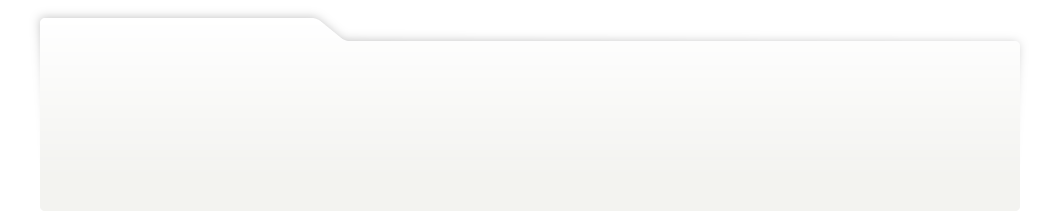
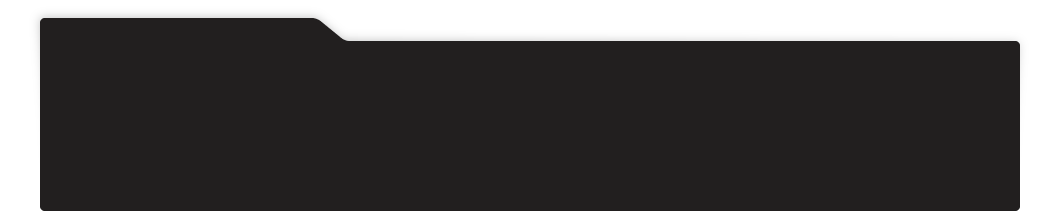
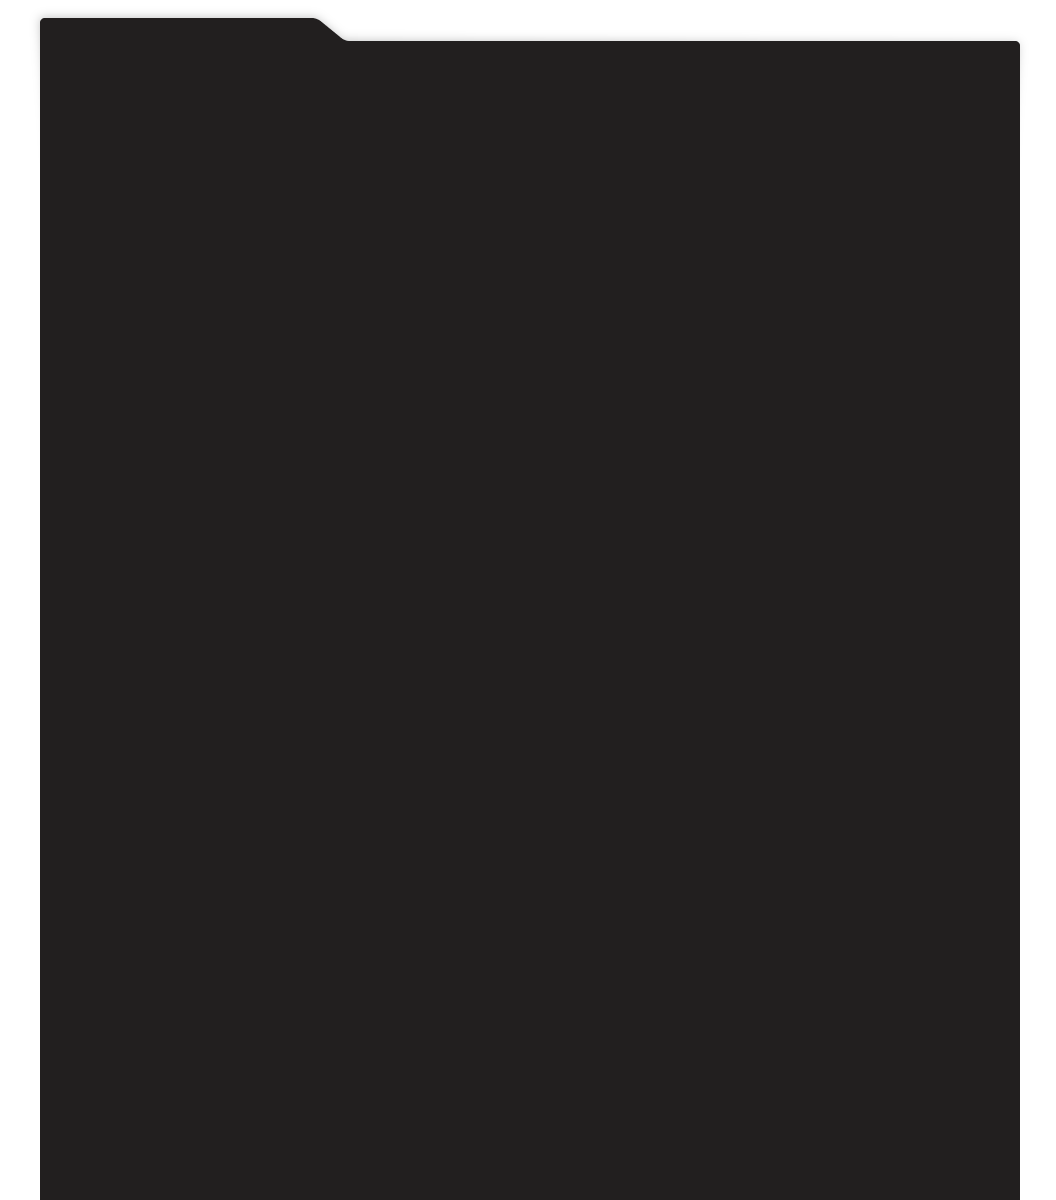
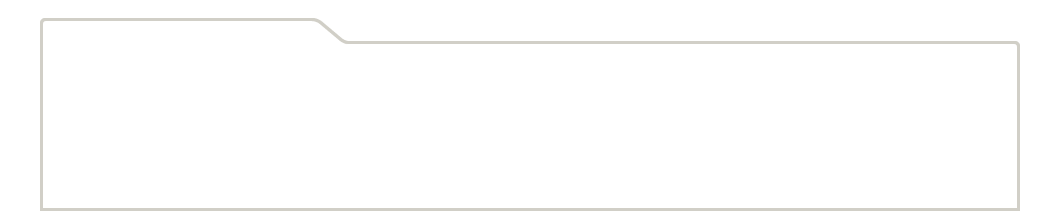
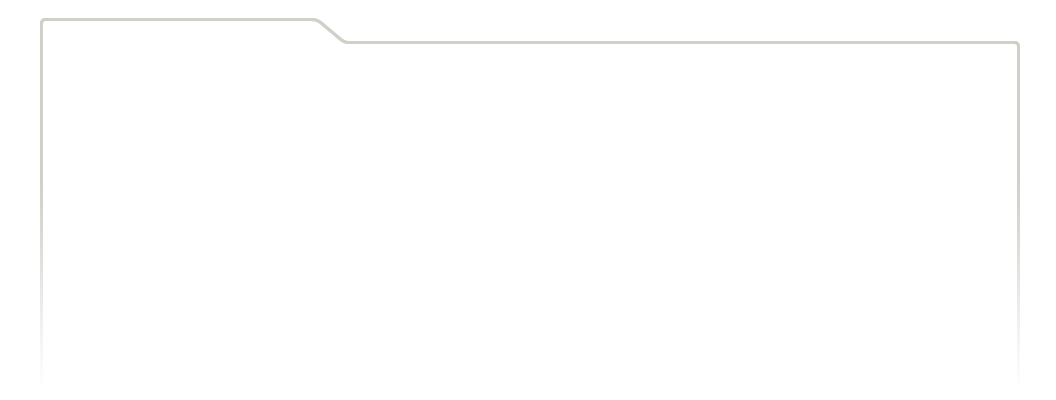
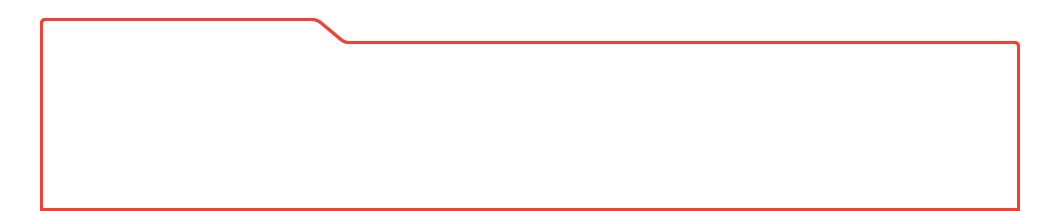
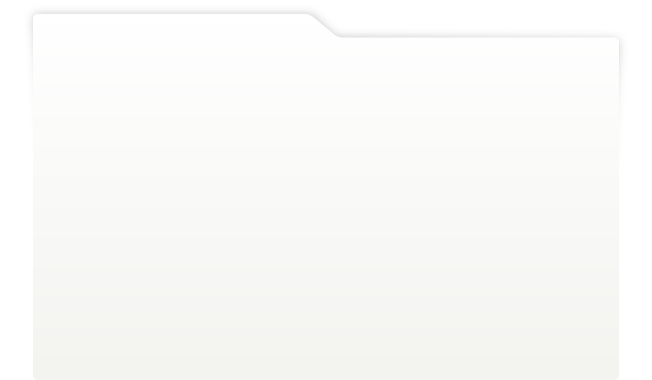
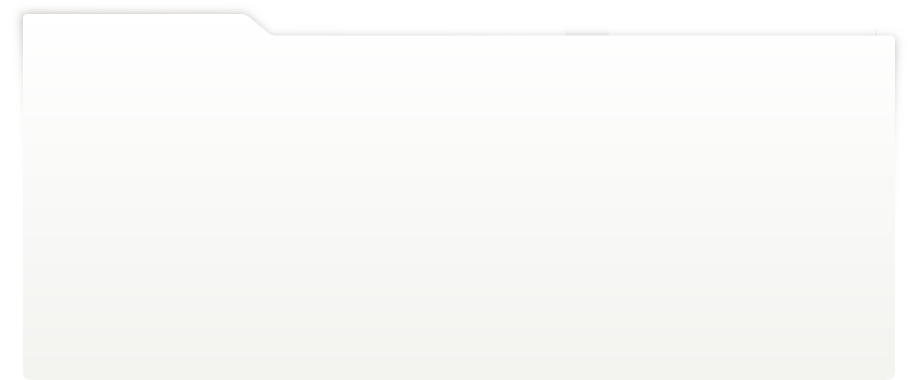
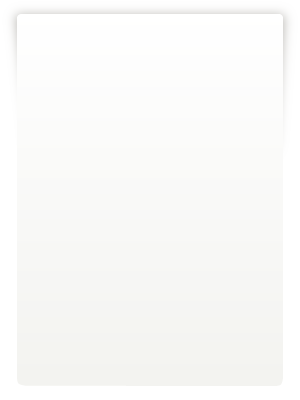
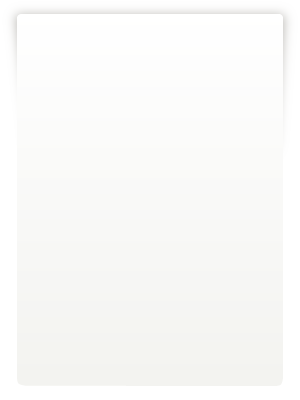
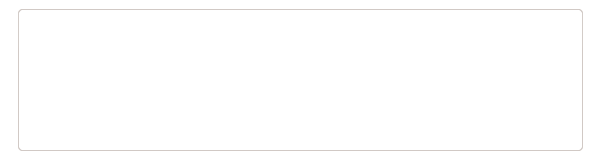
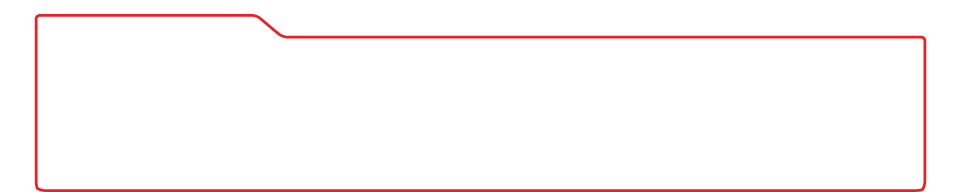
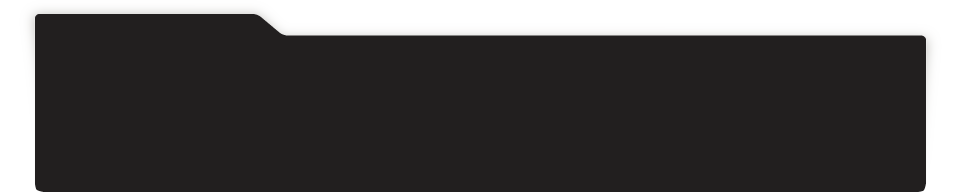
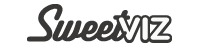
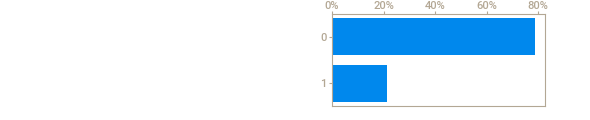
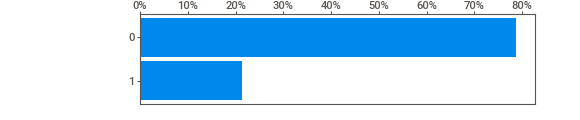
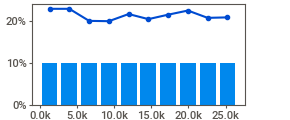
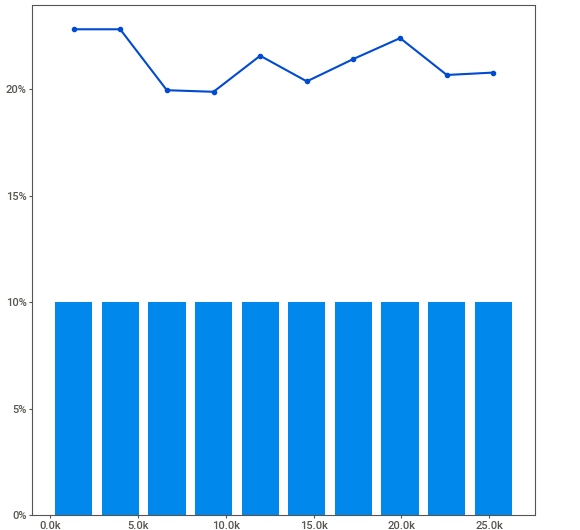
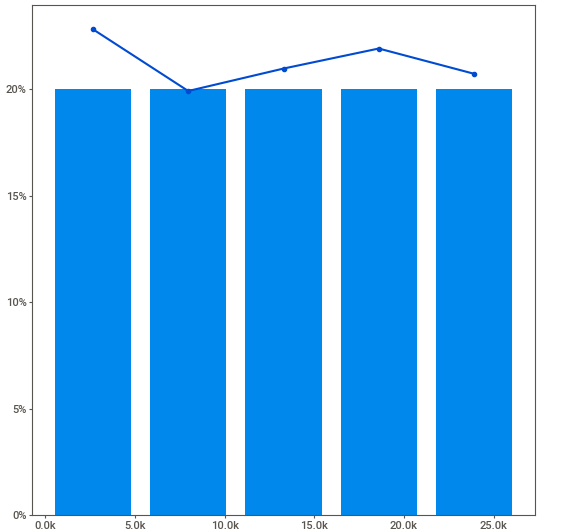
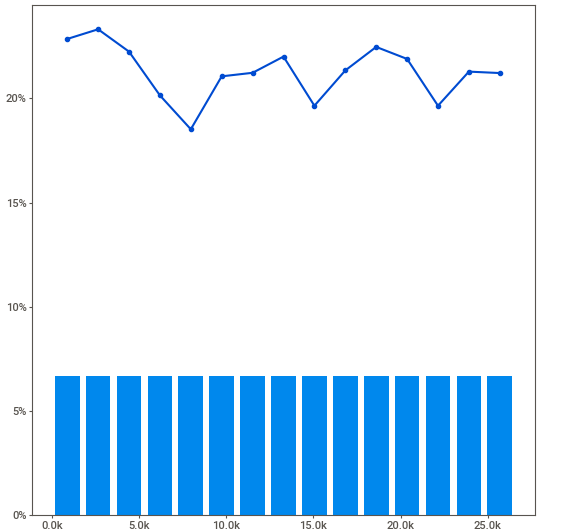
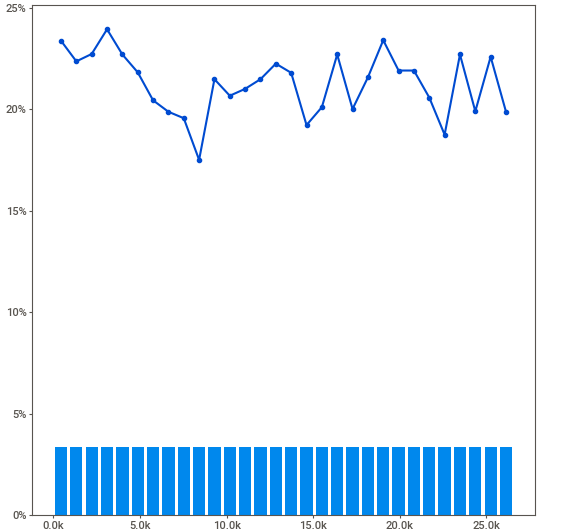
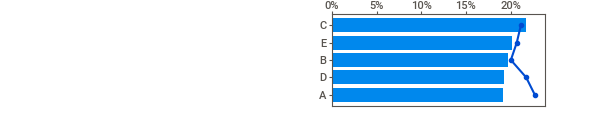
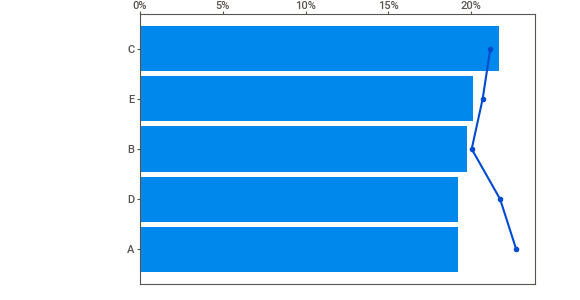
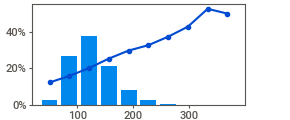
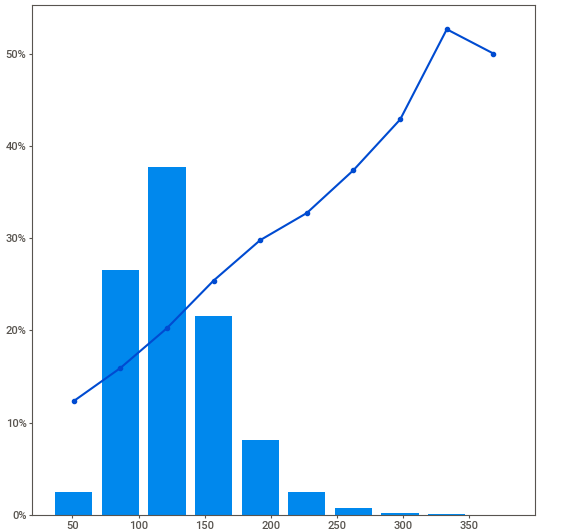
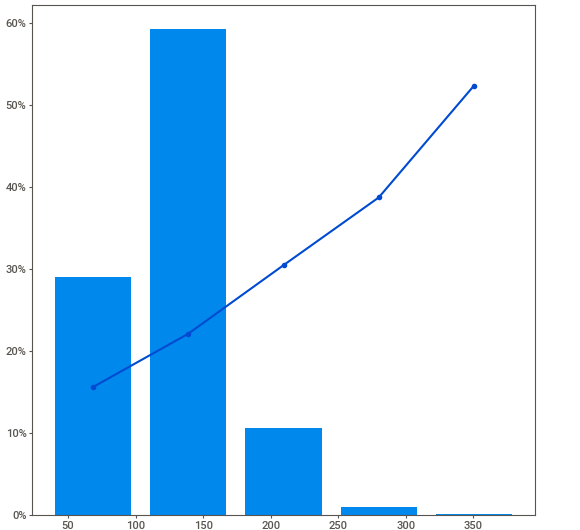
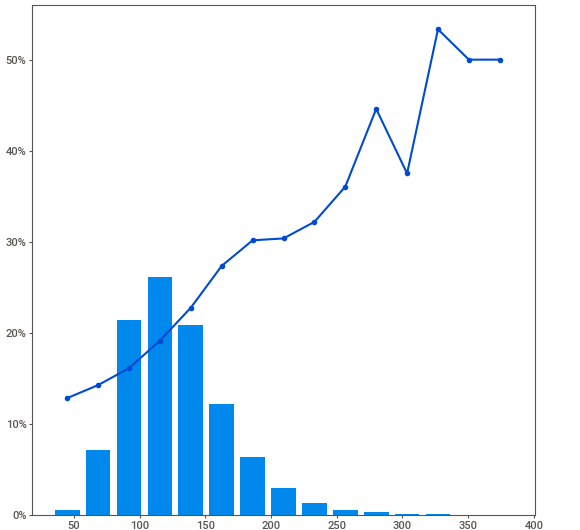
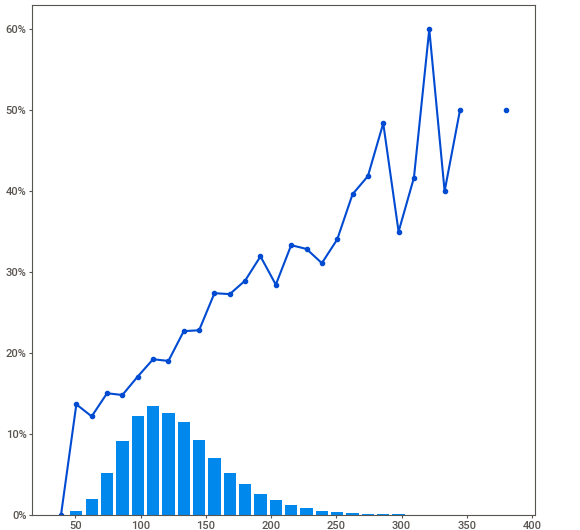
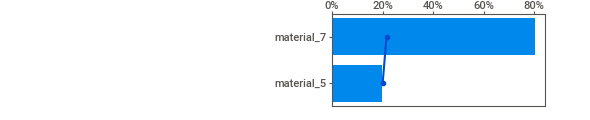
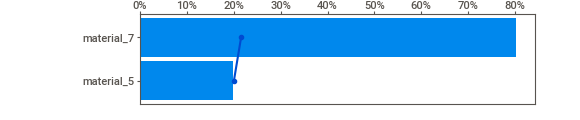
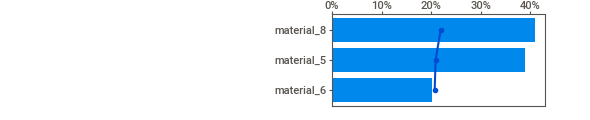
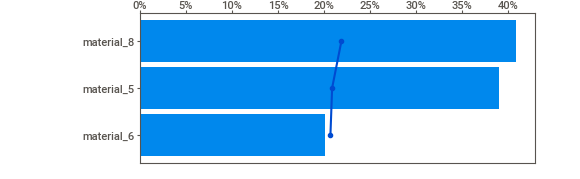
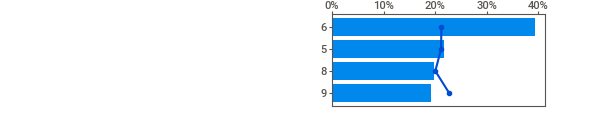
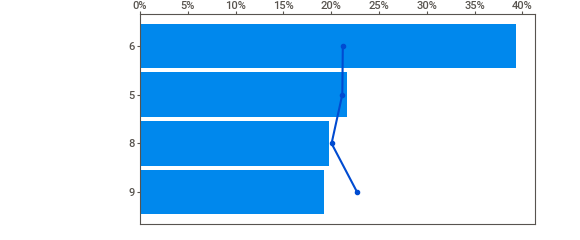
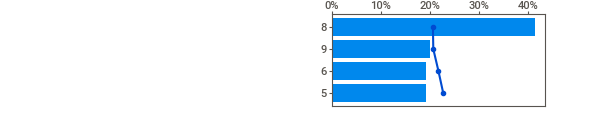
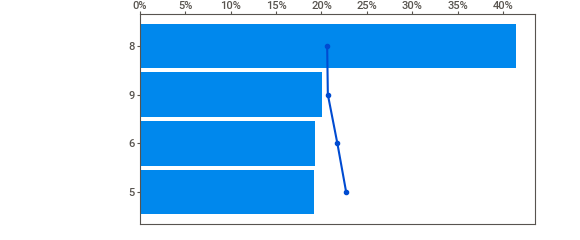
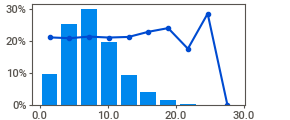
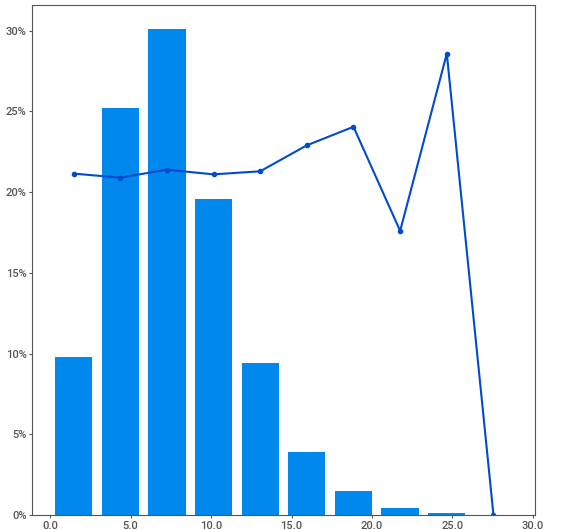
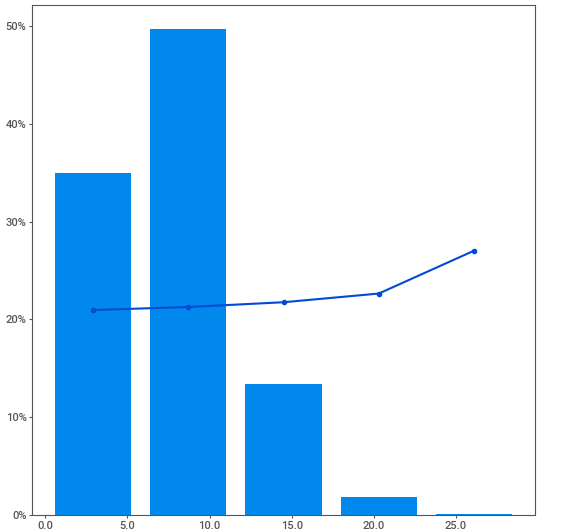
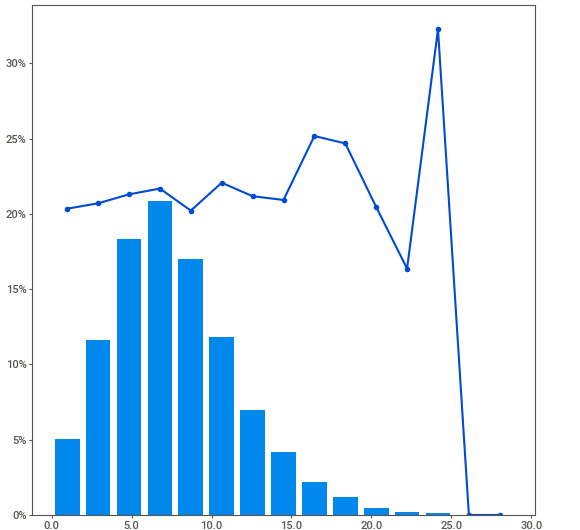
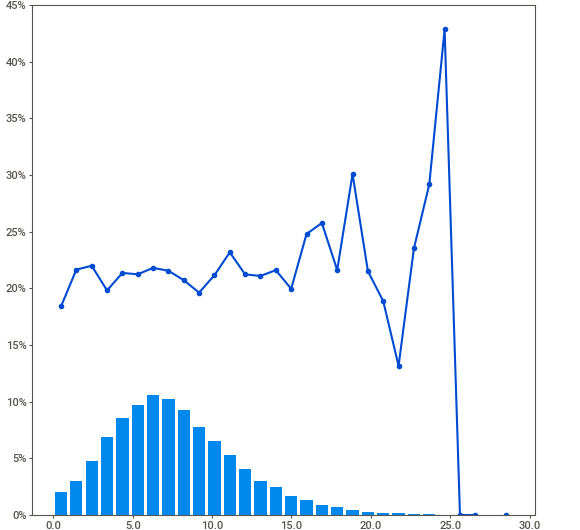
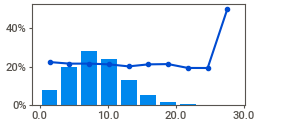
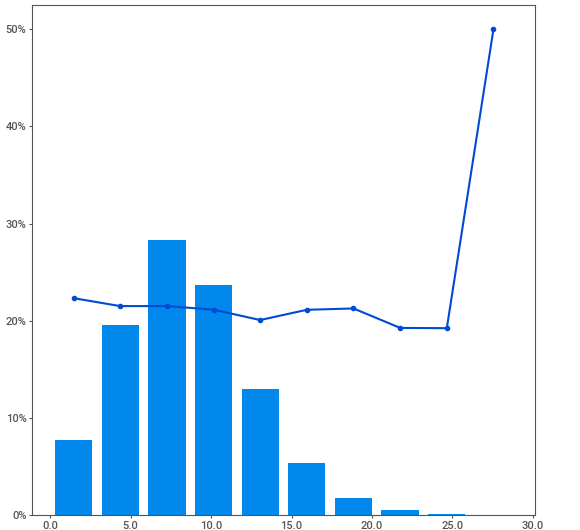
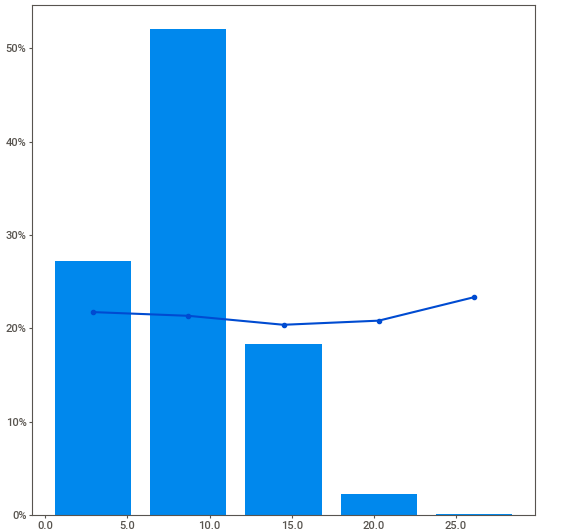
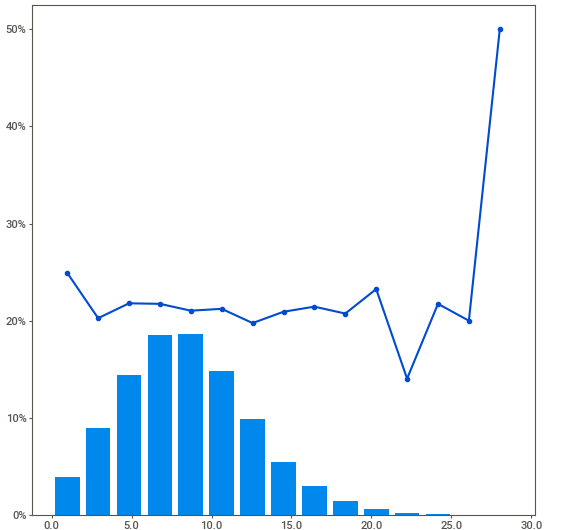
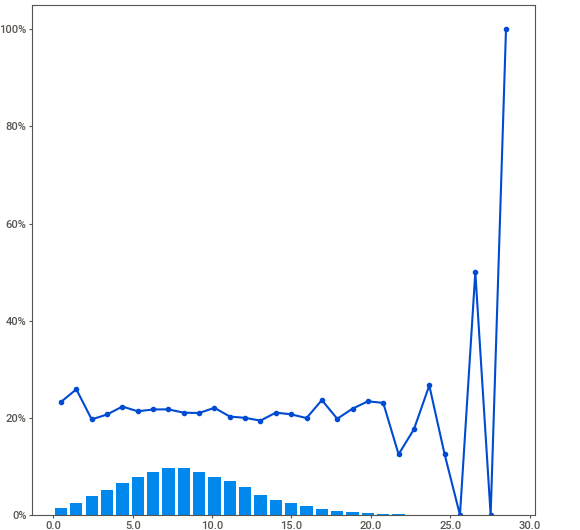
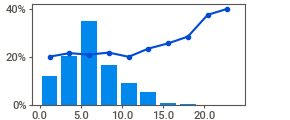
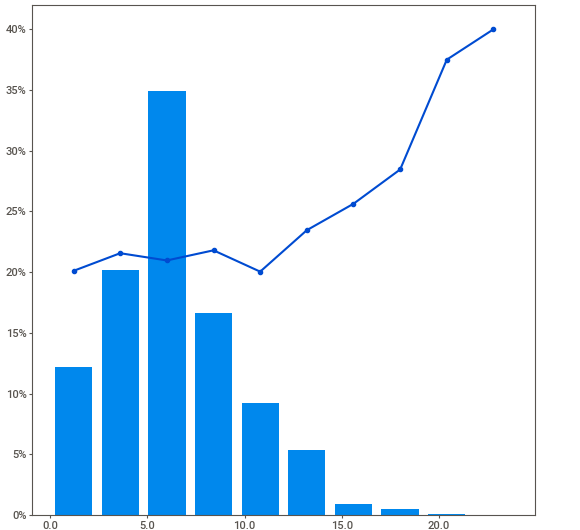
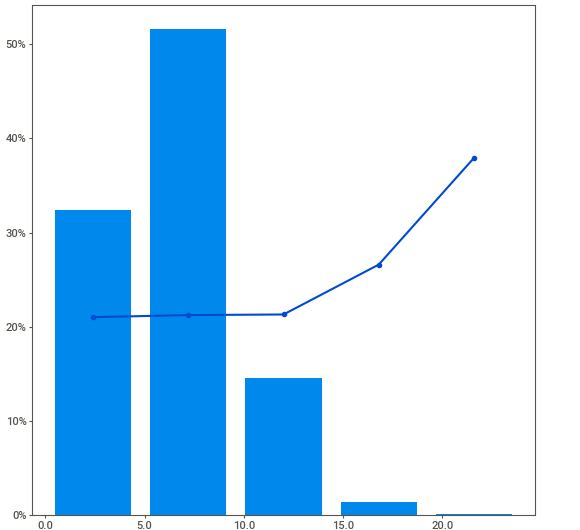
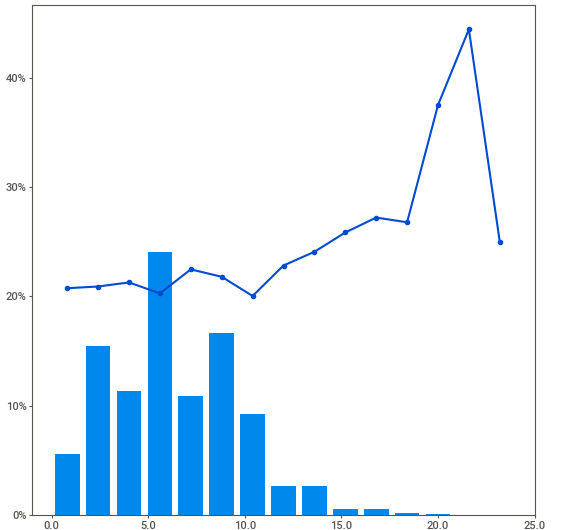
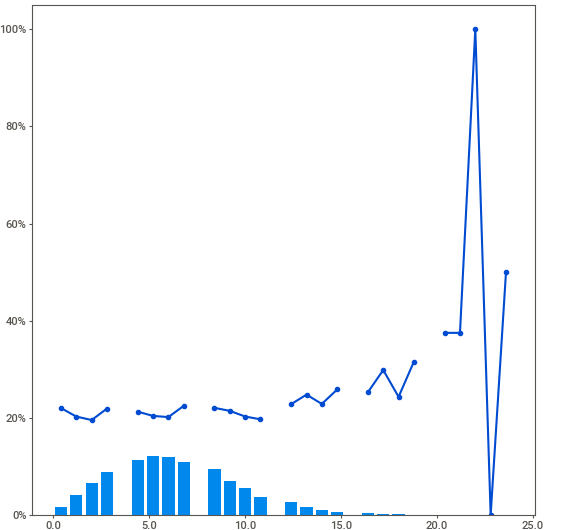
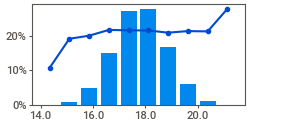
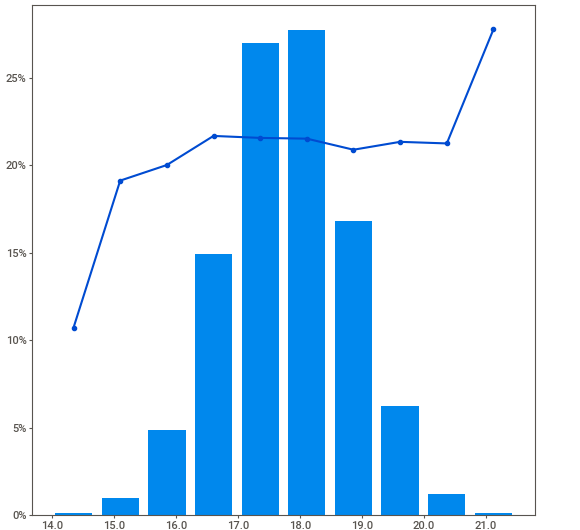
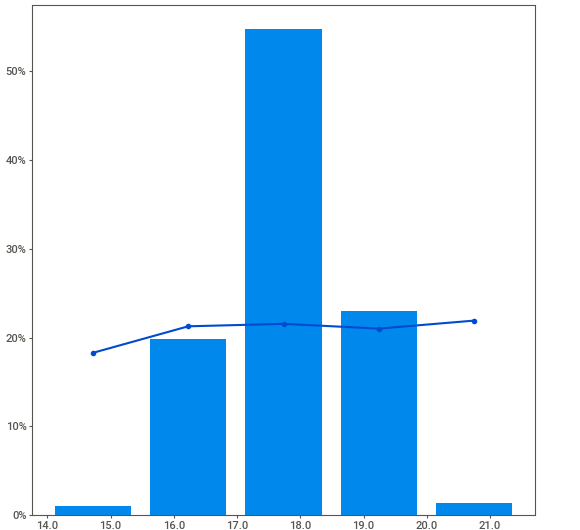
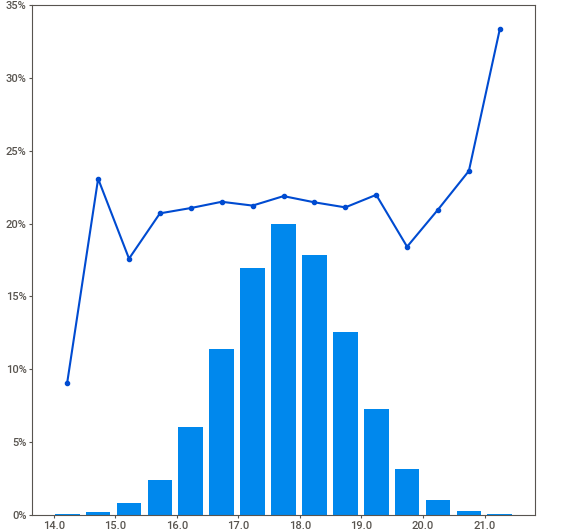
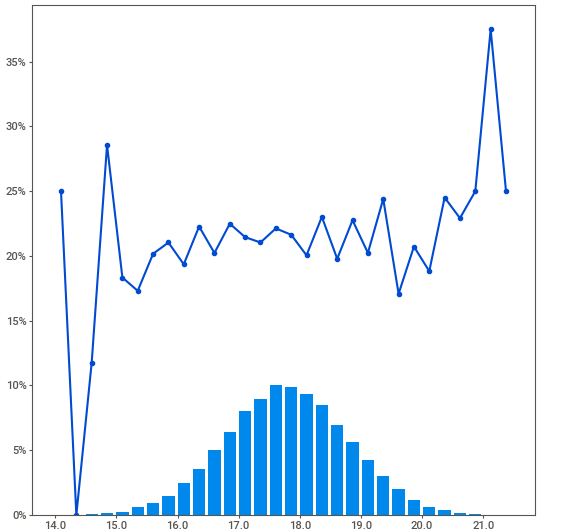
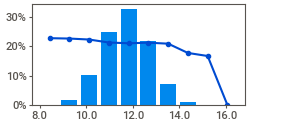
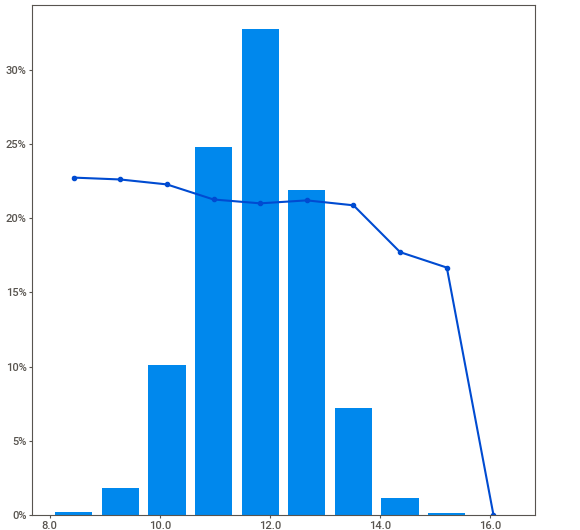
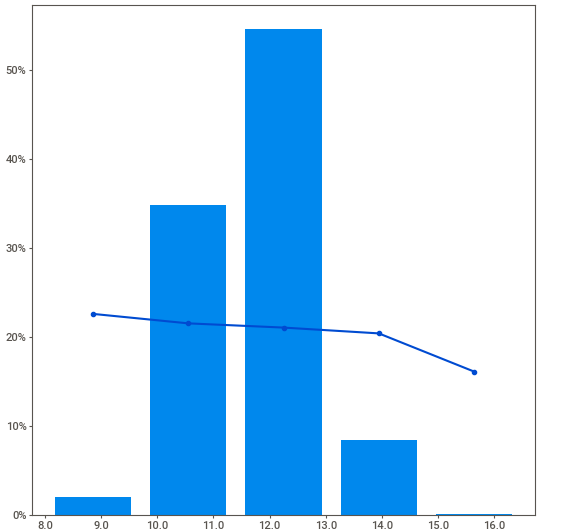
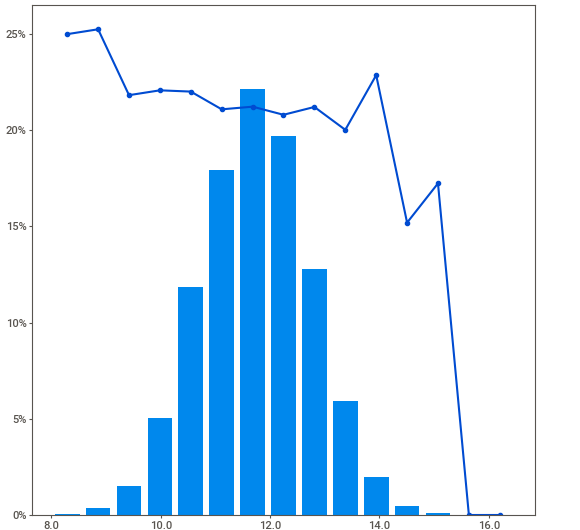
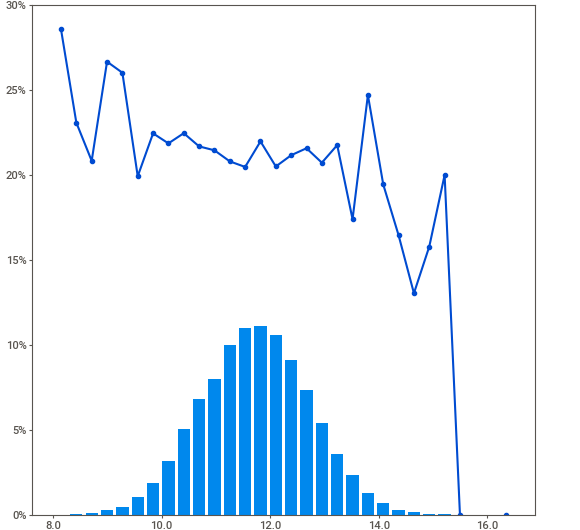
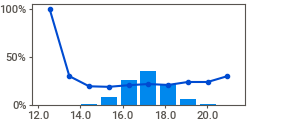
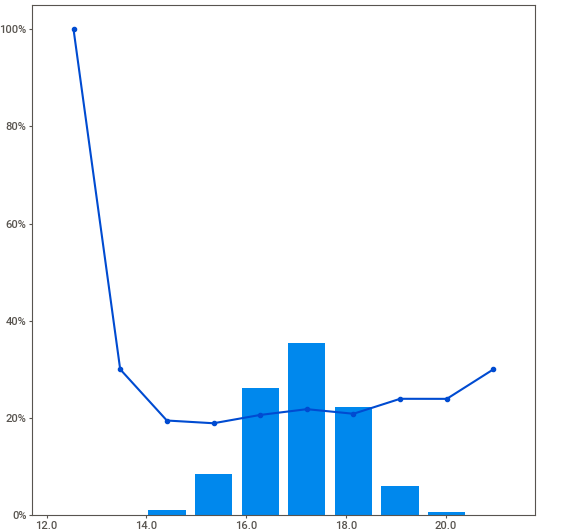
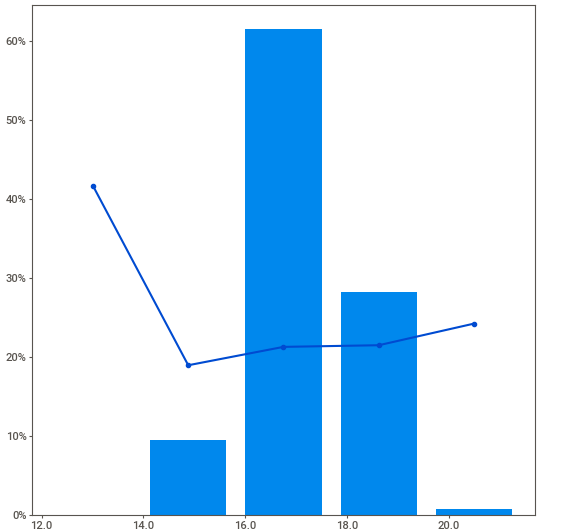
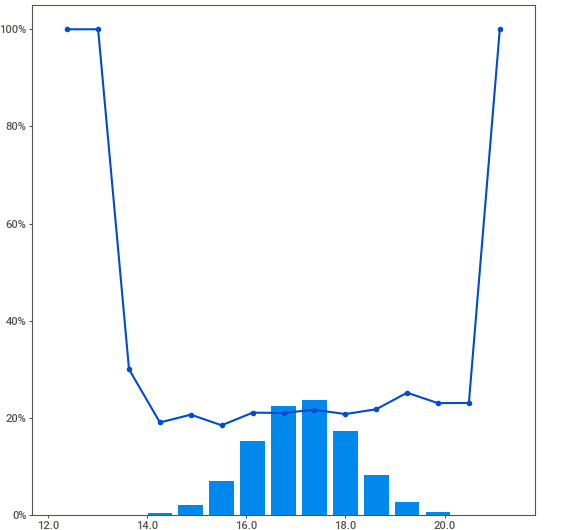
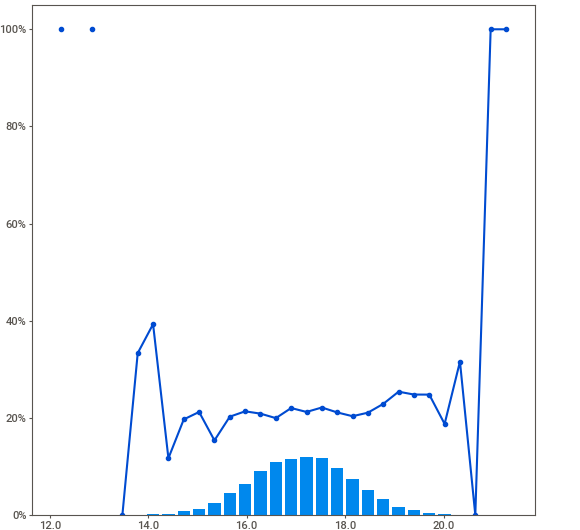
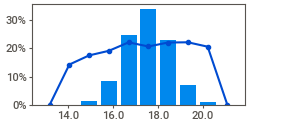
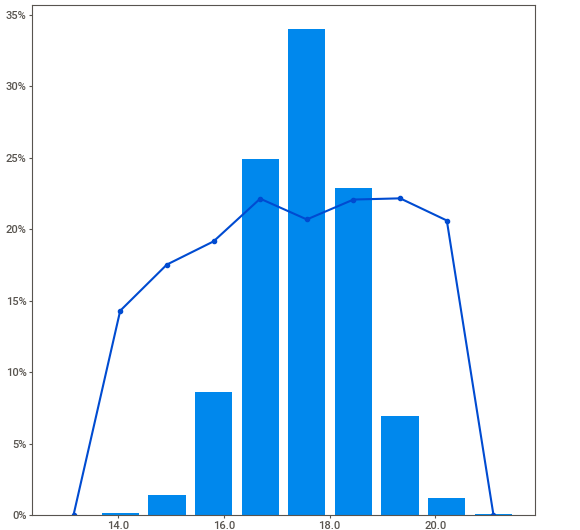
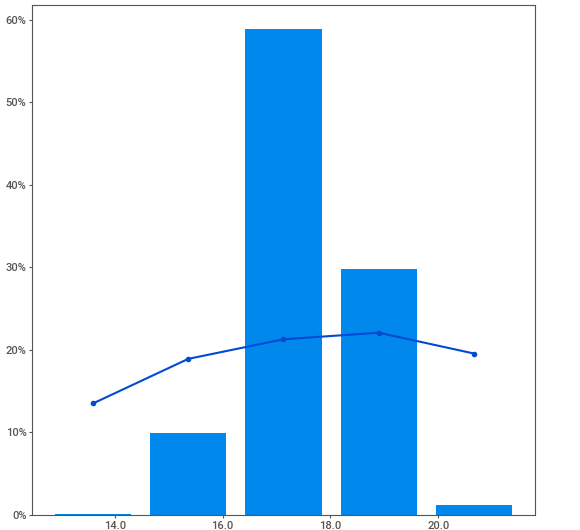
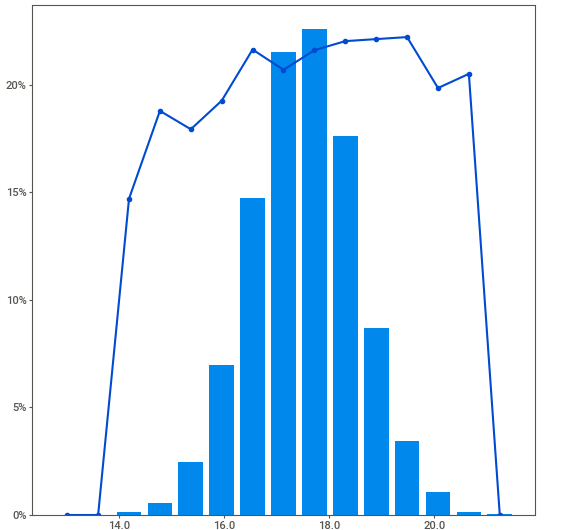
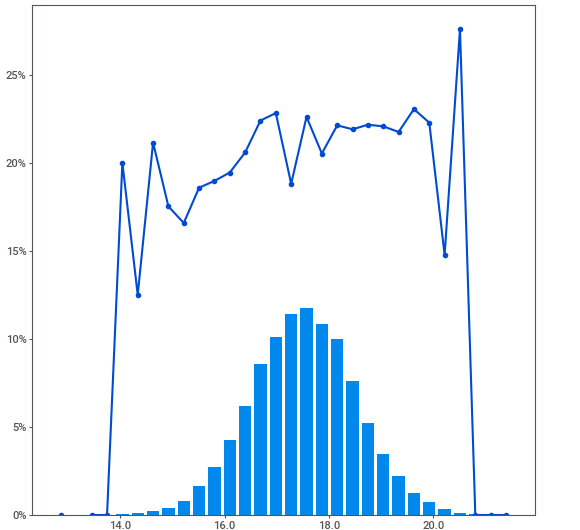
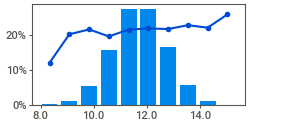
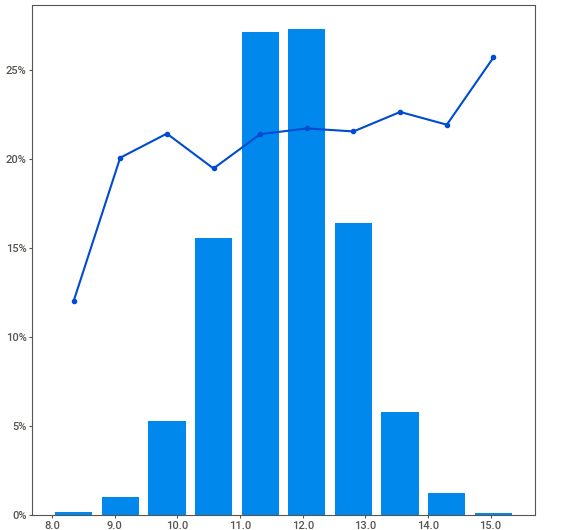
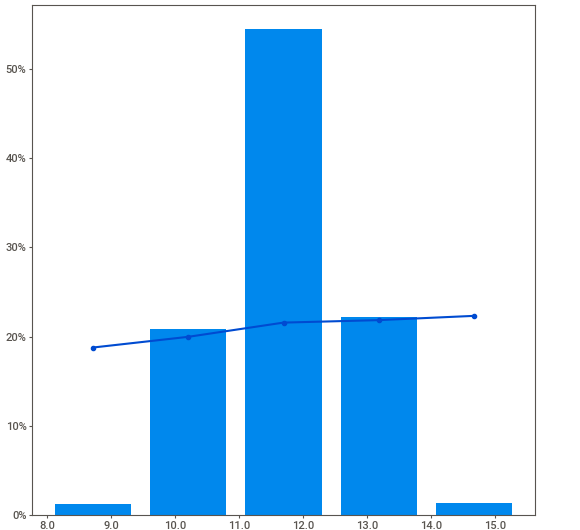
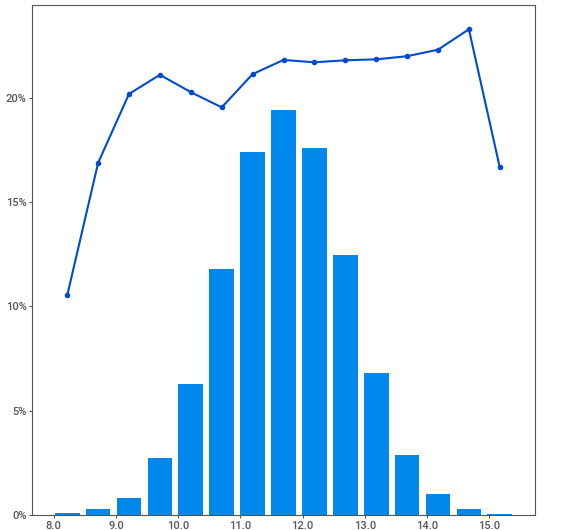
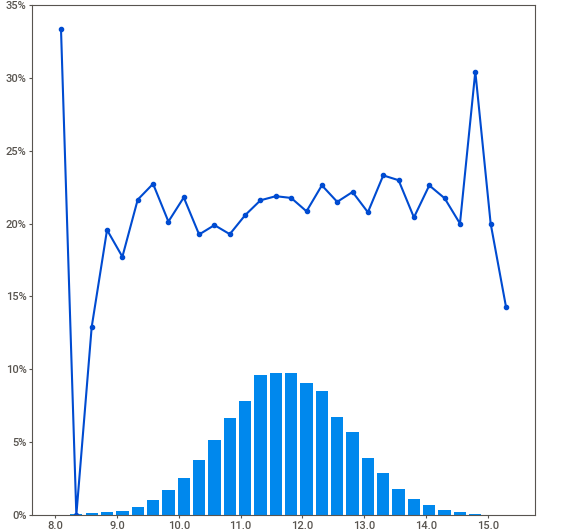
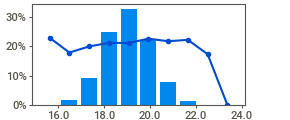
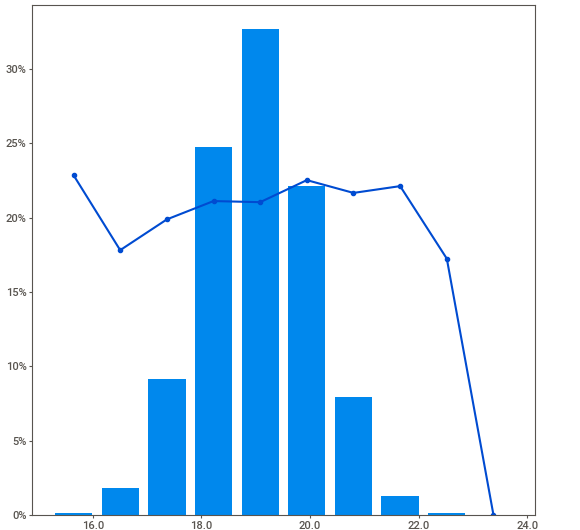
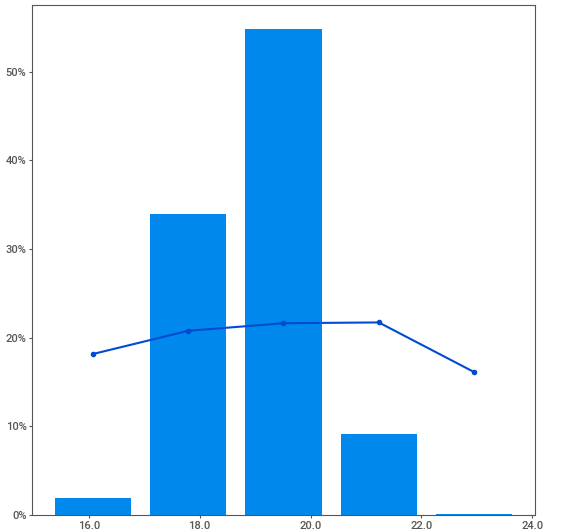
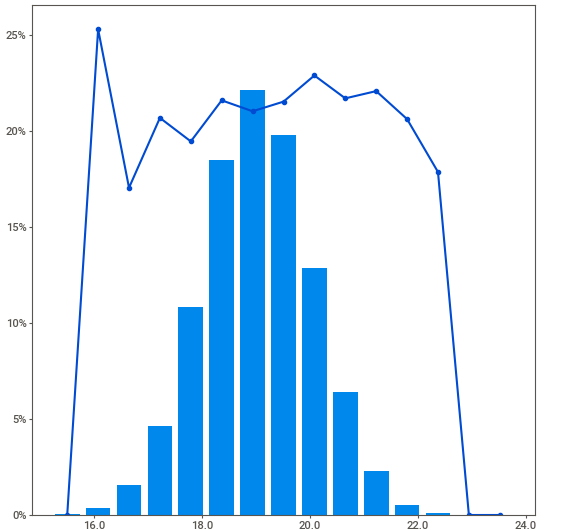
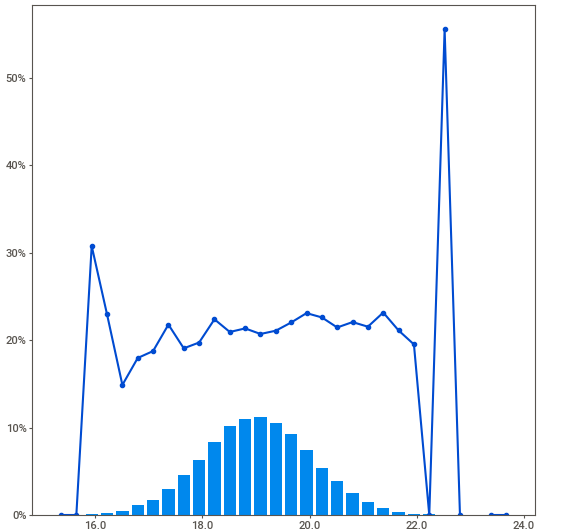
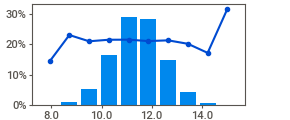
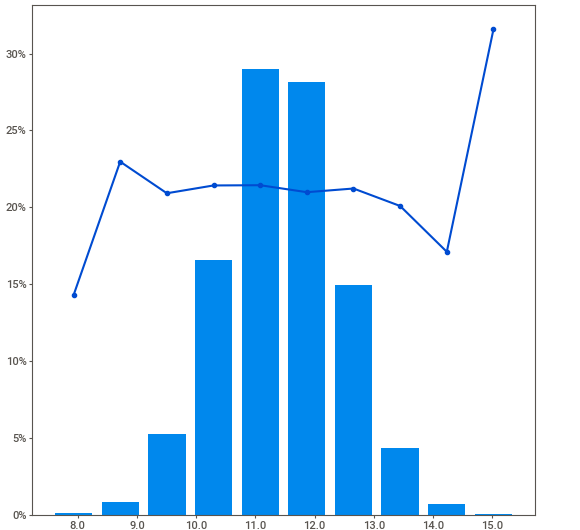
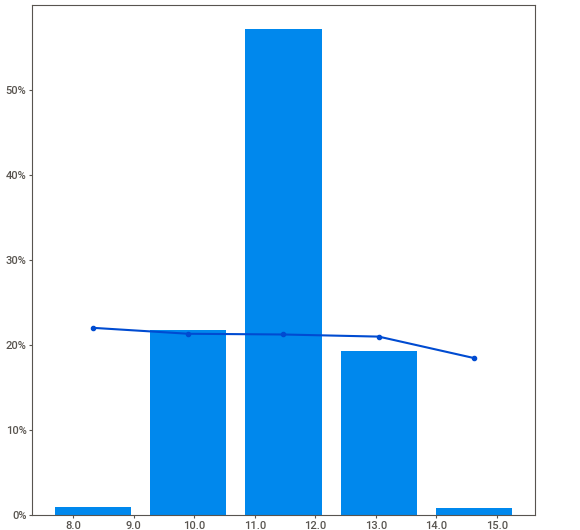
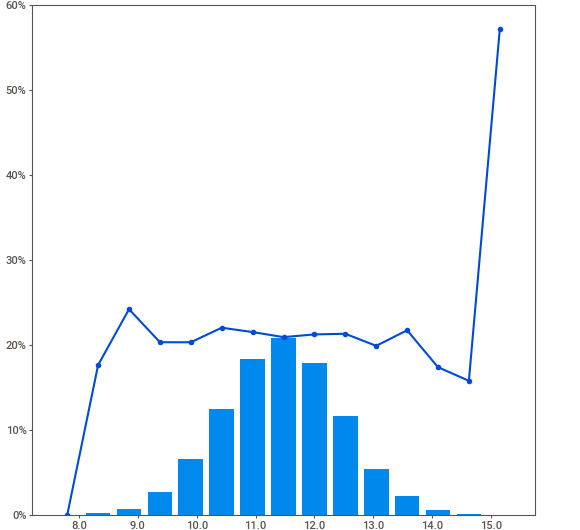
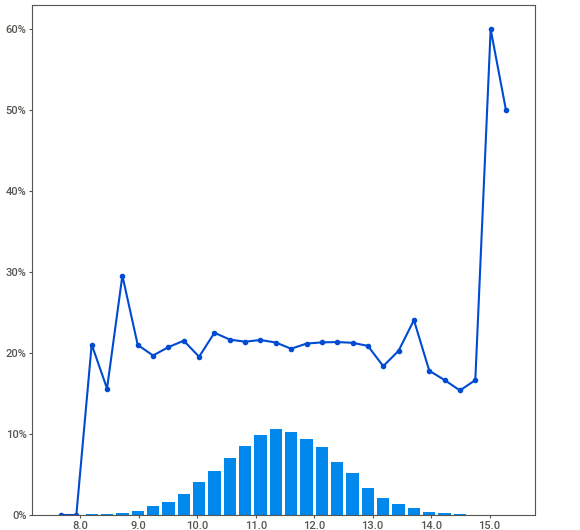
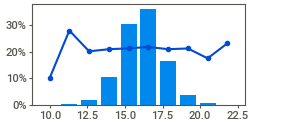
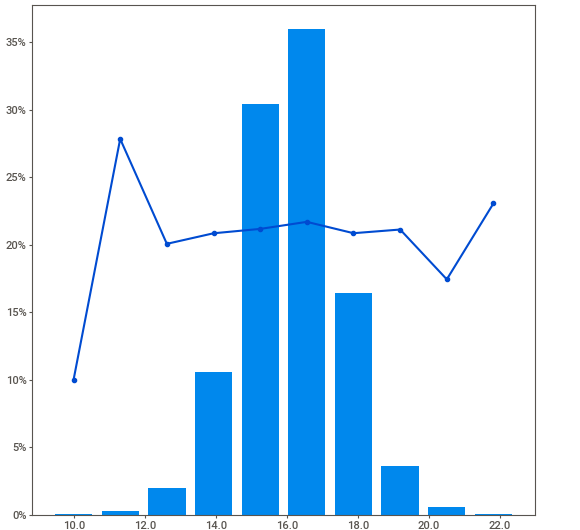
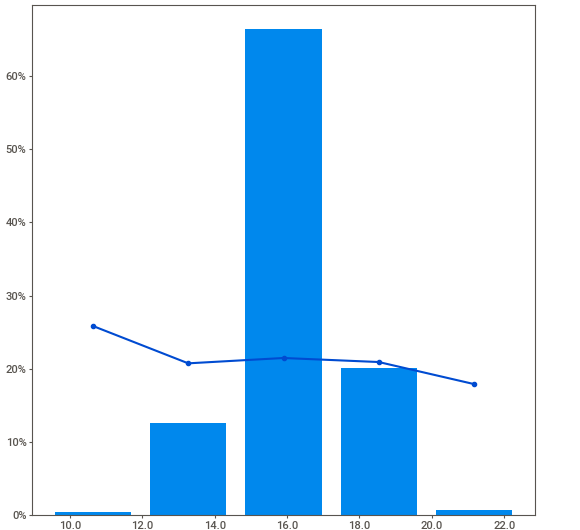
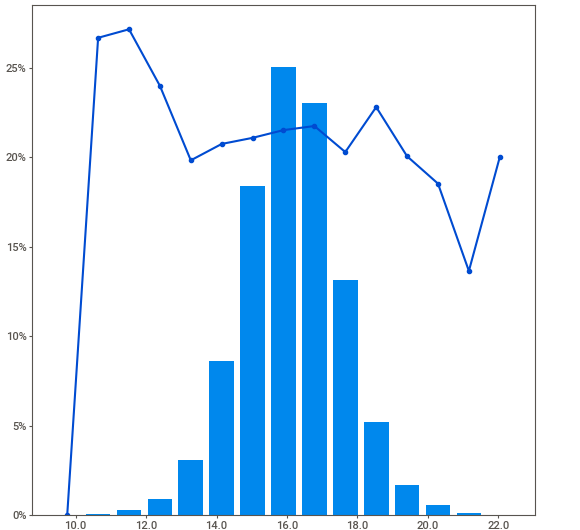
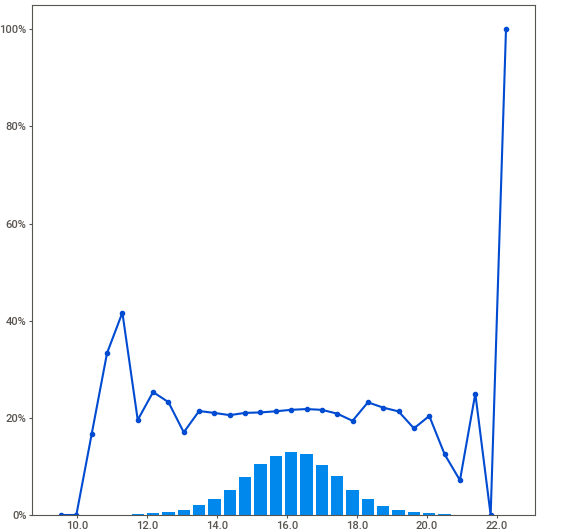
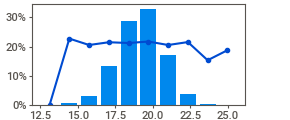
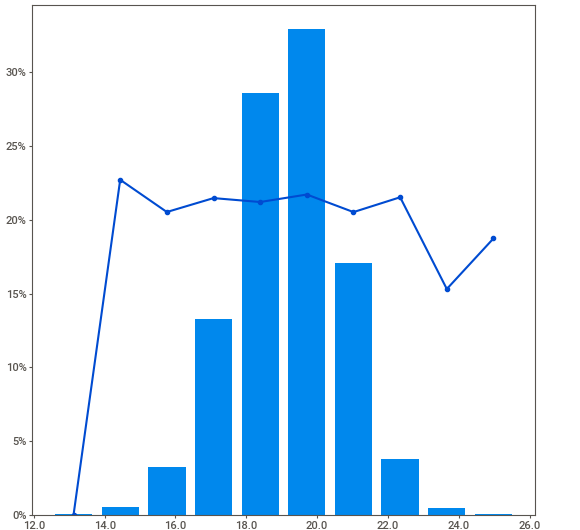
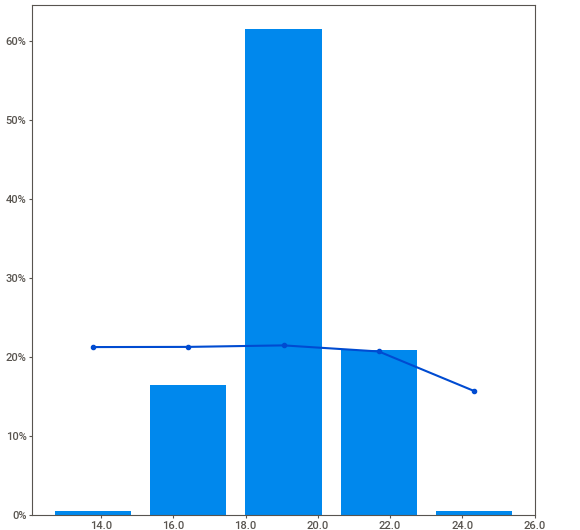
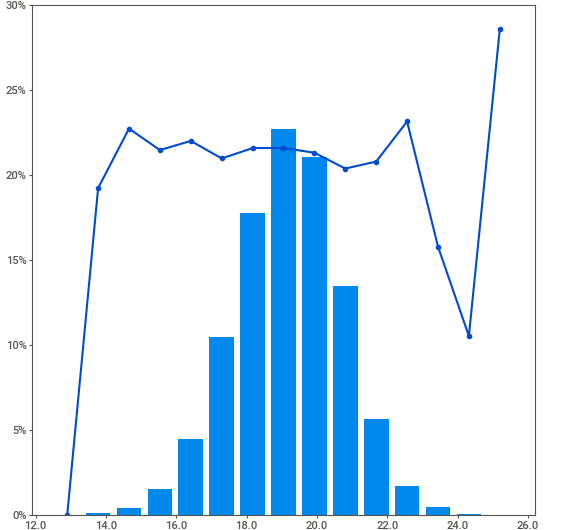
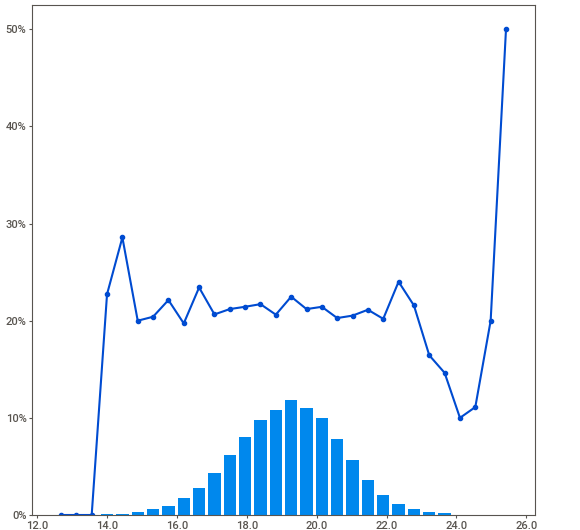
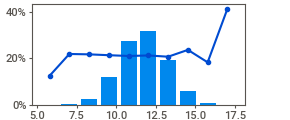
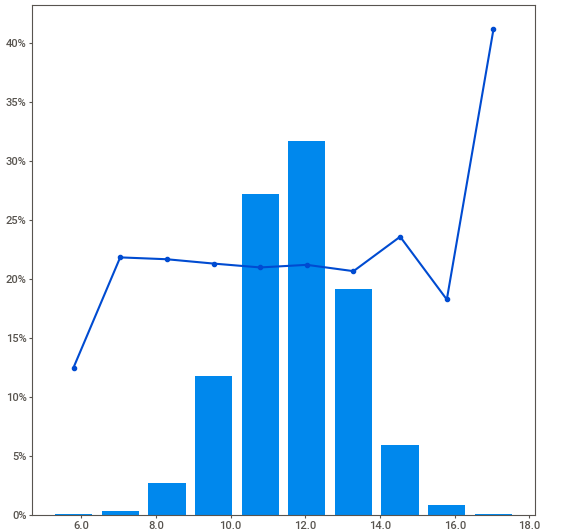
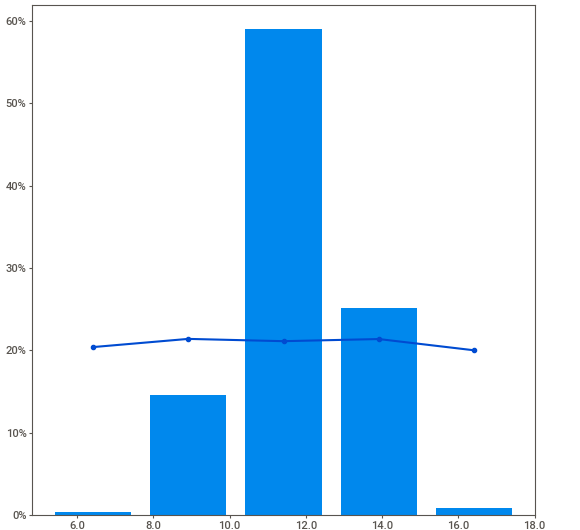
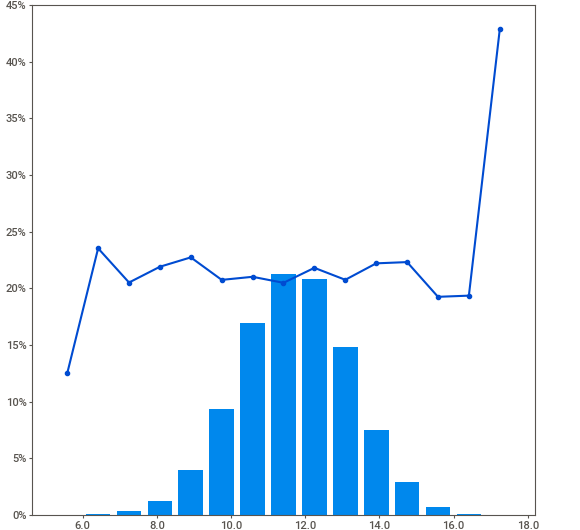
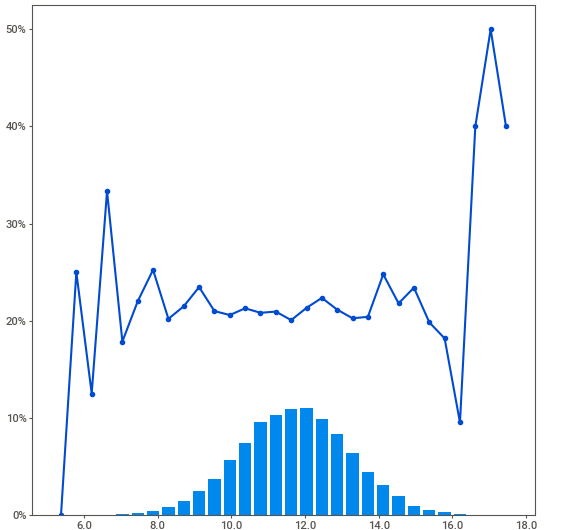
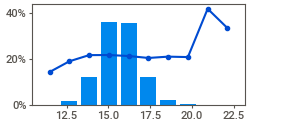
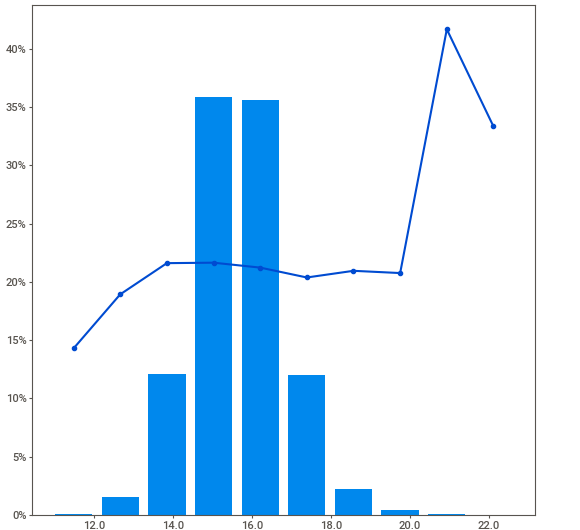
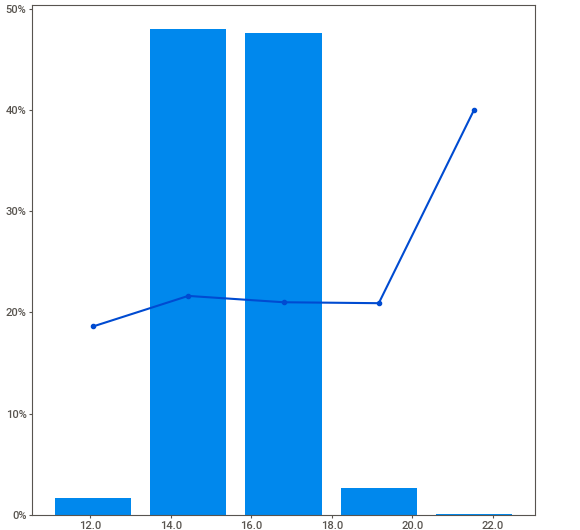
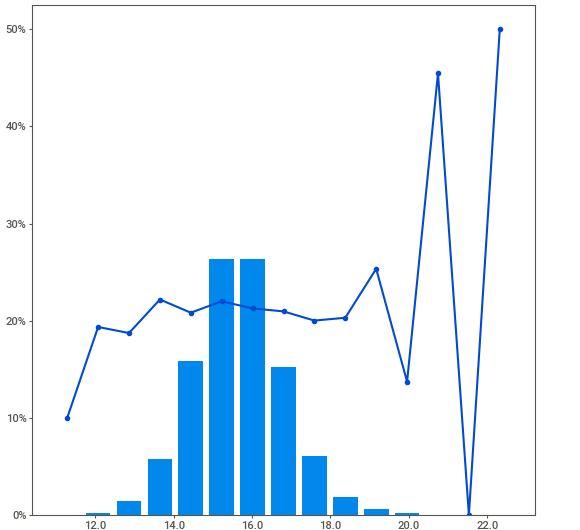
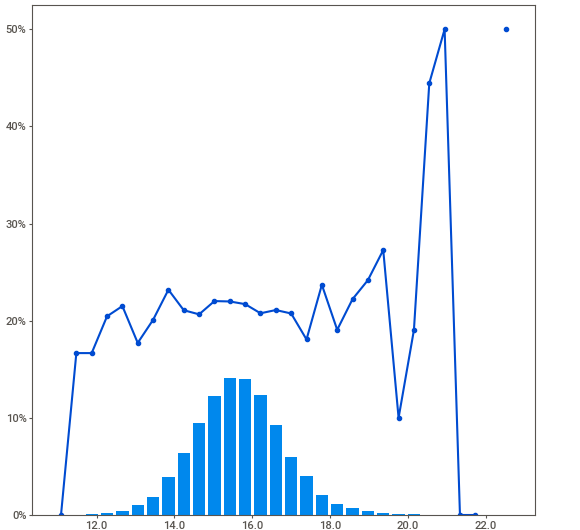
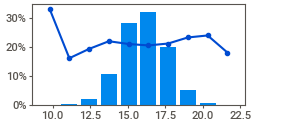
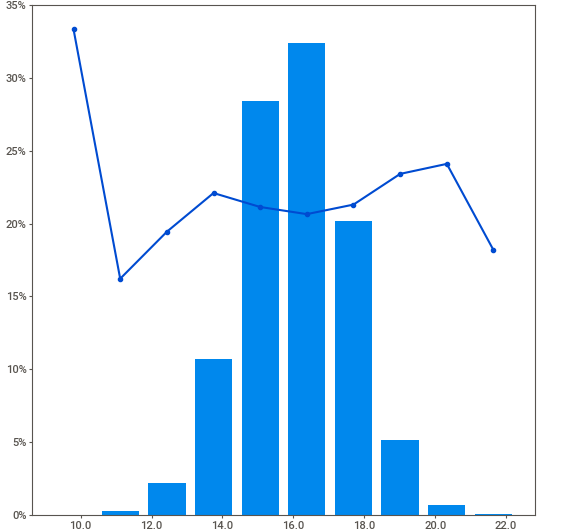
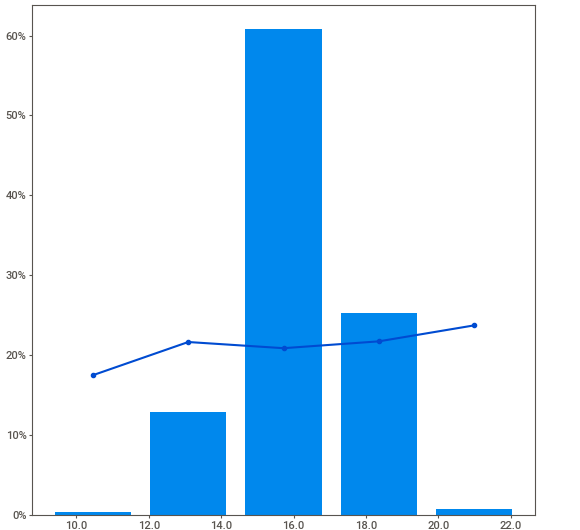
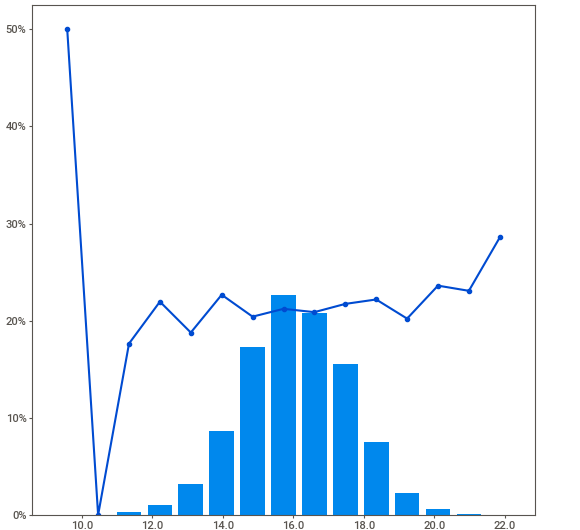
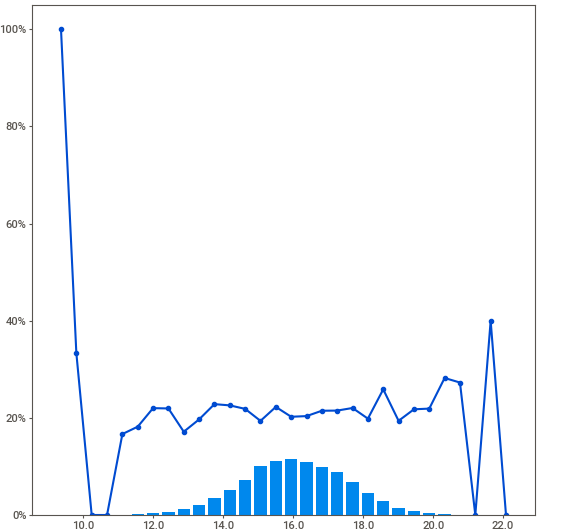
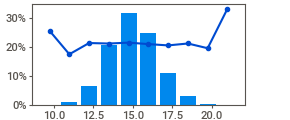
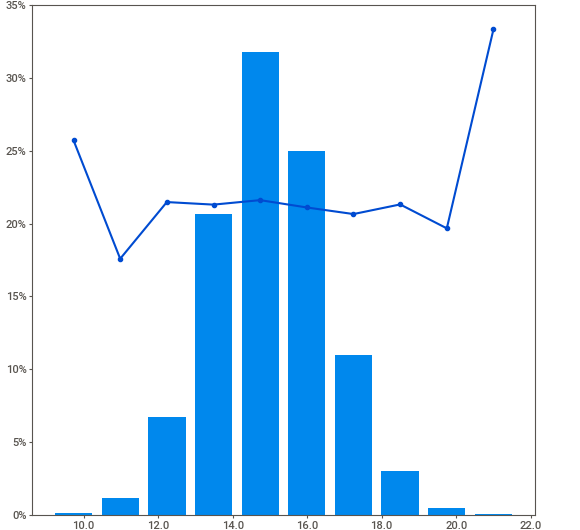
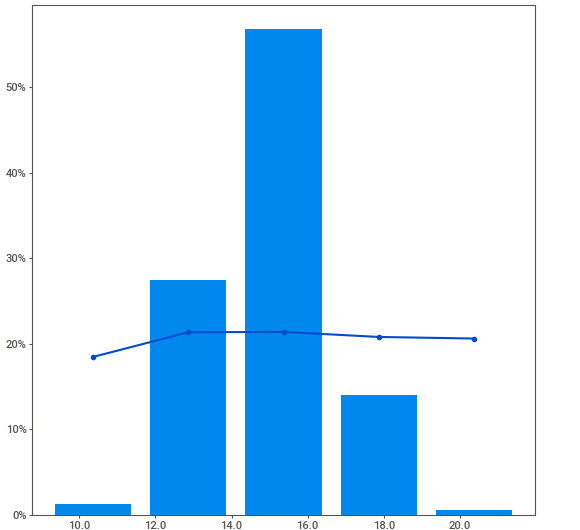
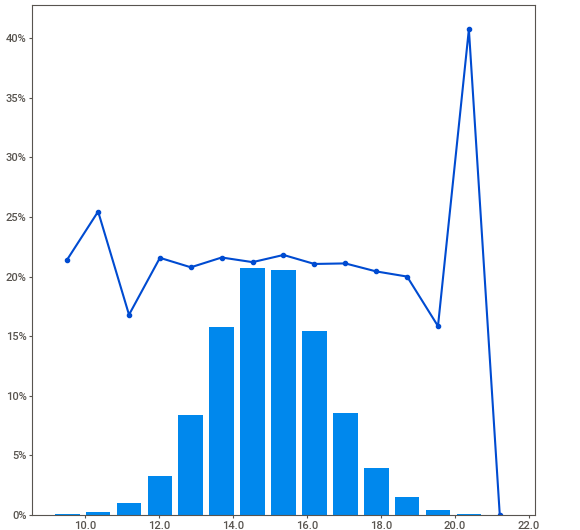
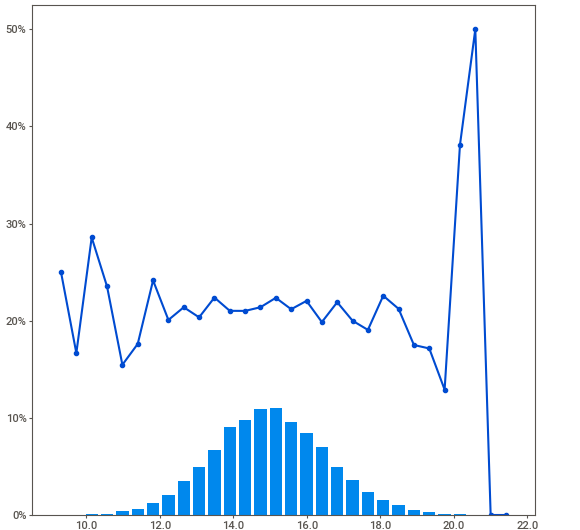
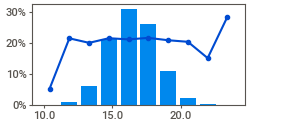
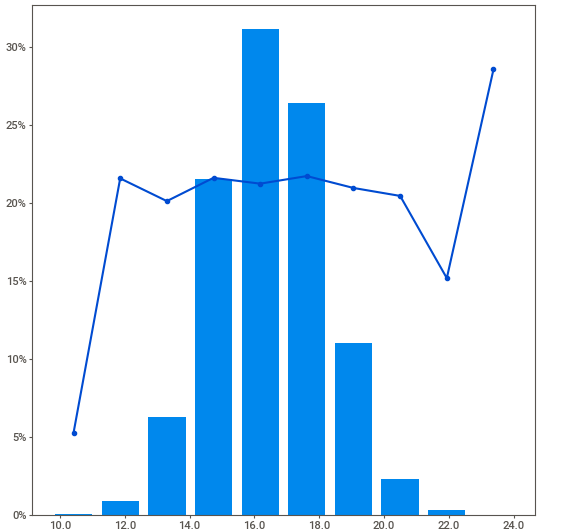
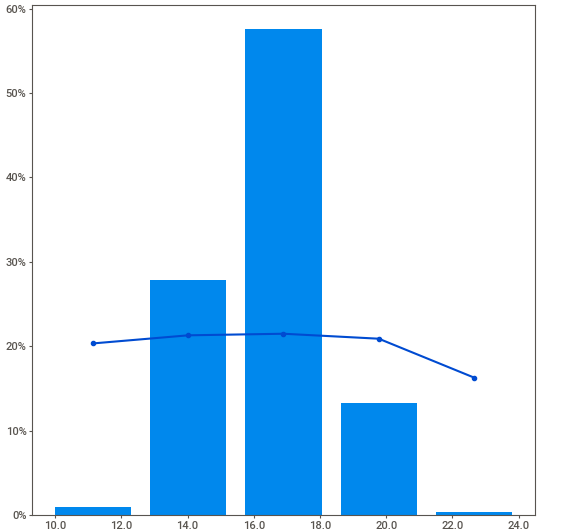
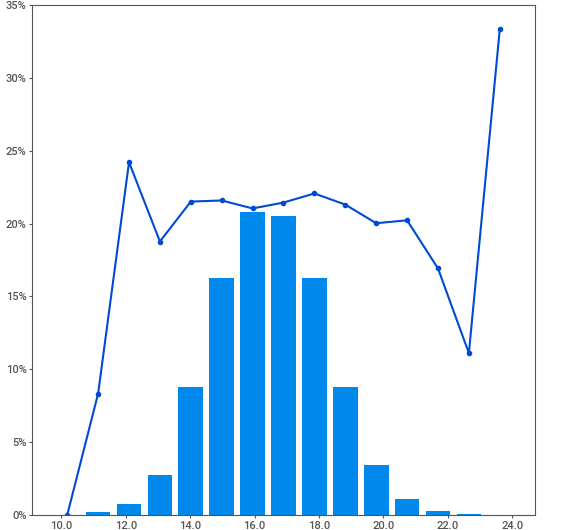
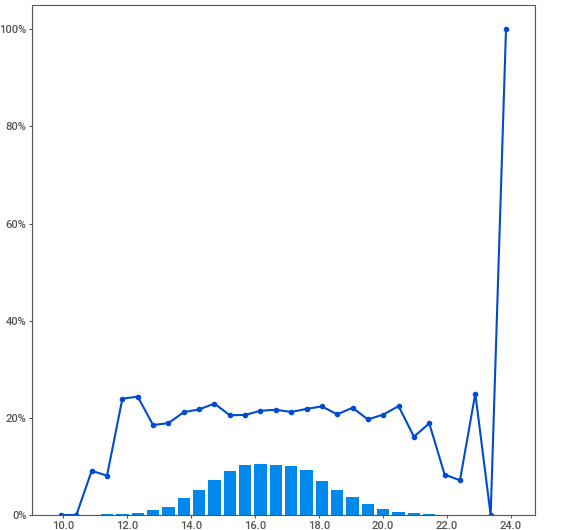
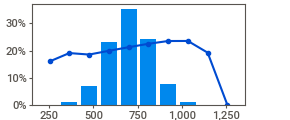
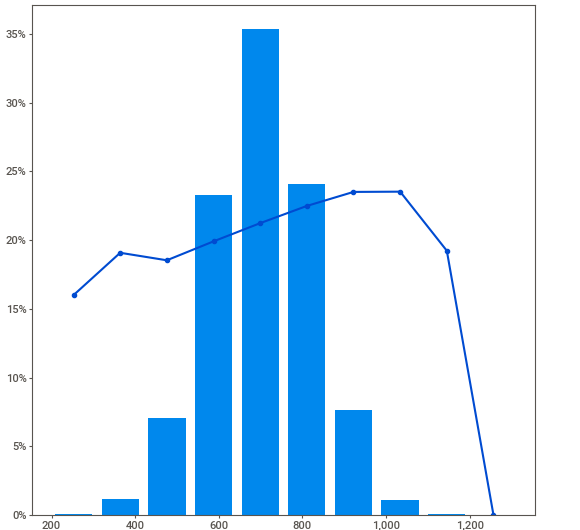
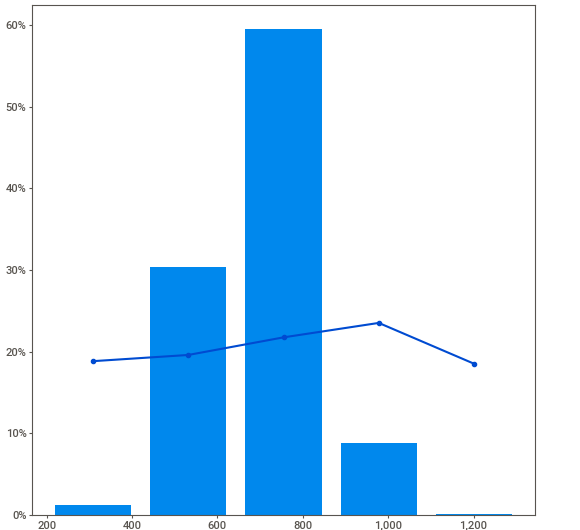
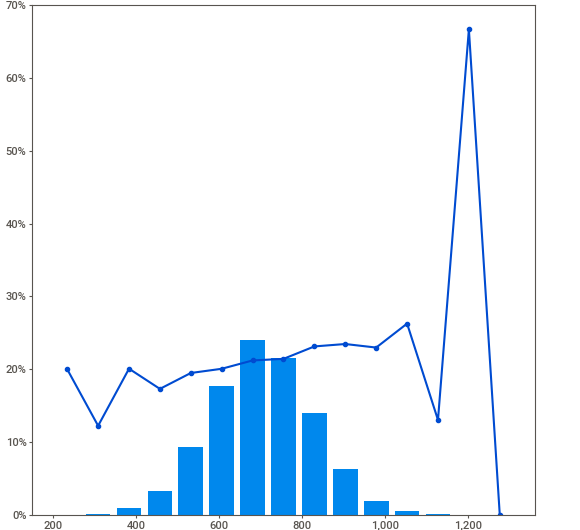
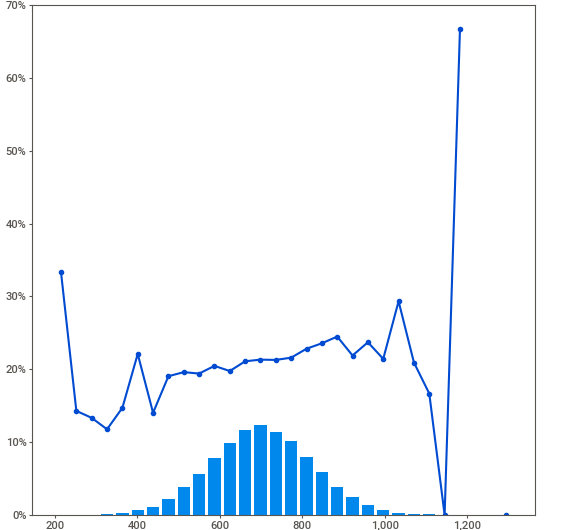
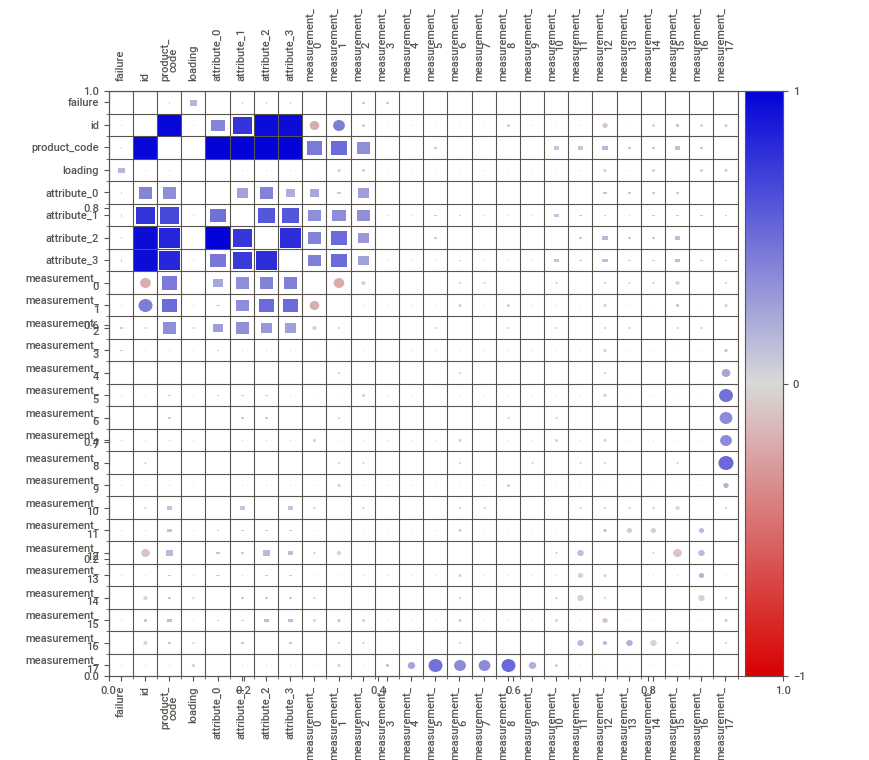
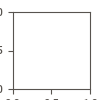

In [4]:

train_report = sv.analyze(train, target_feat="failure")
train_report.show_notebook()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



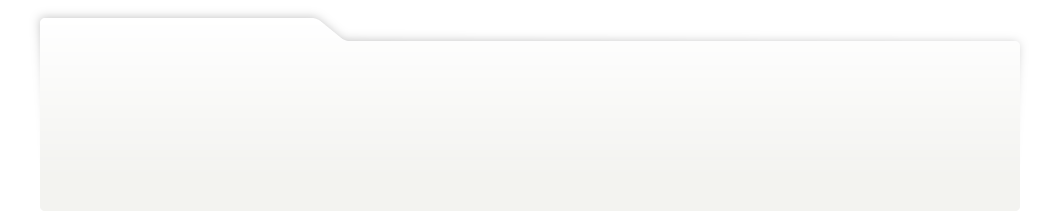
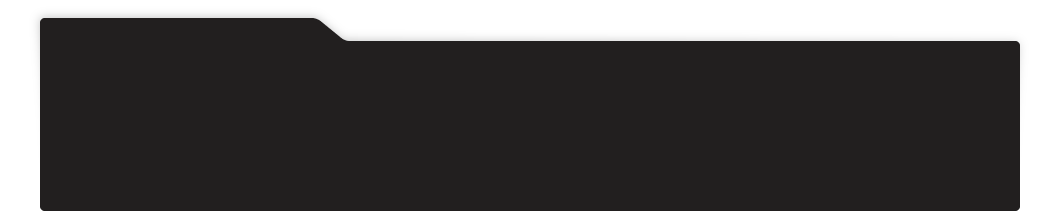
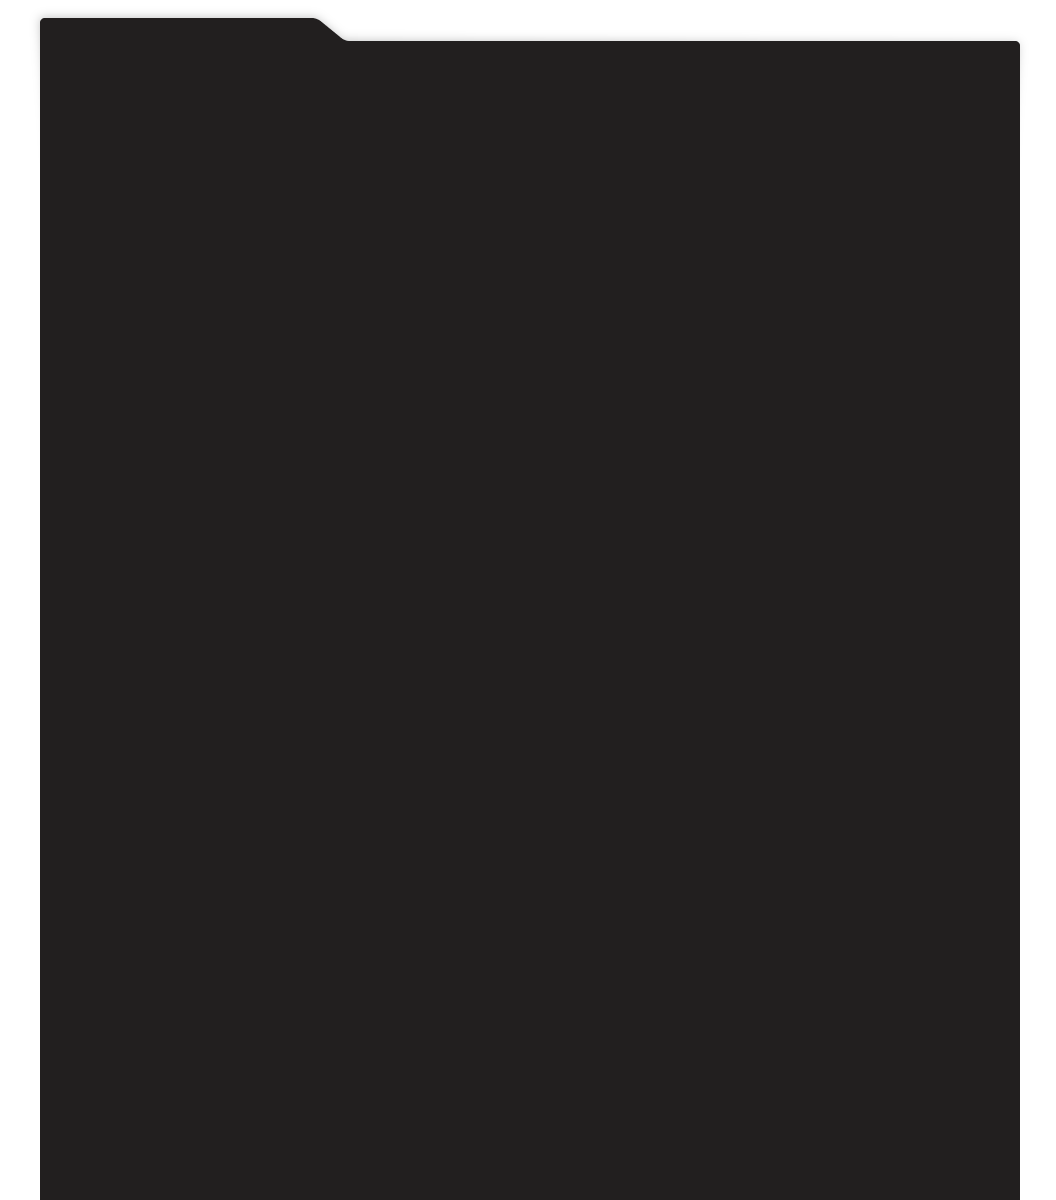
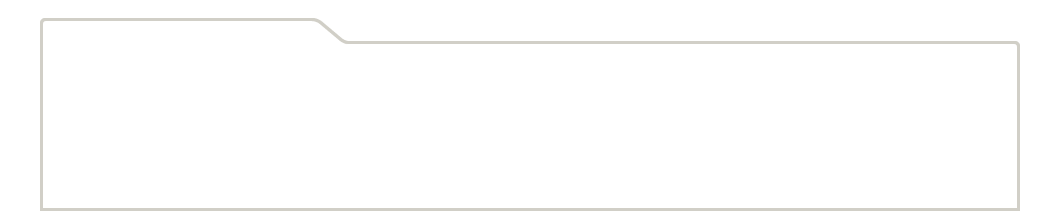
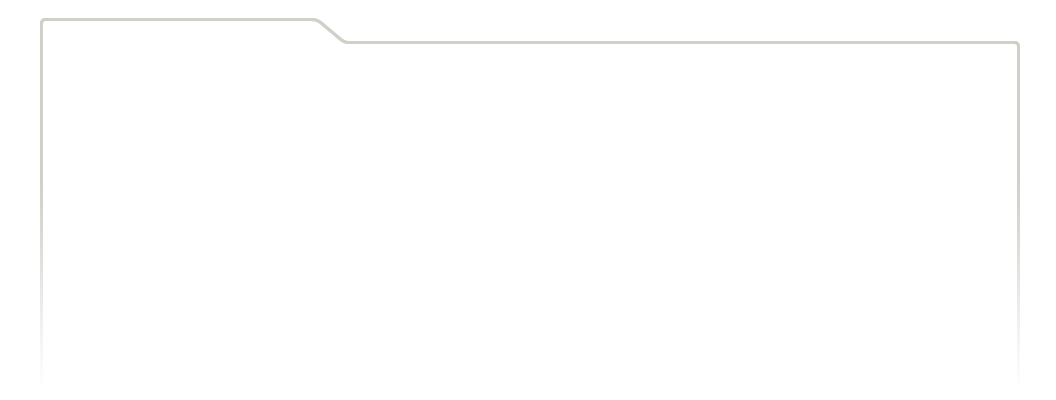
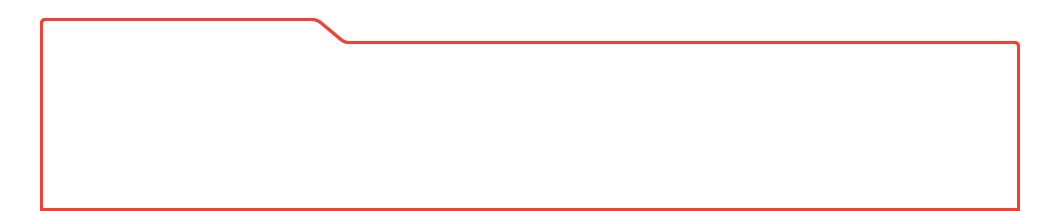
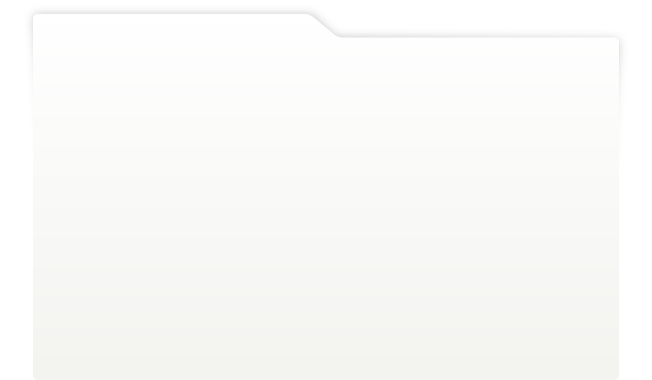
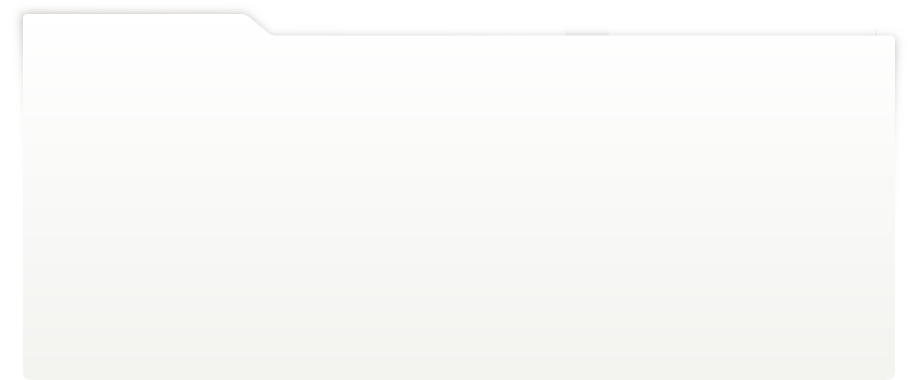
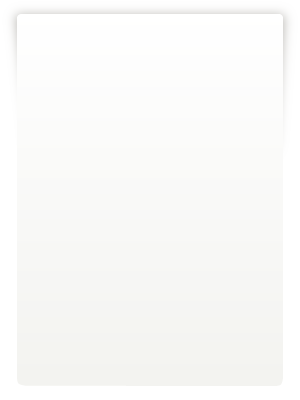
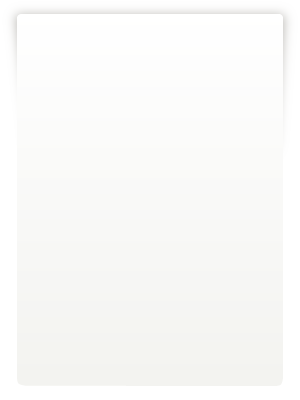
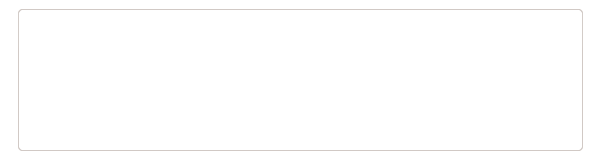
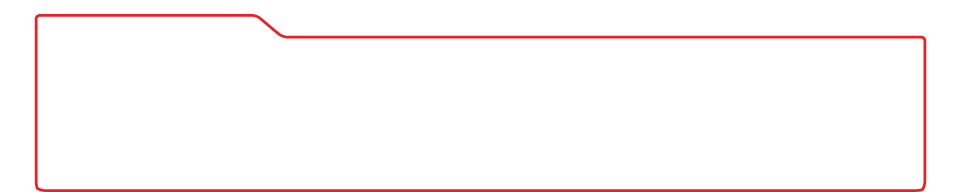
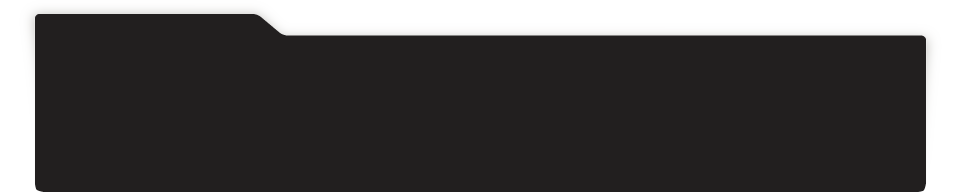
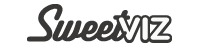
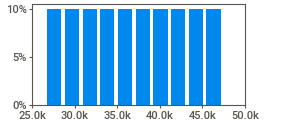
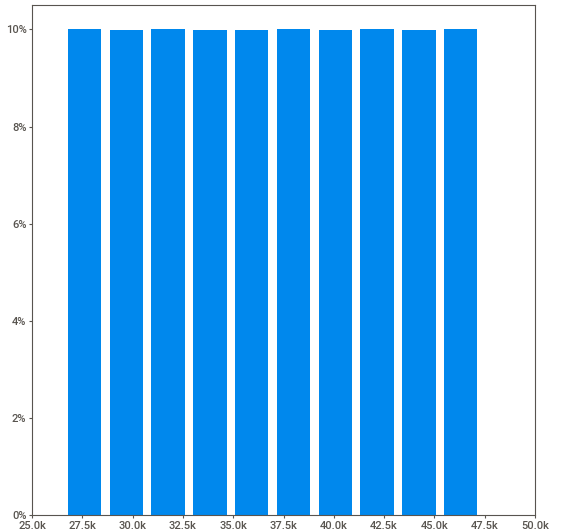
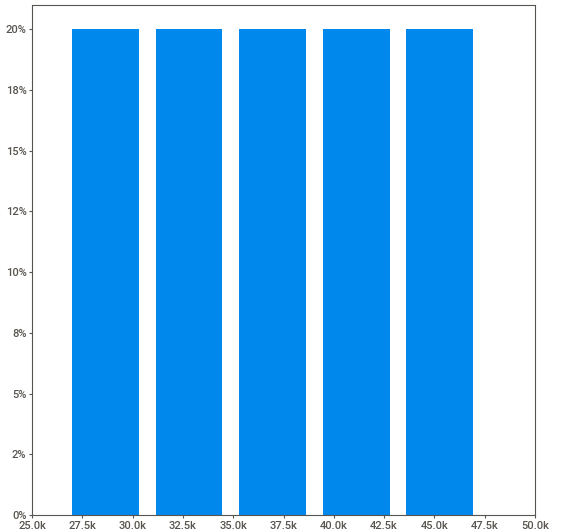
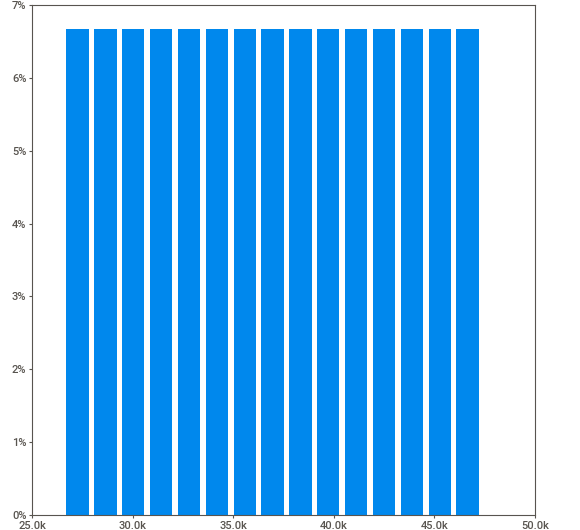
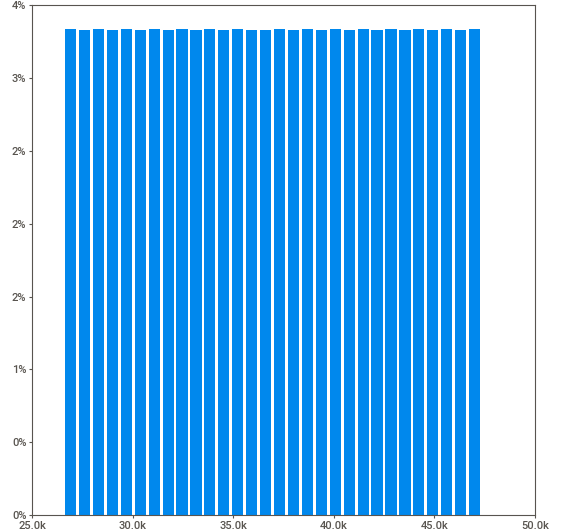
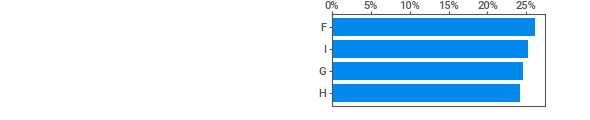
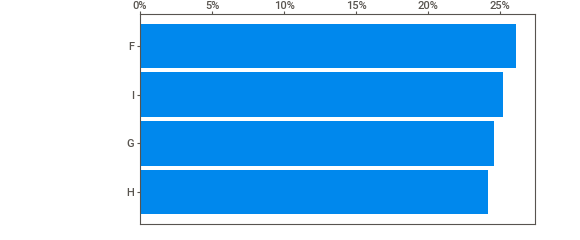
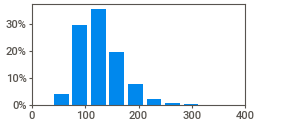
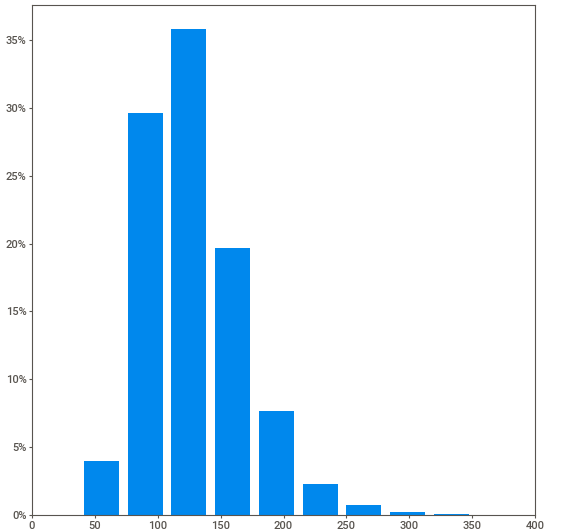
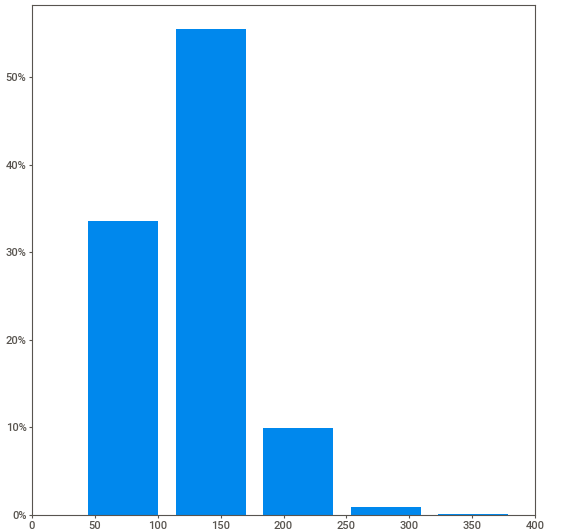
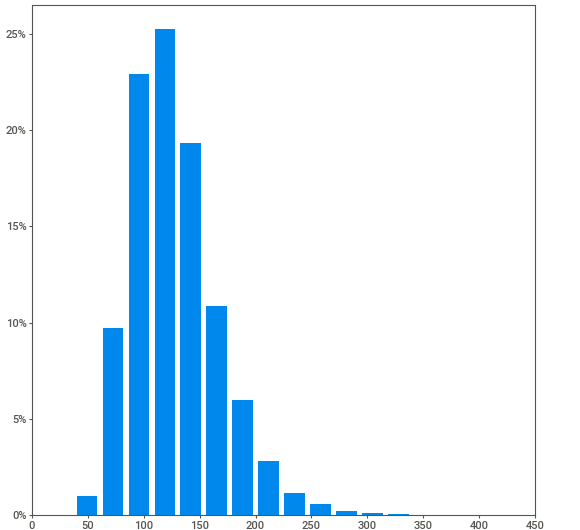
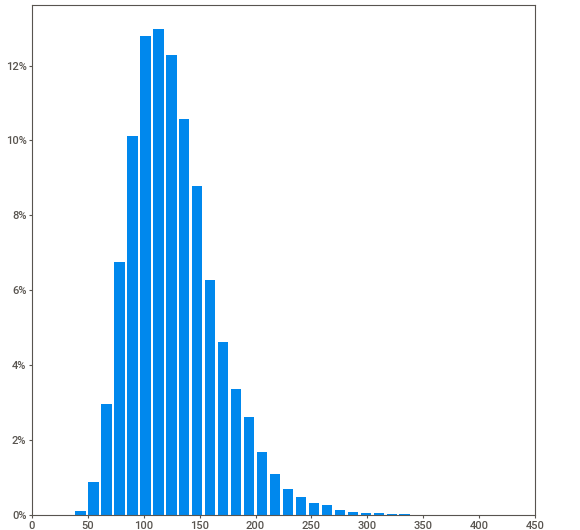
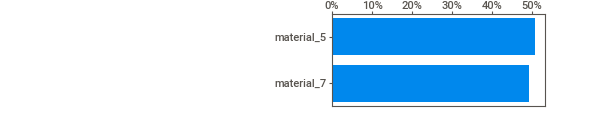
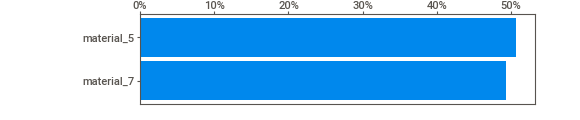
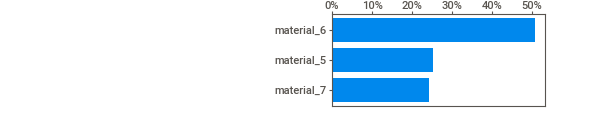
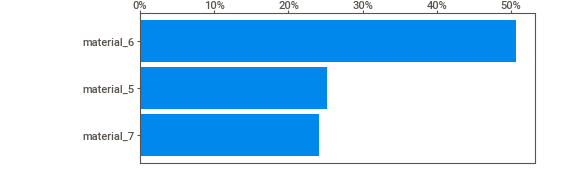
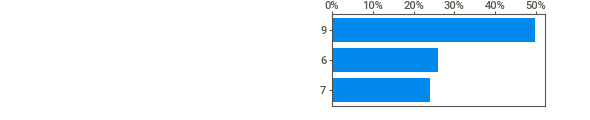
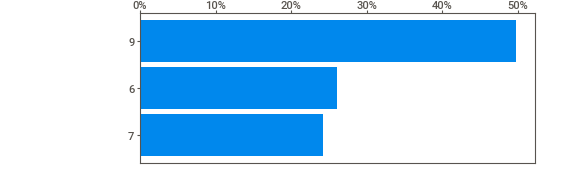
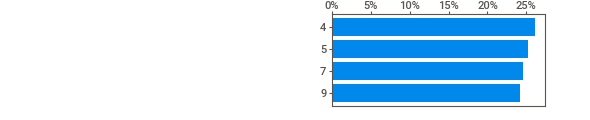
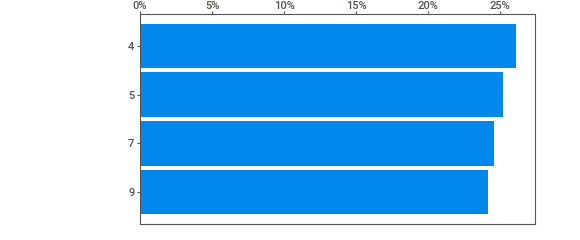
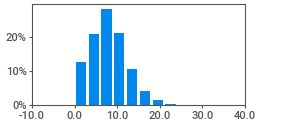
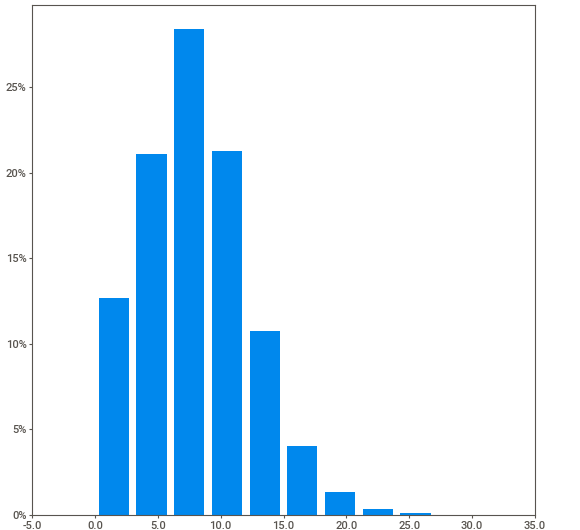
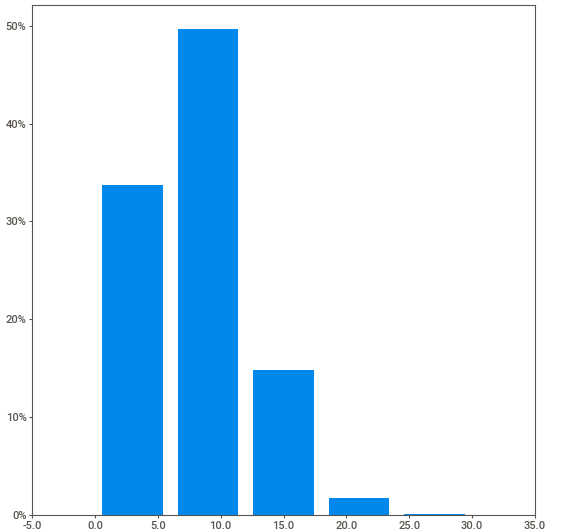
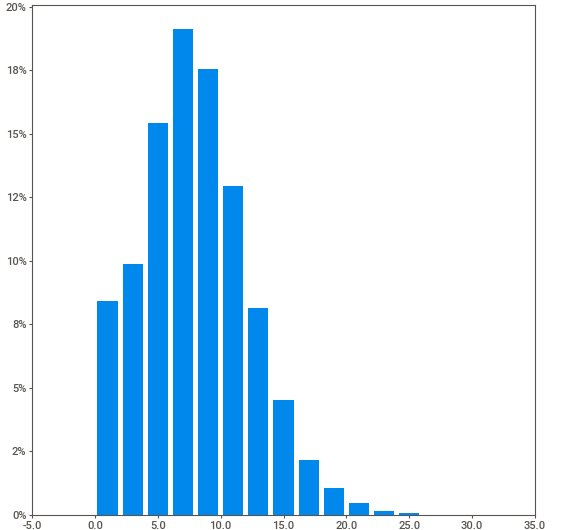
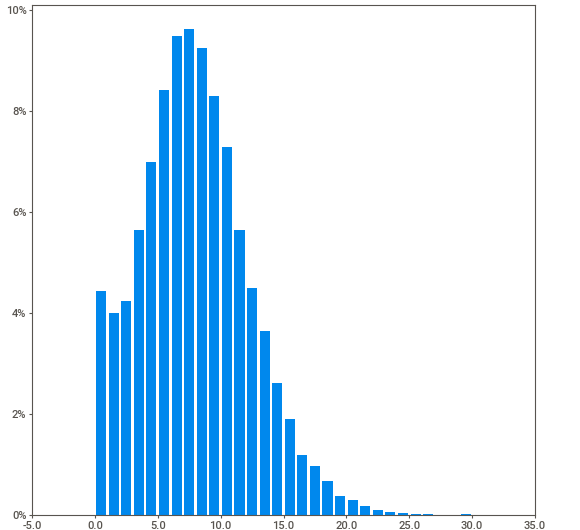
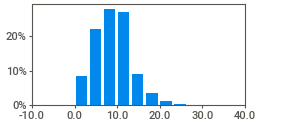
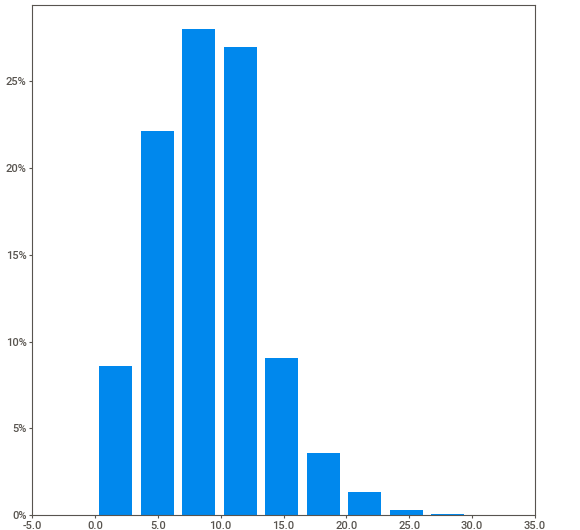
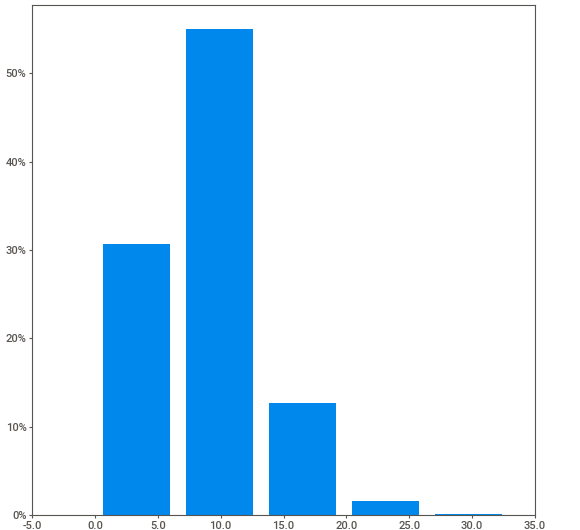
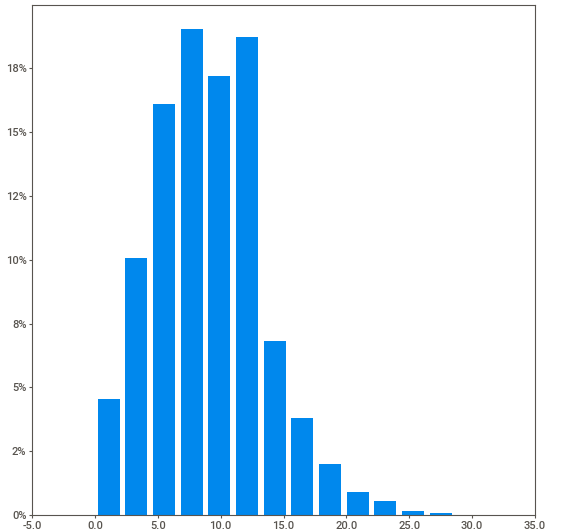
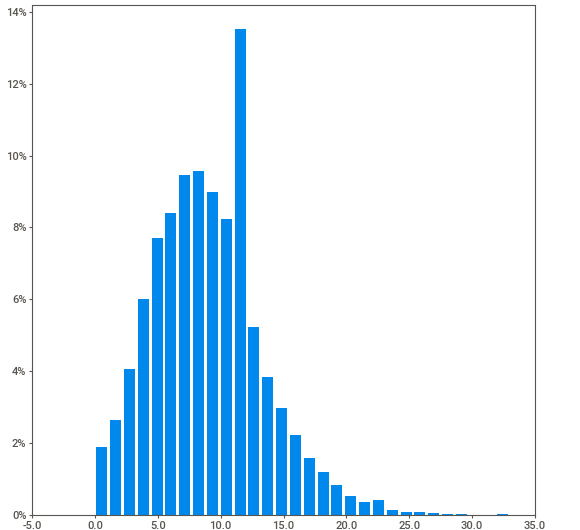
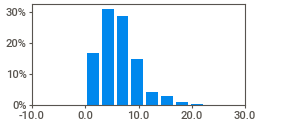
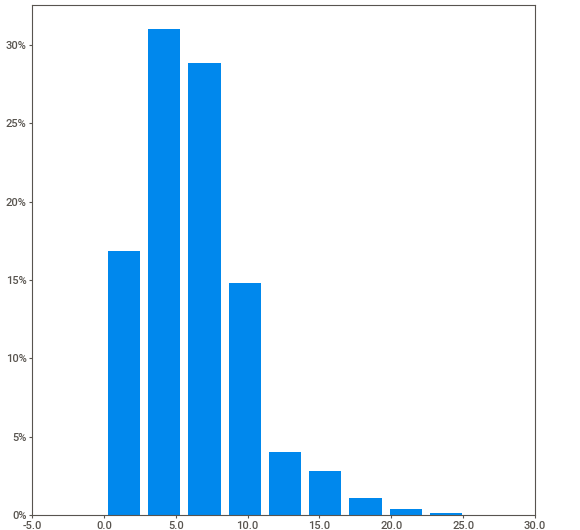
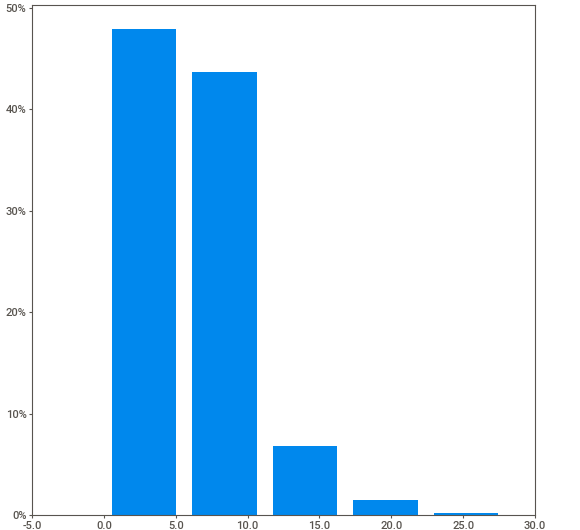
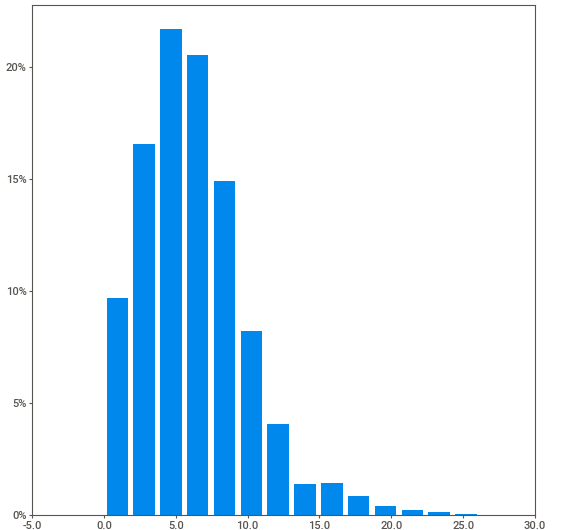
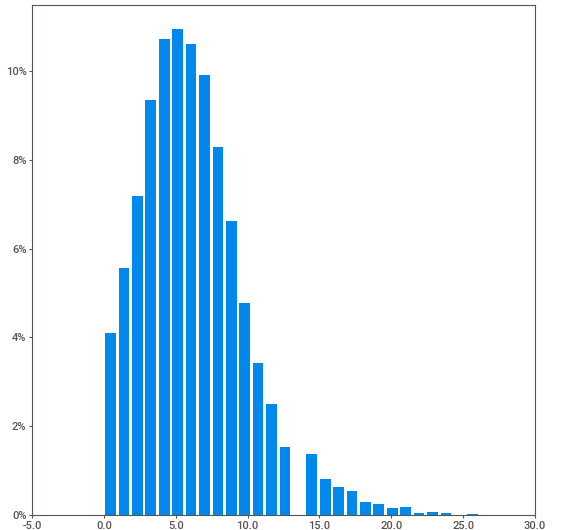
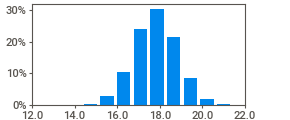
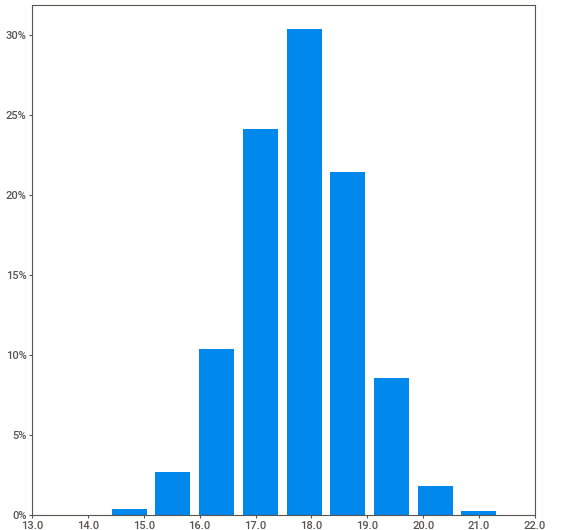
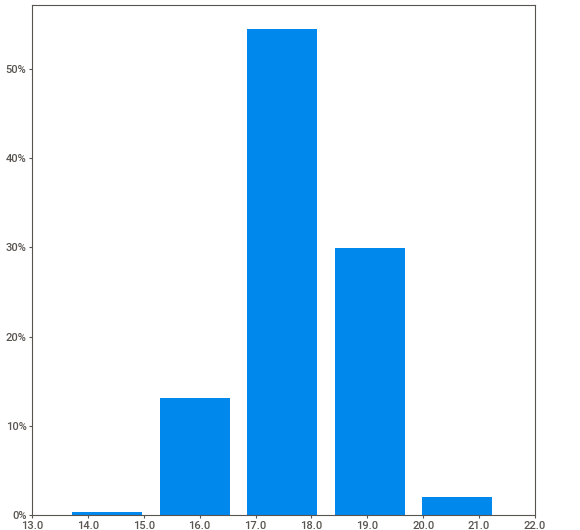
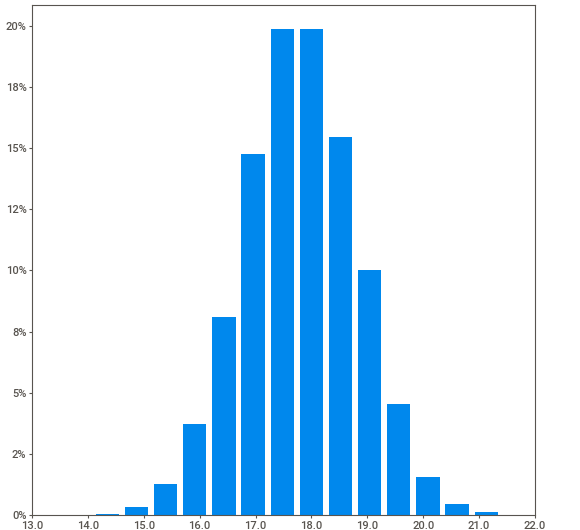
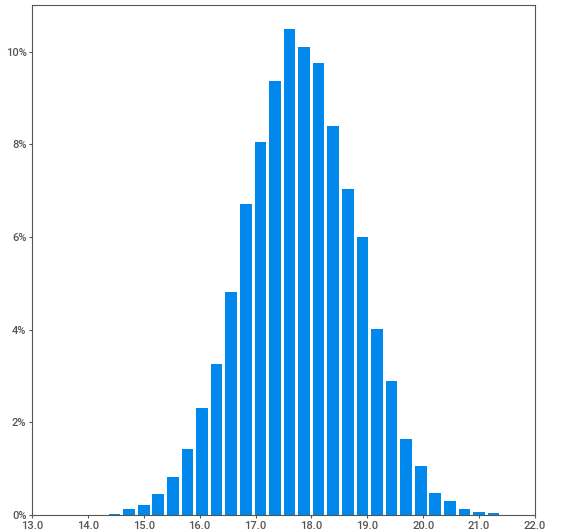
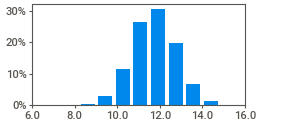
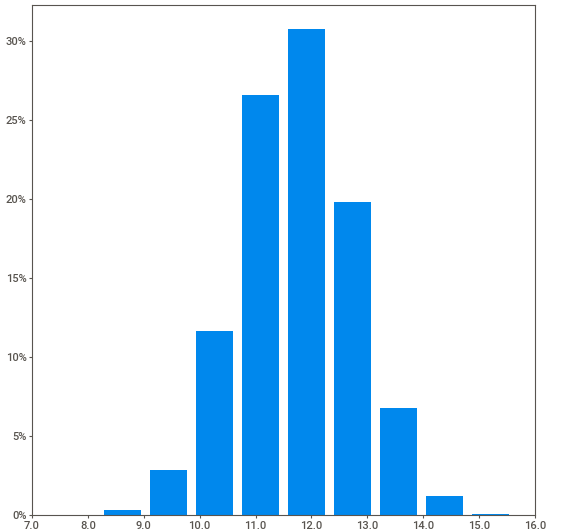
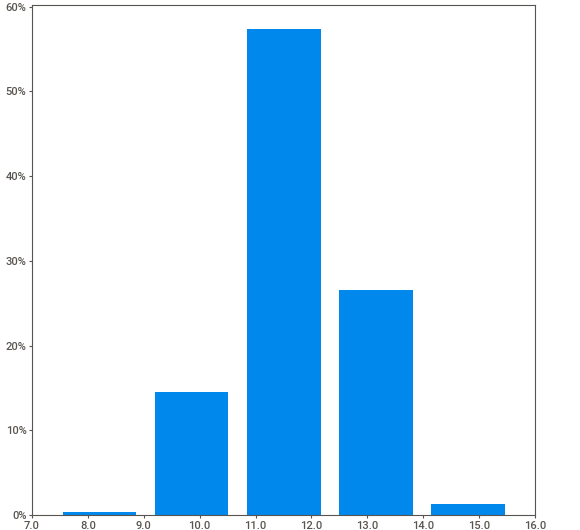
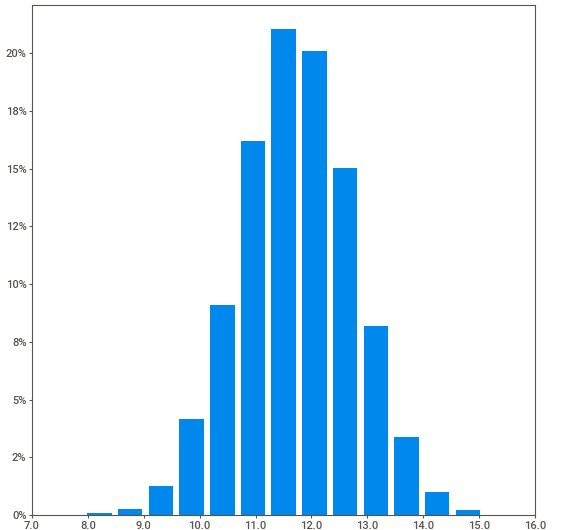
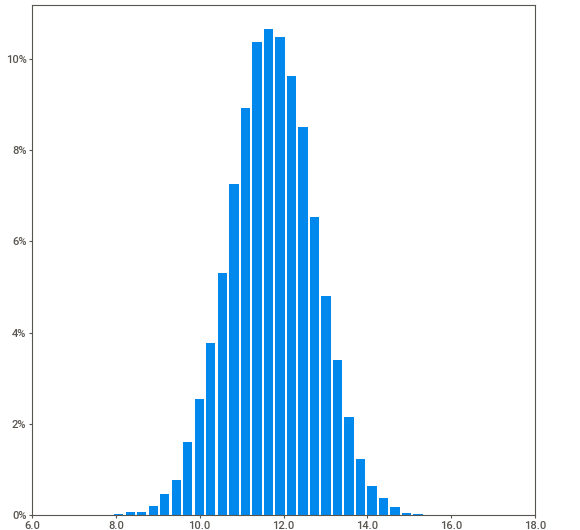
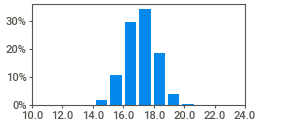
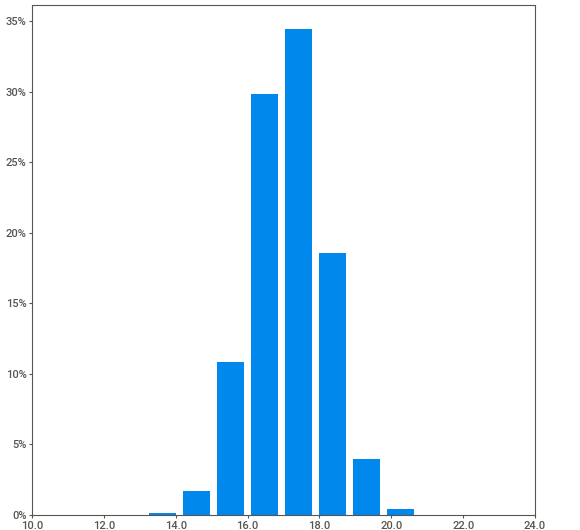
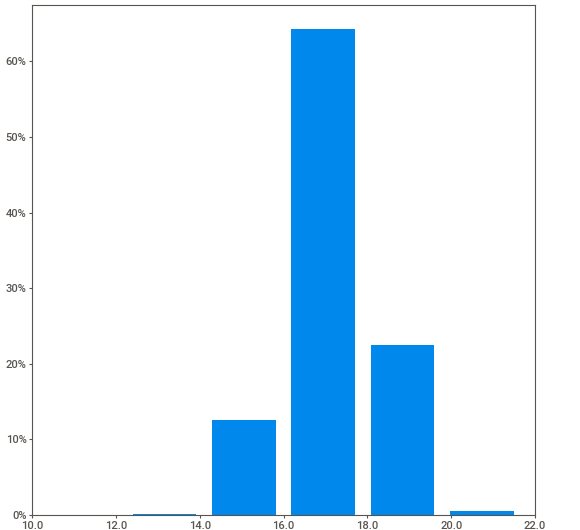
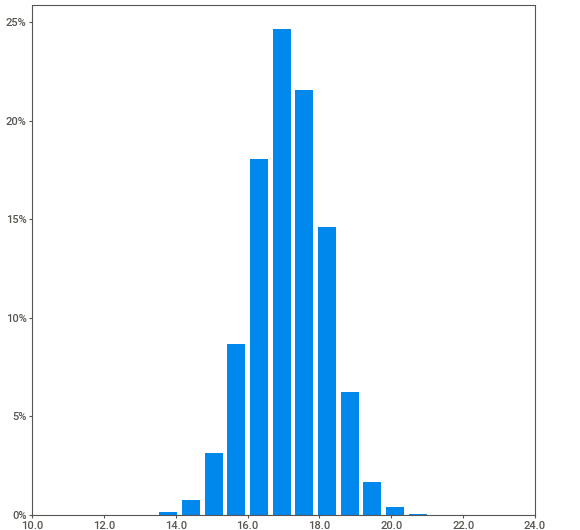
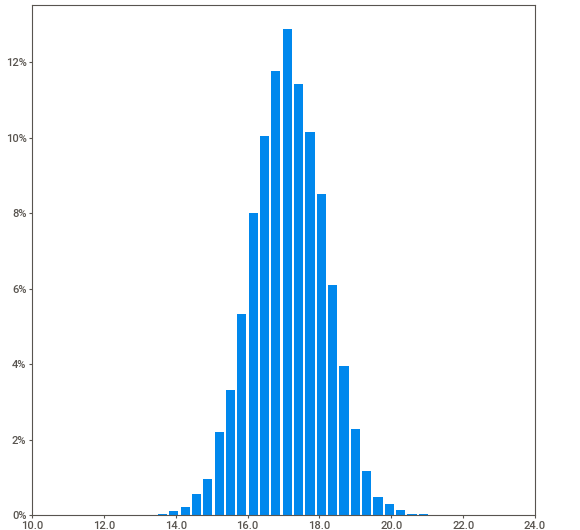
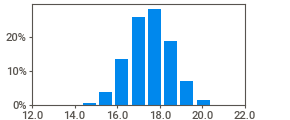
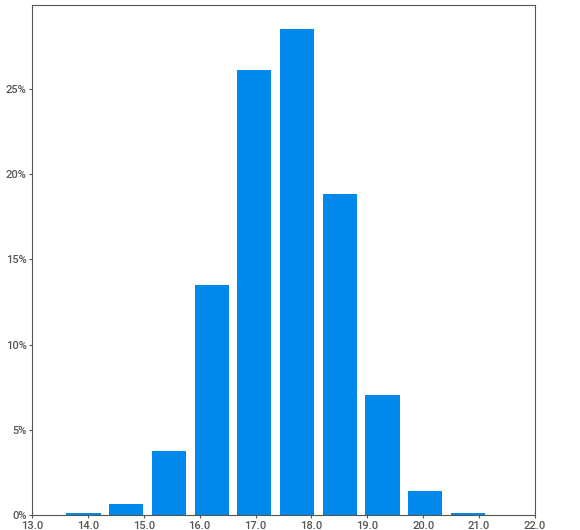
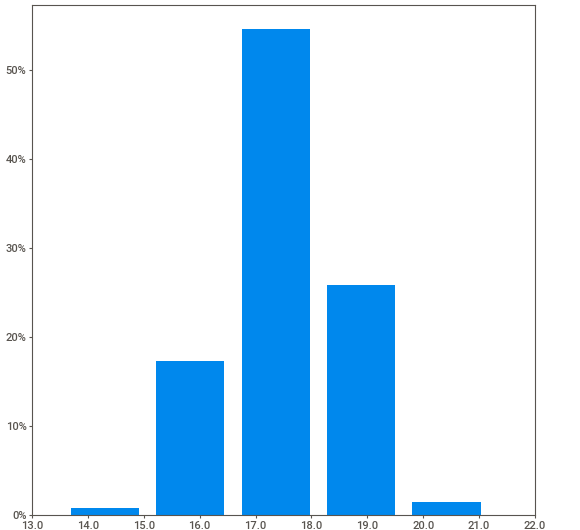
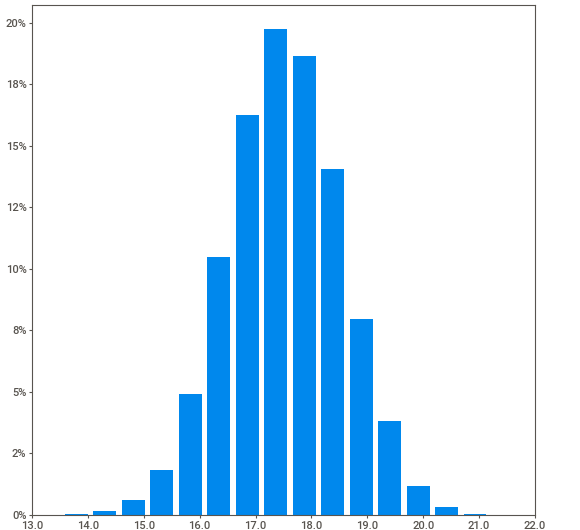
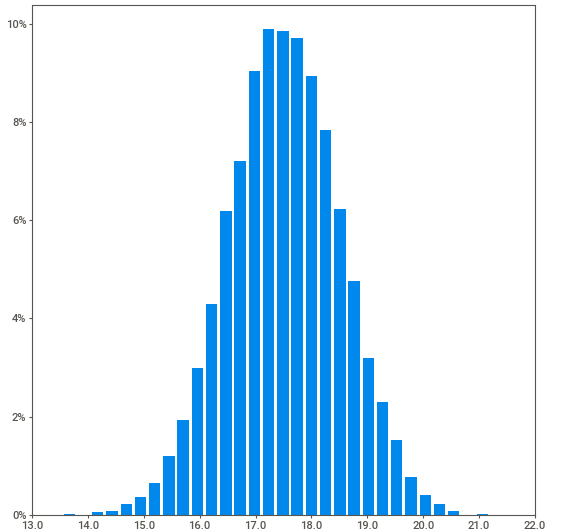
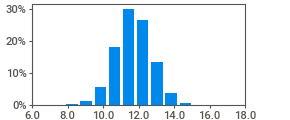
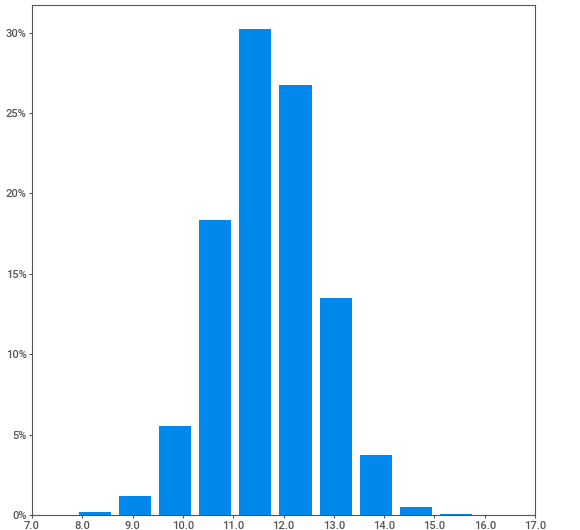
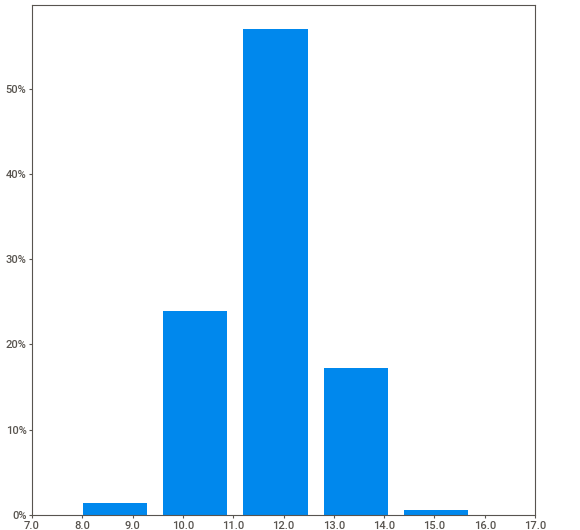
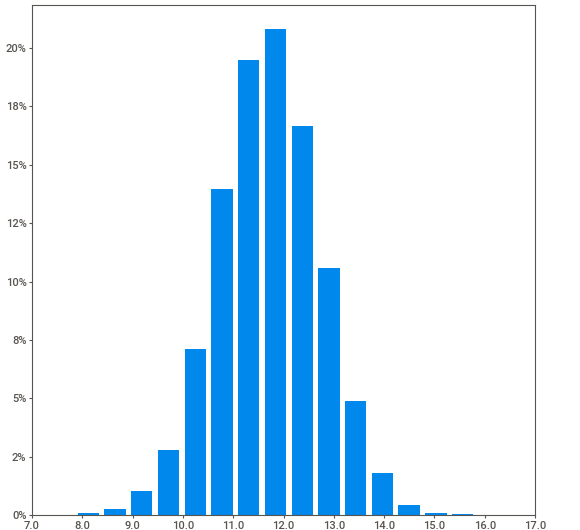
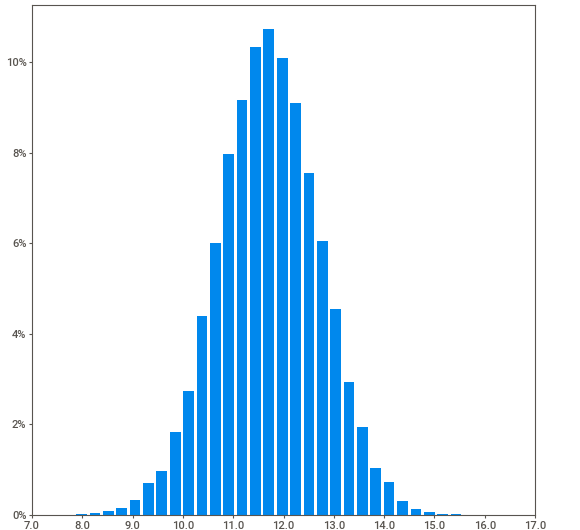
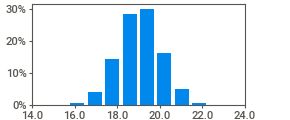
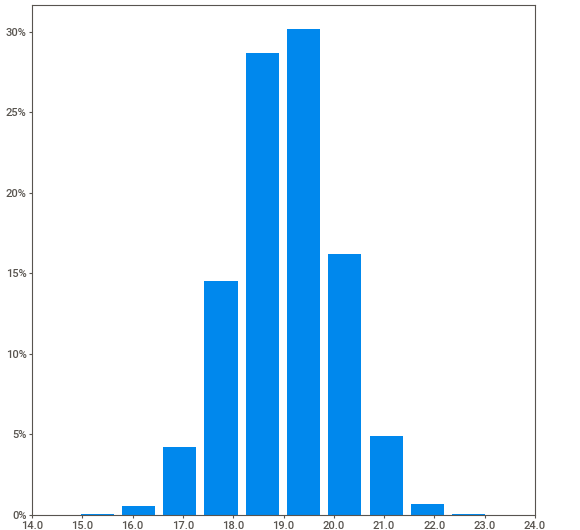
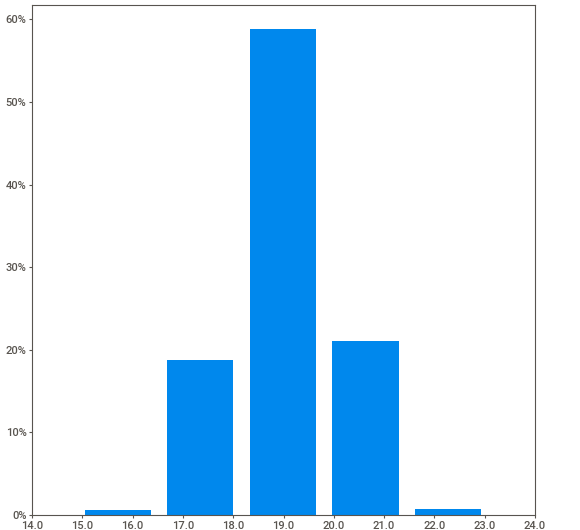
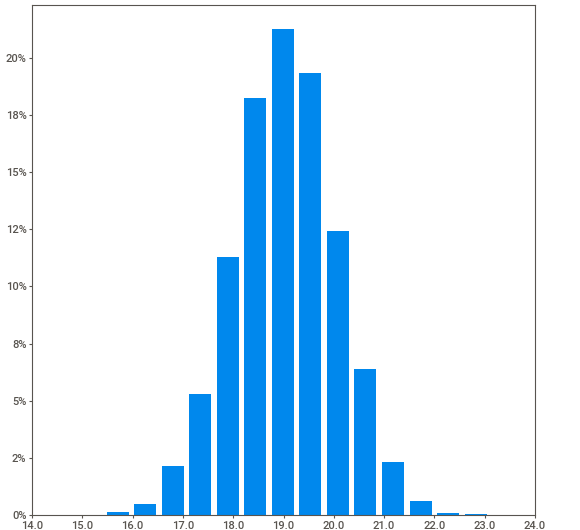
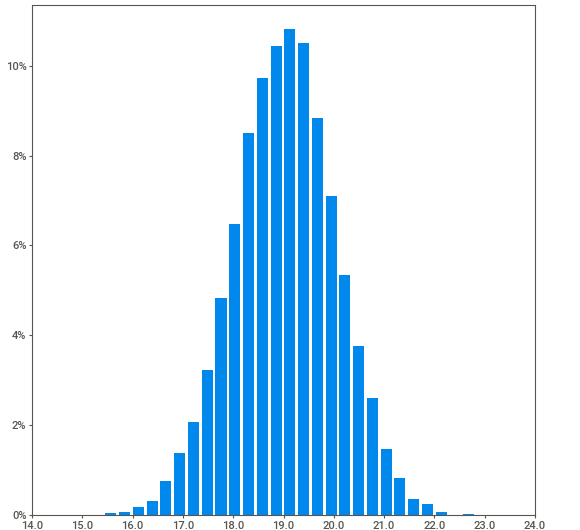
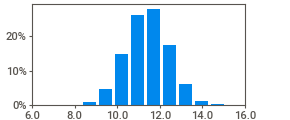
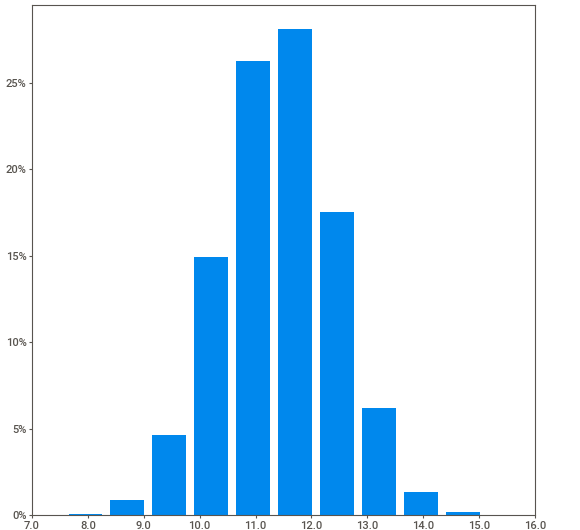
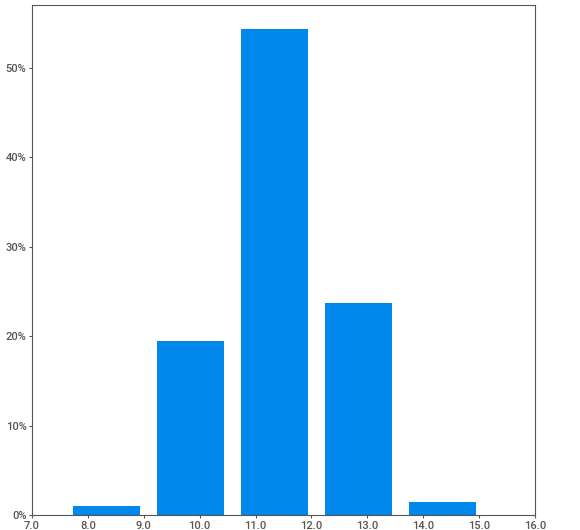
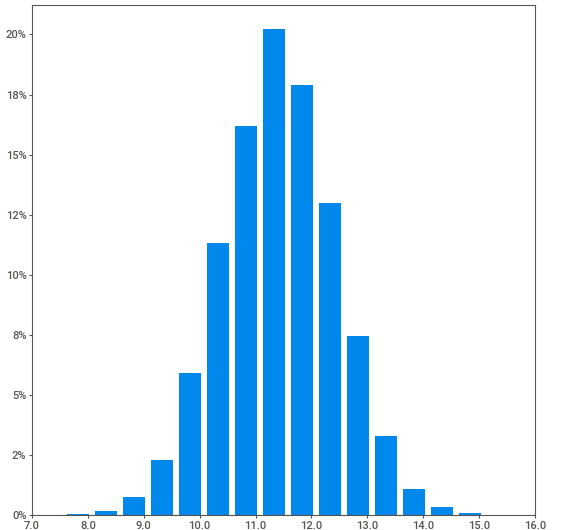
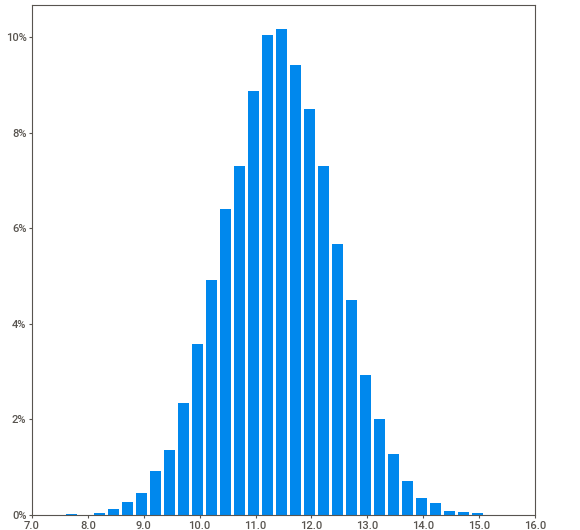
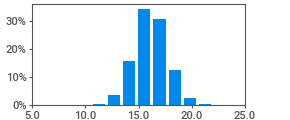
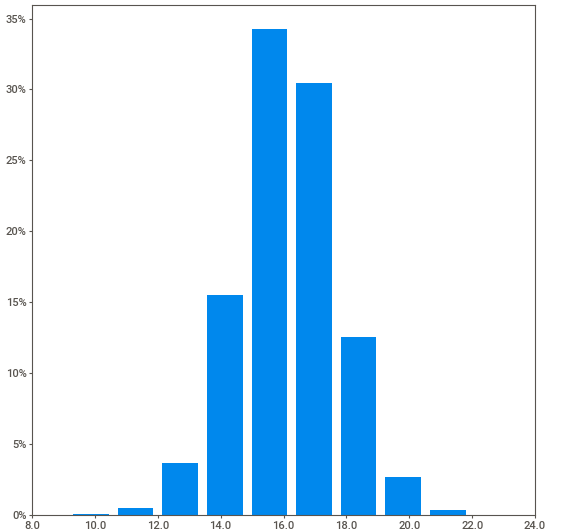
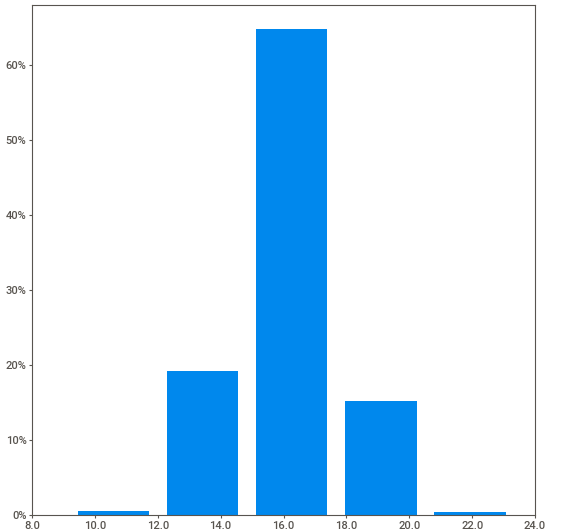
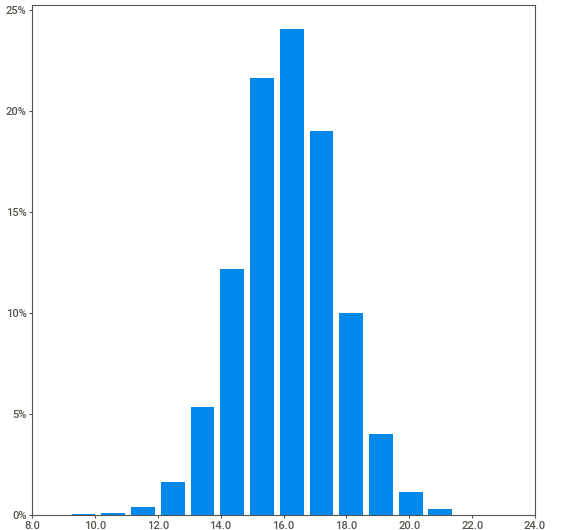
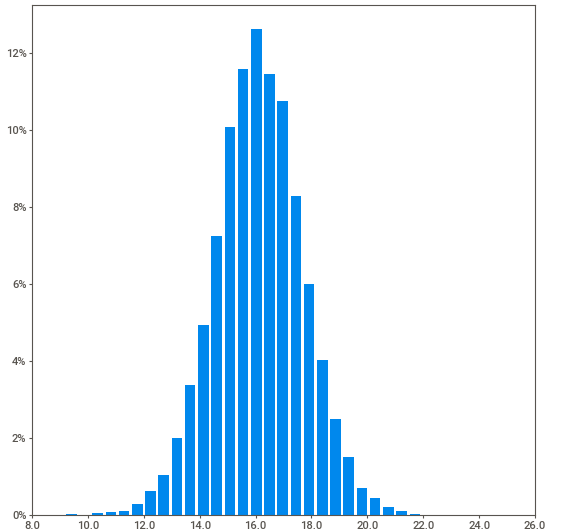
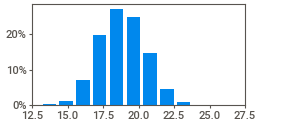
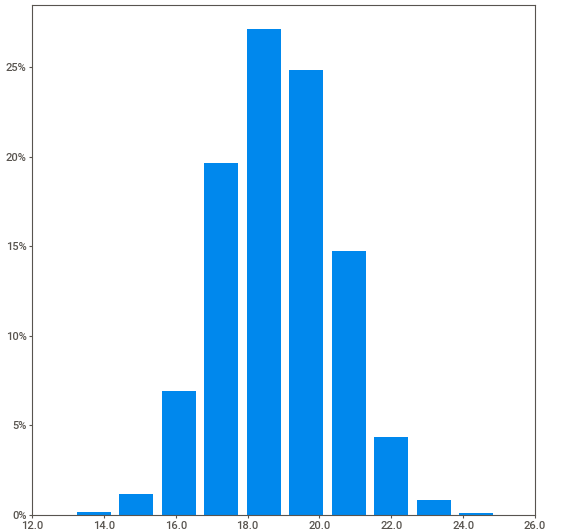
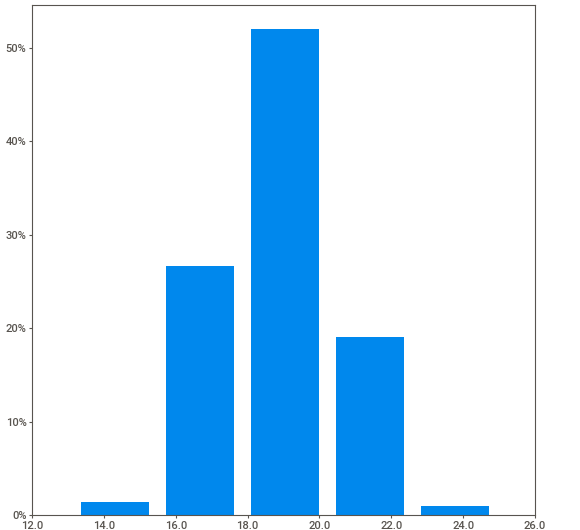
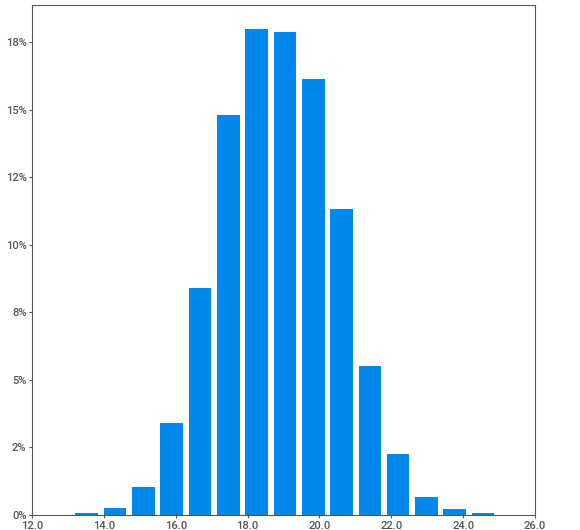
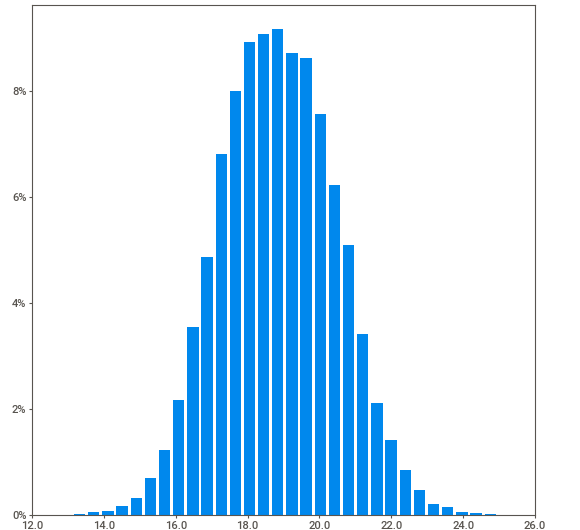
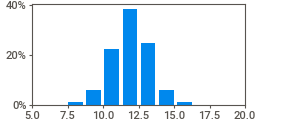
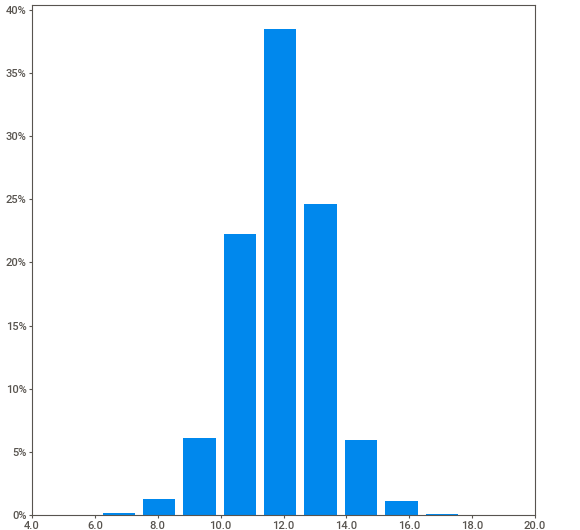
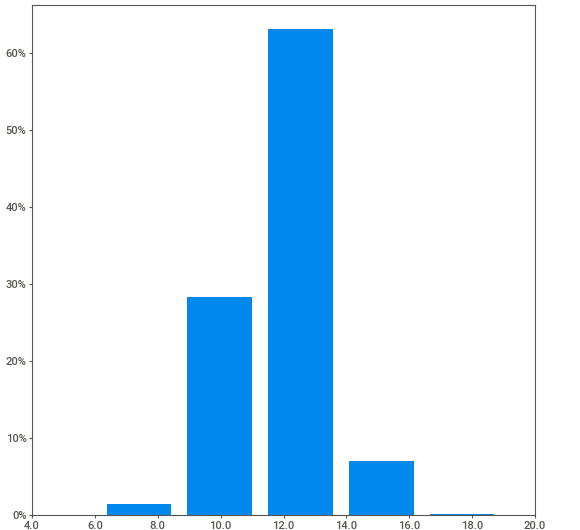
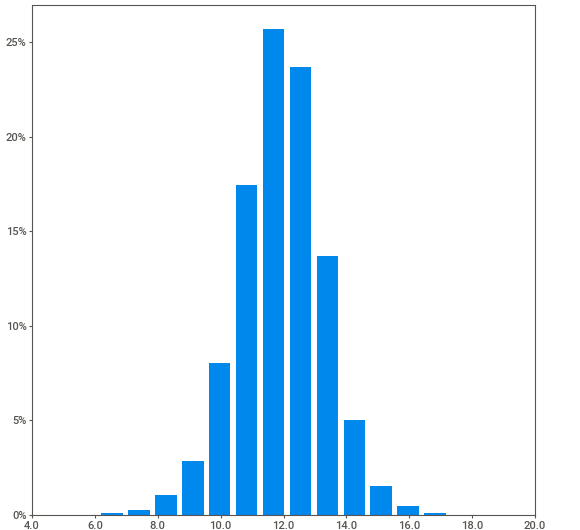
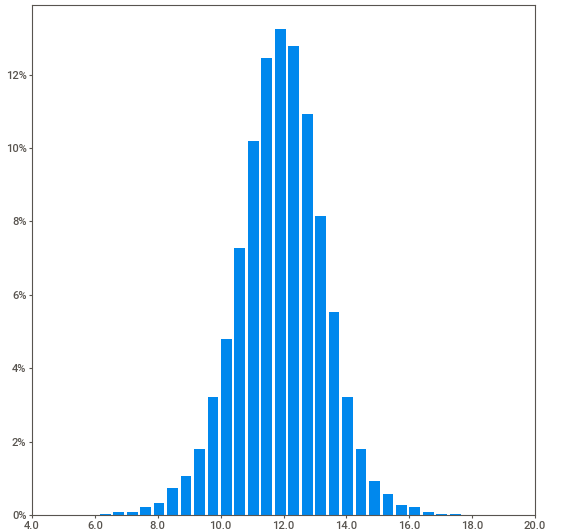
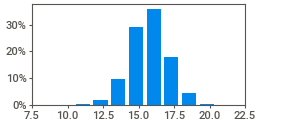
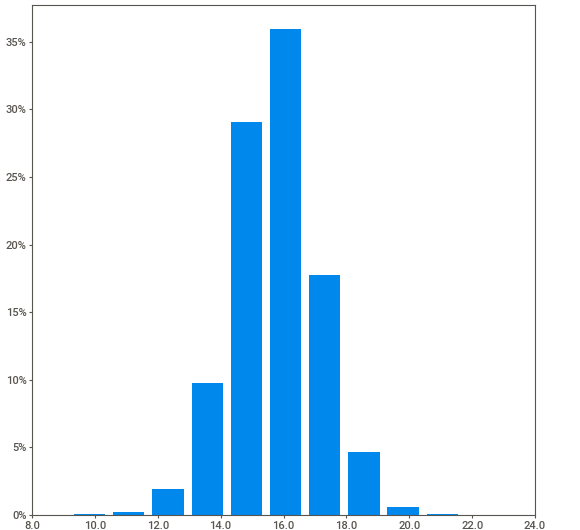
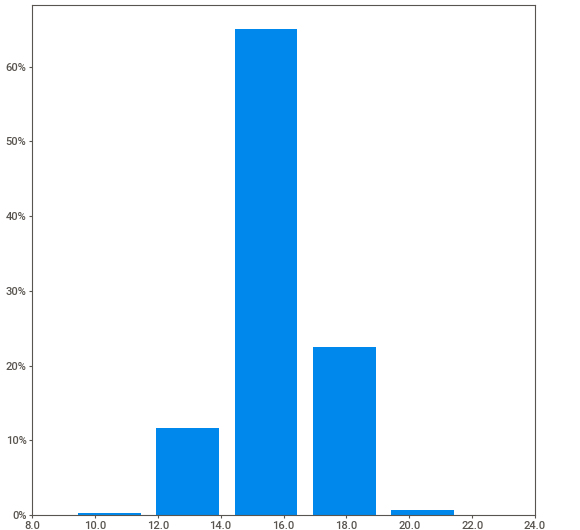
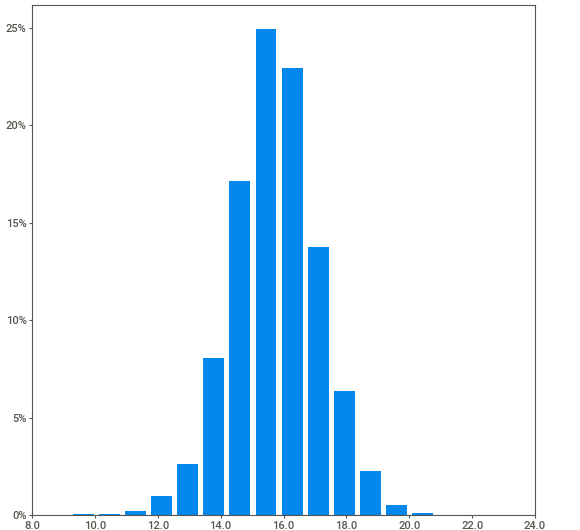
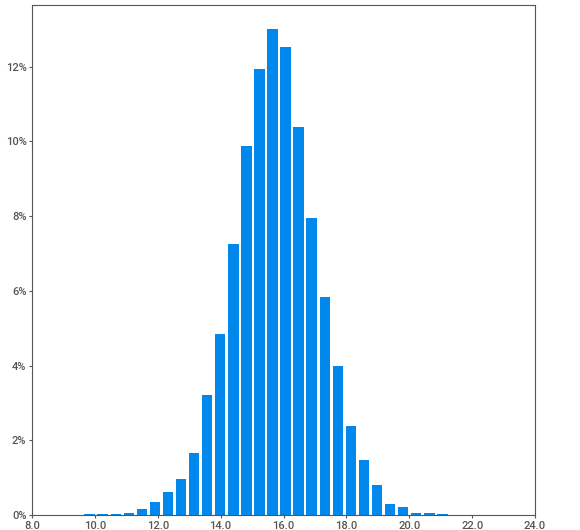
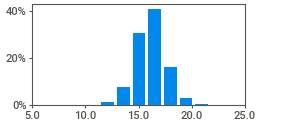
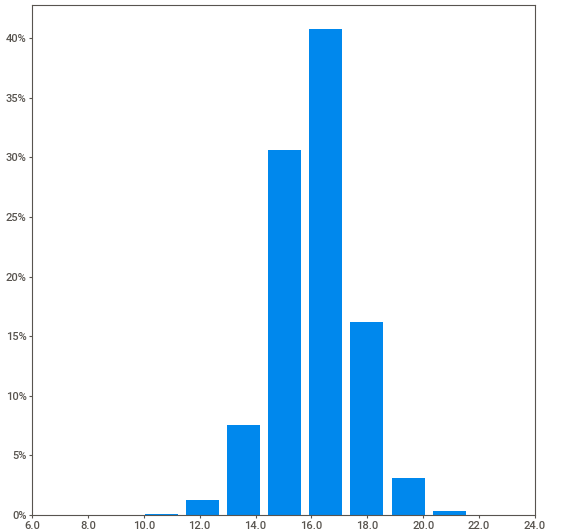
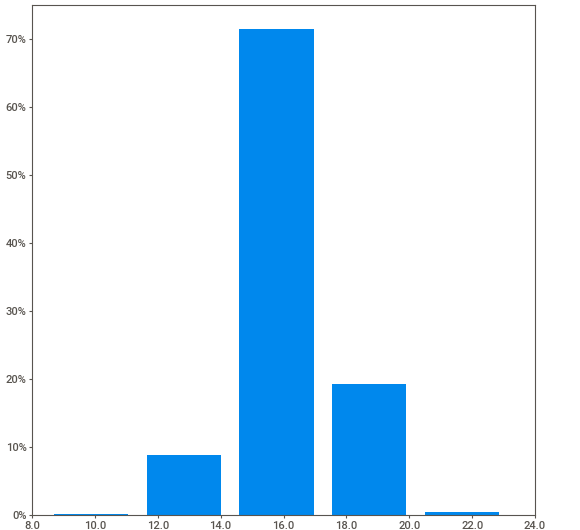
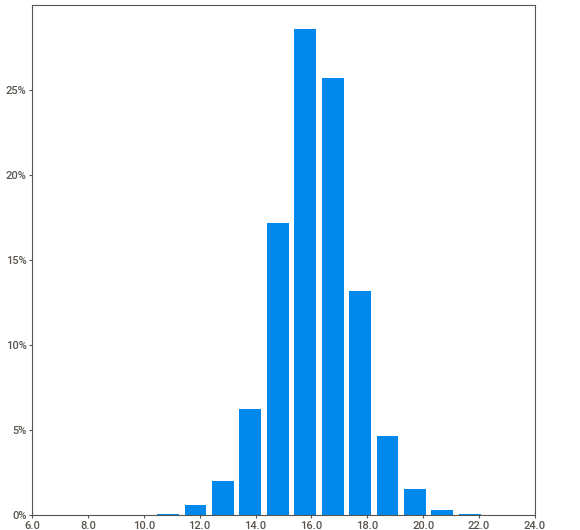
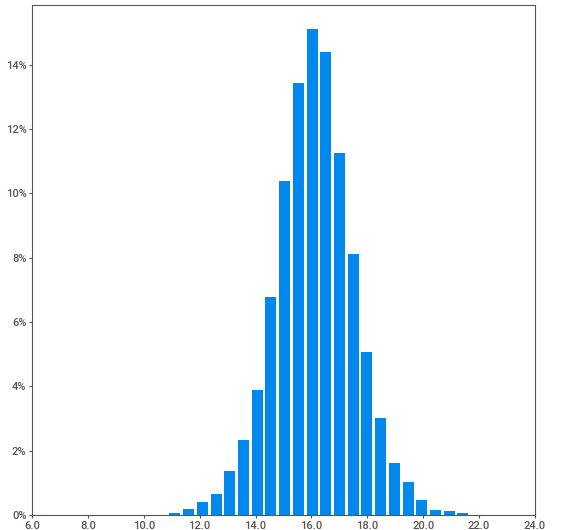
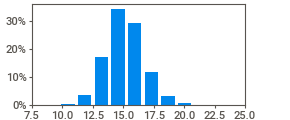
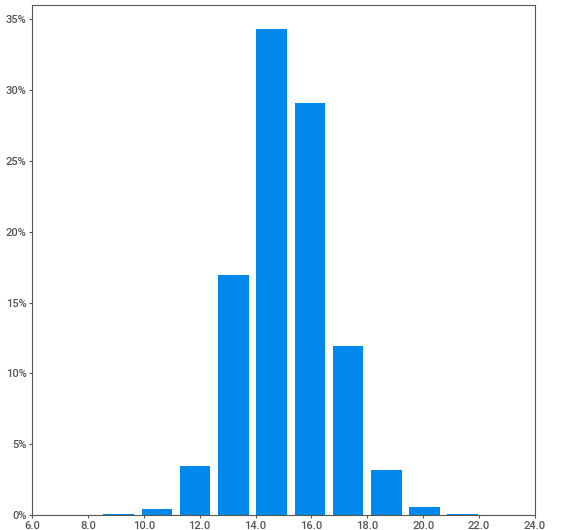
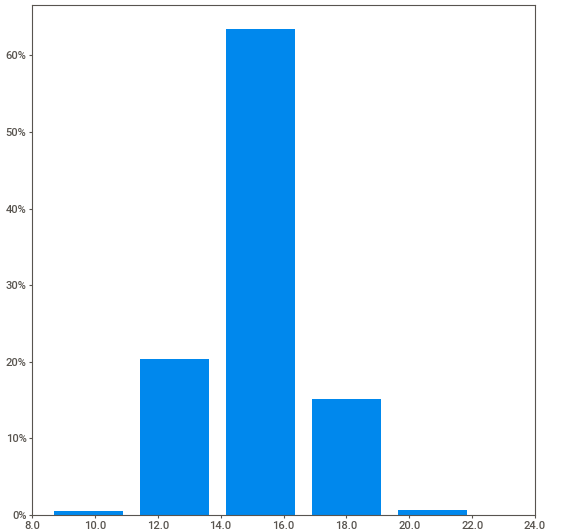
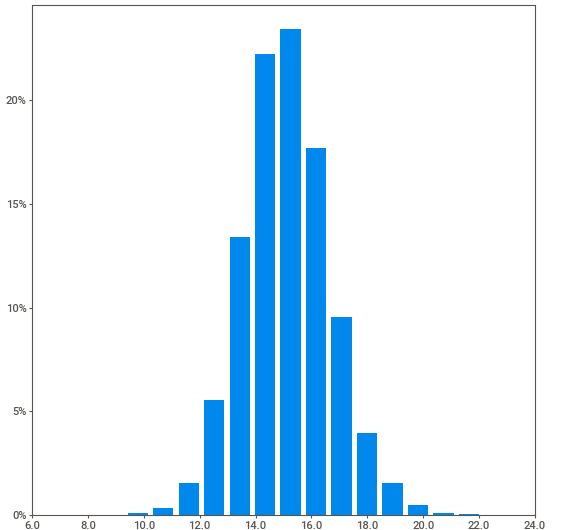
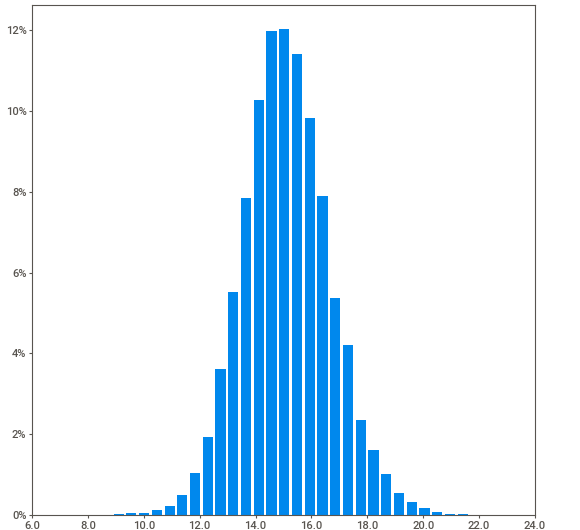
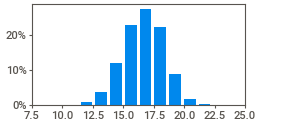
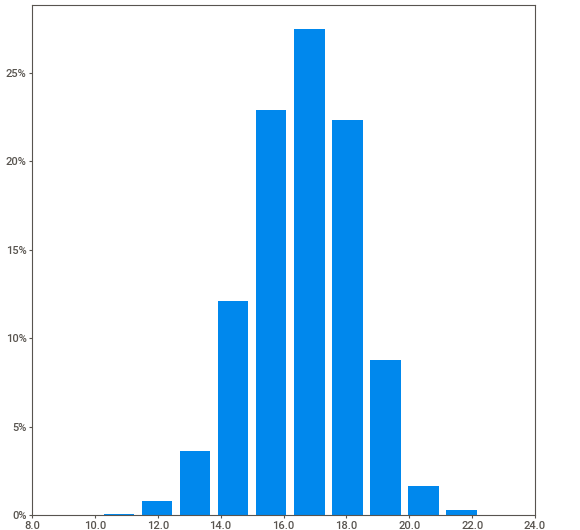
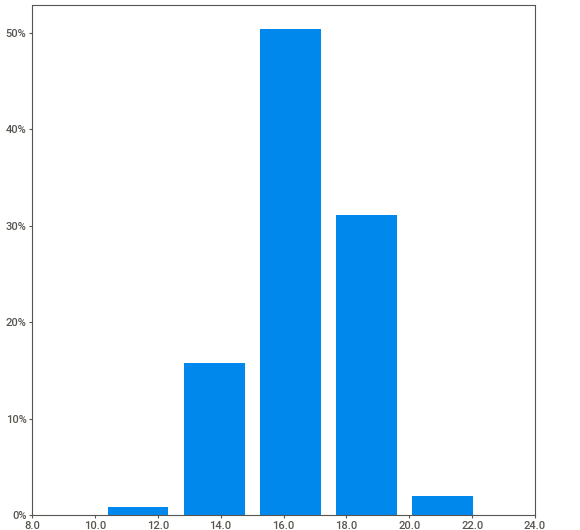
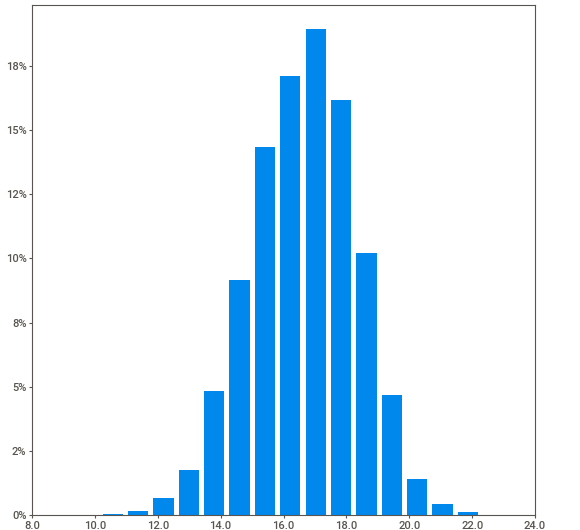
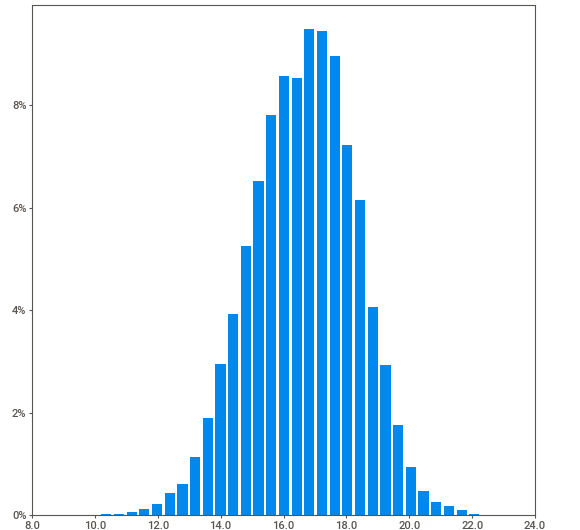
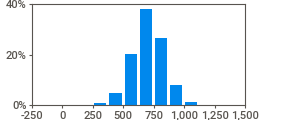
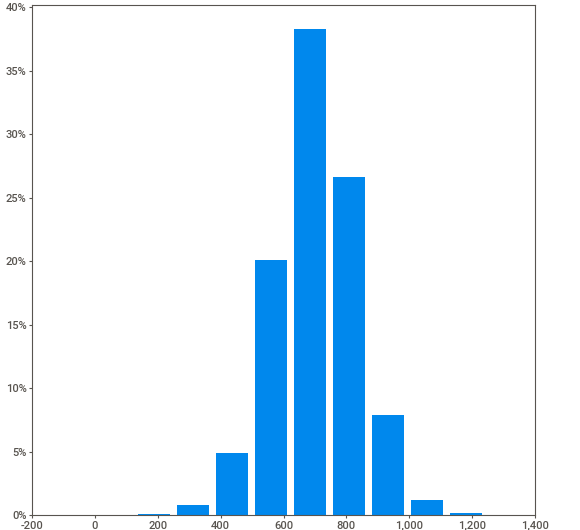
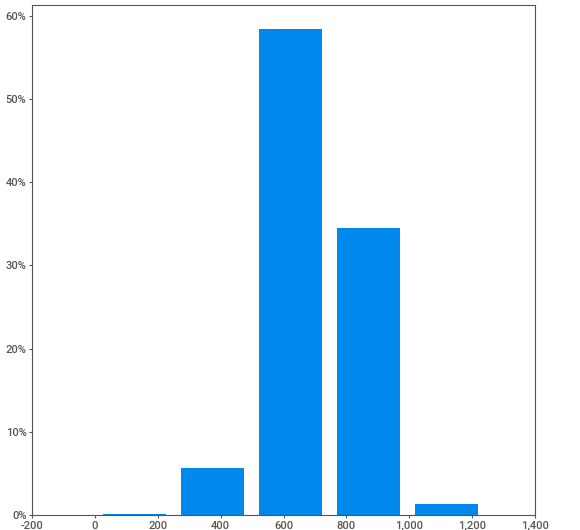
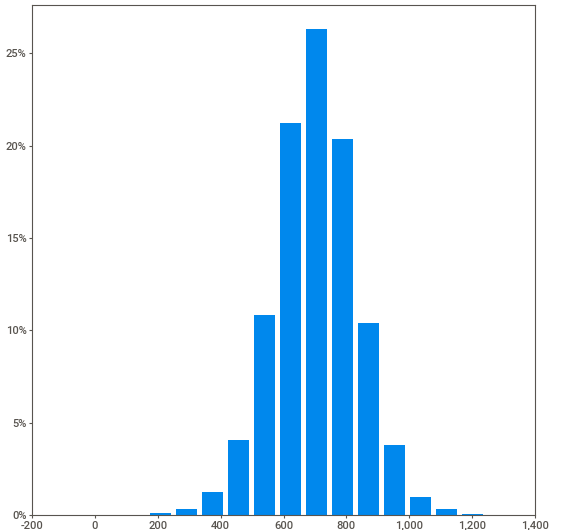
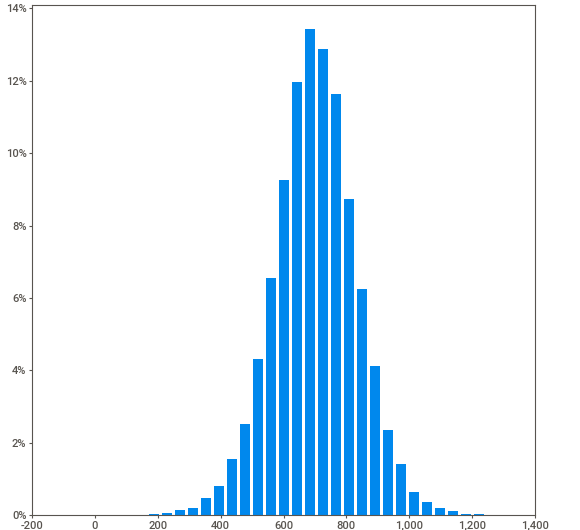
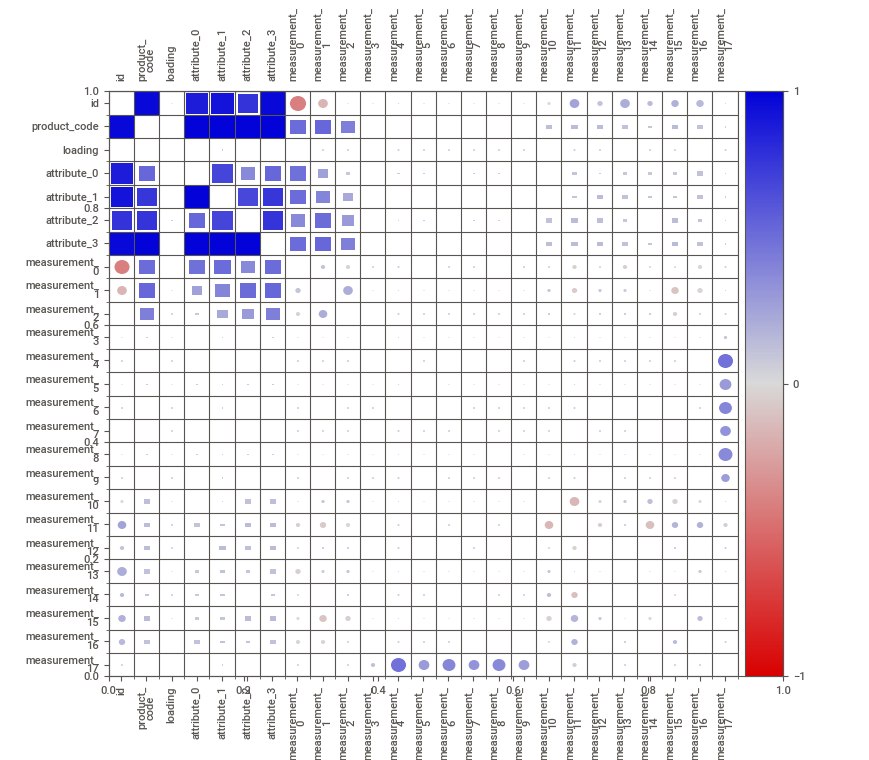
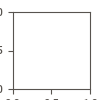

In [5]:
test_report = sv.analyze(test)
test_report.show_notebook()

### Feature Importance


#### Target Shuffling

Motivated by the famous John Elder: <https://www.elderresearch.com/resource/innovations/target-shuffling-process/>

Algorithm:

1. Shuffle every feature many times (e.g., 100 or 1000)
2. Compare the correlation and AUC of the real feature to the many copies
3. Calculate the pseudo-p-value, representing likelihood we'd see this big of a relationship if it was from chance alone.

For speed, we will shuffle the entire dataset all at once.

In [6]:
def correlation(y_true, y_pred):
    # helper function
    return pd.concat([y_true, y_pred], axis=1).corr().iloc[0, 1]

In [7]:
num_cols = [
    col
    for col in train.select_dtypes(np.number).columns
    if col not in ["id", "failure"]
]
rng = np.random.default_rng(5)
n = 100

met_funcs = [correlation, roc_auc_score]
train_num = train[num_cols].copy()
row_list = []
for i in range(n + 1):
    if i == 0:
        tmp = train_num.copy()
    else:
        tmp = train_num.sample(frac=1.0, replace=False, random_state=i)
    tmp["failure"] = train["failure"].to_numpy()
    for col in num_cols:
        mask = tmp[col].notna()
        for met in met_funcs:
            val = met(tmp.loc[mask, "failure"], tmp.loc[mask, col])
            row = {
                "metric": met.__name__,
                "score": val,
                "rs": i,
                "col": col,
            }
            row_list.append(row)
res = pd.DataFrame(row_list)
res


metric     score   rs             col
0       correlation  0.129089    0         loading
1     roc_auc_score  0.587946    0         loading
2       correlation  0.006337    0     attribute_2
3     roc_auc_score  0.504359    0     attribute_2
4       correlation -0.019222    0     attribute_3
...             ...       ...  ...             ...
4237  roc_auc_score  0.496235  100  measurement_15
4238    correlation -0.002397  100  measurement_16
4239  roc_auc_score  0.499209  100  measurement_16
4240    correlation  0.004060  100  measurement_17
4241  roc_auc_score  0.503447  100  measurement_17

[4242 rows x 4 columns]

/var/folders/q4/w5_y95gj2f1b6y86756l_1fw0000gn/T/ipykernel_71811/2140858853.py:9: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


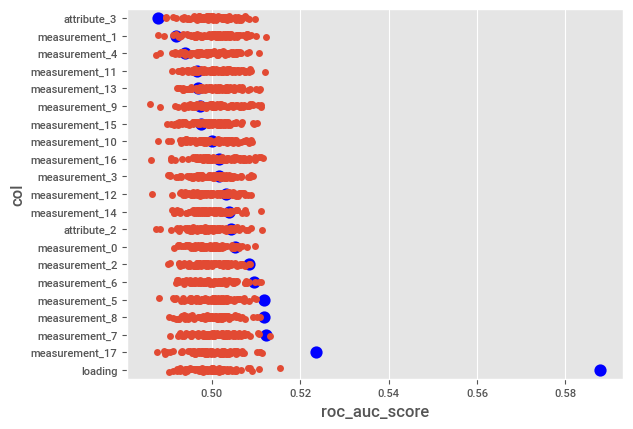

/var/folders/q4/w5_y95gj2f1b6y86756l_1fw0000gn/T/ipykernel_71811/2140858853.py:9: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


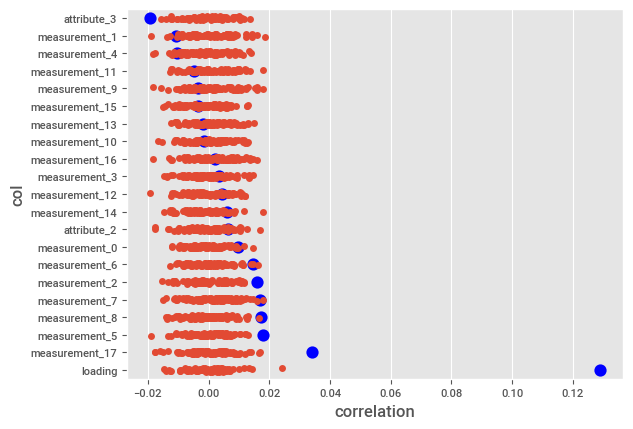

In [8]:
plt.style.use("ggplot")


for metric in ["roc_auc_score", "correlation"]:
    fig, ax = plt.subplots()
    order = res.loc[(res.rs == 0) & (res.metric == metric)].sort_values(
        "score"
    )["col"]
    sns.pointplot(
        data=res[(res.rs == 0) & (res.metric == metric)],
        x="score",
        y="col",
        order=order,
        join=False,
        color="blue",
    )
    sns.stripplot(
        data=res[(res.rs > 0) & (res.metric == metric)],
        x="score",
        y="col",
        order=order,
    )
    ax.set_xlabel(metric)
    plt.show()


Takeaways from this investigation:

* `measurement_17` contains signal
* `attribute_3` is slightly better than random
* measurements 2, 5, 7, 8 are borderline

We want at least `loading`, `measurement_17`, and probably `attribute_3` in our model.

#### Loading Missingness

There is some indication in the data that the dataset is different when `loading` is missing, most definitively shown in the plot below with `attribute_3`. I will repeat the above feature selection analysis when loading is missing to make sure there's nothing we're missing.


/var/folders/q4/w5_y95gj2f1b6y86756l_1fw0000gn/T/ipykernel_71811/356808149.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


<Axes: xlabel='failure', ylabel='product_code'>

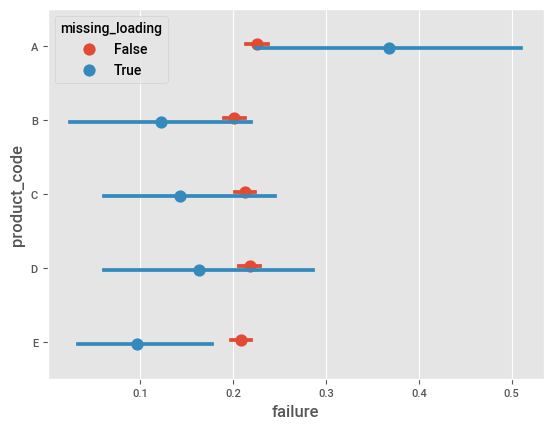

In [9]:
train["missing_loading"] = train.loading.isna().astype("category")
sns.pointplot(
    data=train,
    x="failure",
    y="product_code",
    hue="missing_loading",
    dodge=True,
    join=False,
)


In [10]:
n = 100
num_cols = [
    col
    for col in train.select_dtypes(np.number).columns
    if col not in ["id", "failure"]
]

met_funcs = [correlation, roc_auc_score]
train_num = train.loc[train.loading.isna(), num_cols].copy()


row_list = []
for i in range(n + 1):
    if i == 0:
        tmp = train_num.copy()
    else:
        tmp = train_num.sample(frac=1.0, replace=False, random_state=i)
    tmp["failure"] = train.loc[train.loading.isna(), "failure"].to_numpy()
    for col in num_cols:
        mask = tmp[col].notna()
        if mask.sum() == 0:
            continue
        for met in met_funcs:
            val = met(tmp.loc[mask, "failure"], tmp.loc[mask, col])
            row = {
                "metric": met.__name__,
                "score": val,
                "rs": i,
                "col": col,
            }
            row_list.append(row)
    if i == 0:
        train_num_saved = tmp.copy()
res = pd.DataFrame(row_list)
res


metric     score   rs             col
0       correlation  0.183629    0     attribute_2
1     roc_auc_score  0.620918    0     attribute_2
2       correlation -0.222120    0     attribute_3
3     roc_auc_score  0.341019    0     attribute_3
4       correlation  0.115373    0   measurement_0
...             ...       ...  ...             ...
4035  roc_auc_score  0.422072  100  measurement_15
4036    correlation  0.026197  100  measurement_16
4037  roc_auc_score  0.511971  100  measurement_16
4038    correlation  0.093905  100  measurement_17
4039  roc_auc_score  0.561528  100  measurement_17

[4040 rows x 4 columns]

/var/folders/q4/w5_y95gj2f1b6y86756l_1fw0000gn/T/ipykernel_71811/938126059.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


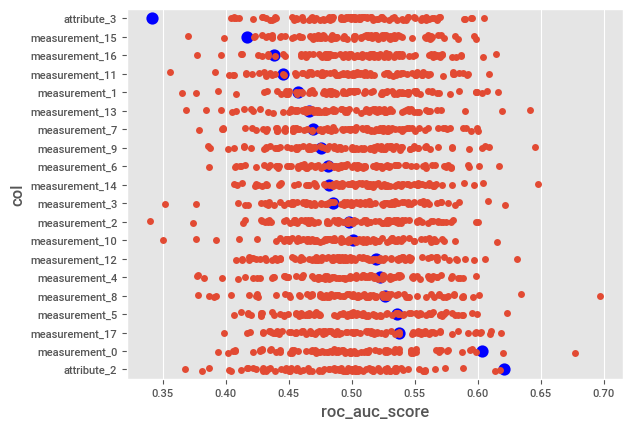

/var/folders/q4/w5_y95gj2f1b6y86756l_1fw0000gn/T/ipykernel_71811/938126059.py:6: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


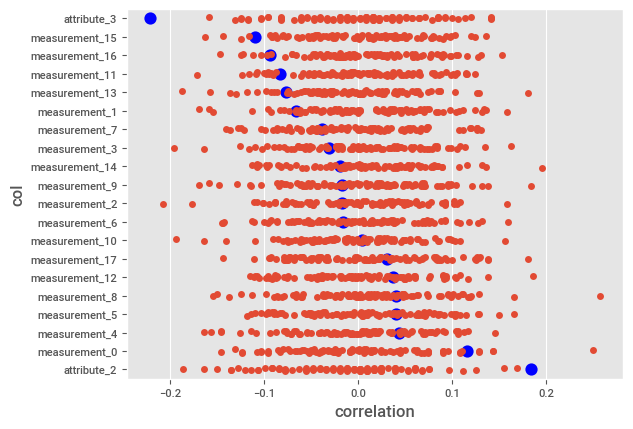

In [11]:
for metric in ["roc_auc_score", "correlation"]:
    fig, ax = plt.subplots()
    order = res.loc[(res.rs == 0) & (res.metric == metric)].sort_values(
        "score"
    )["col"]
    sns.pointplot(
        data=res[(res.rs == 0) & (res.metric == metric)],
        x="score",
        y="col",
        order=order,
        join=False,
        color="blue",
    )
    sns.stripplot(
        data=res[(res.rs > 0) & (res.metric == metric)],
        x="score",
        y="col",
        order=order,
    )
    ax.set_xlabel(metric)
    plt.show()


Both attributes 2 and 3 have a key relationship when loading is missing. This indicates having a "backup" model might be helpful.

We can use sweetviz to see if the relationship holds across all attributes, and when we treat them as categorical.

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



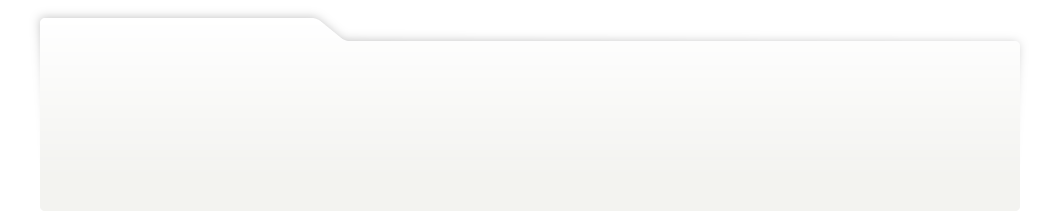
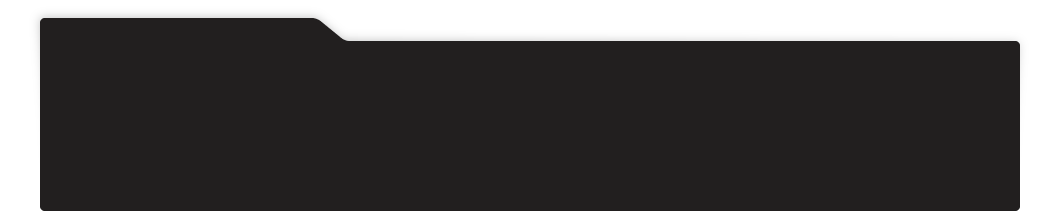
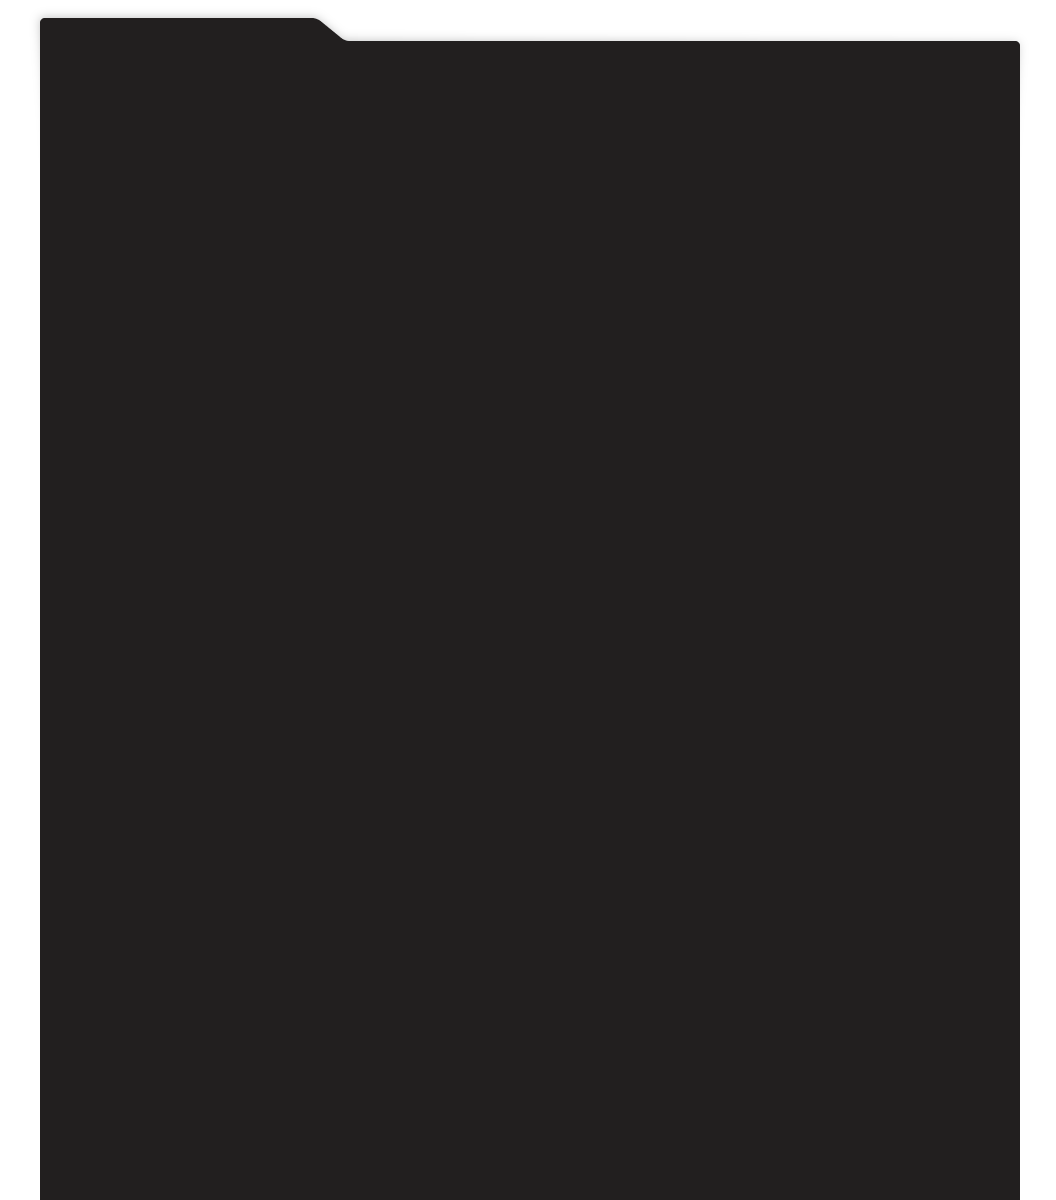
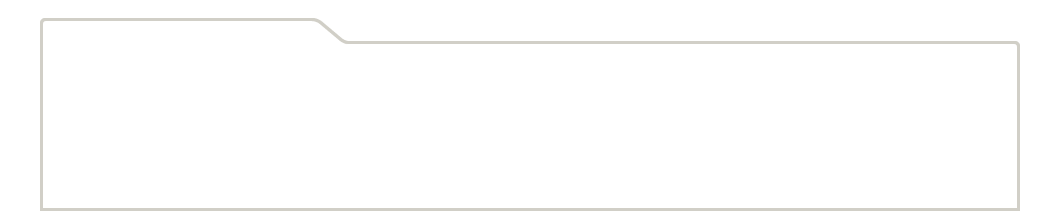
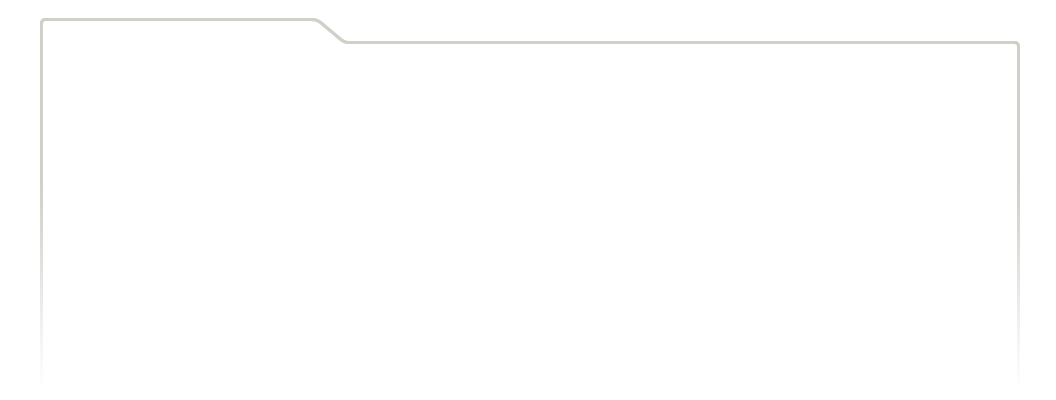
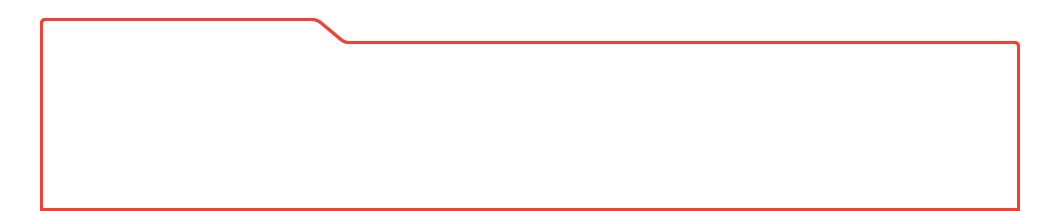
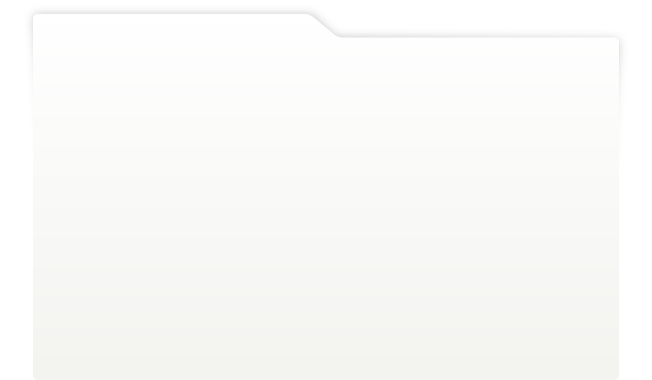
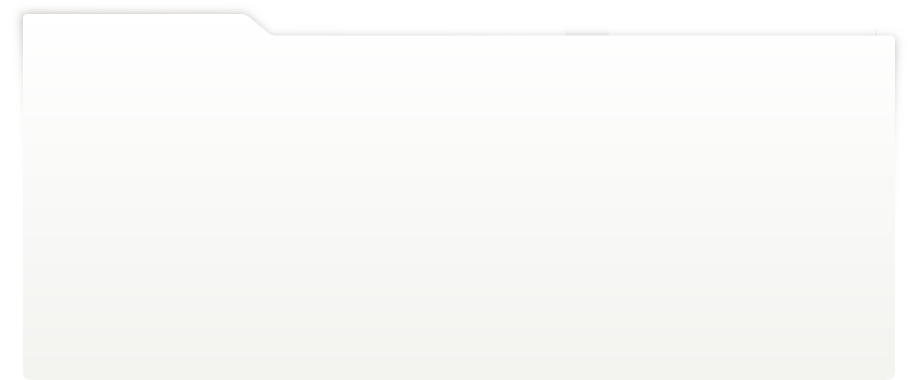
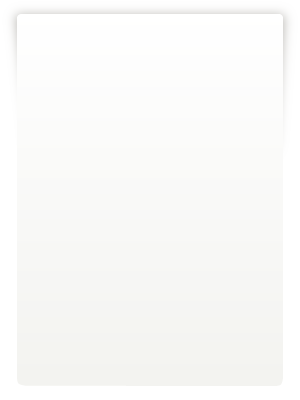
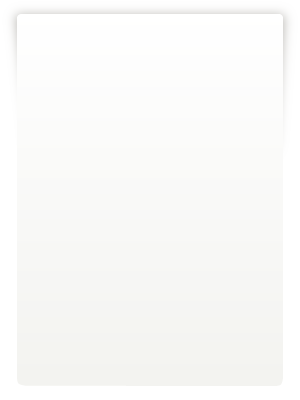
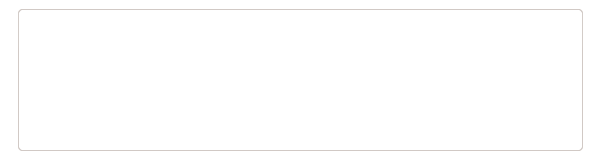
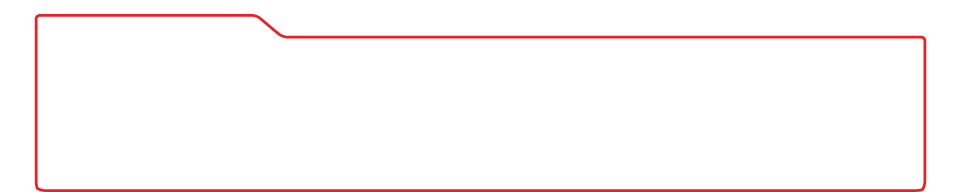
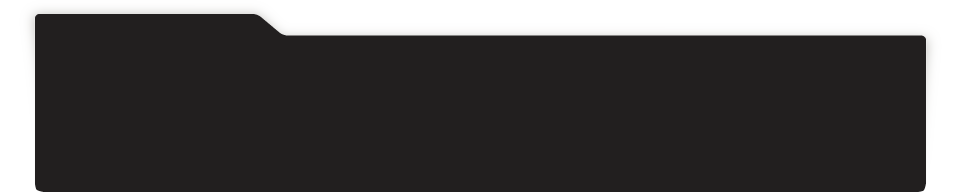
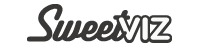
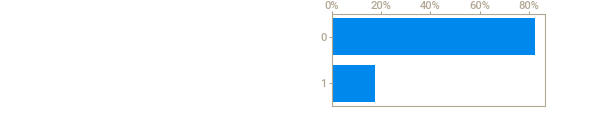
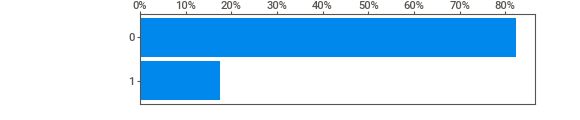
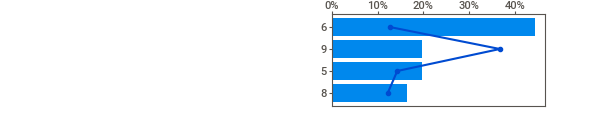
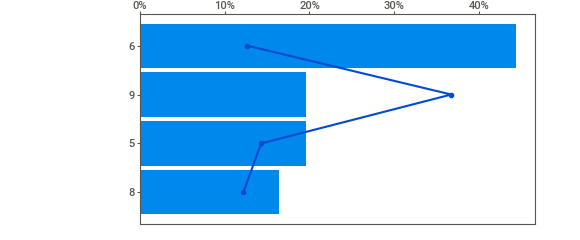
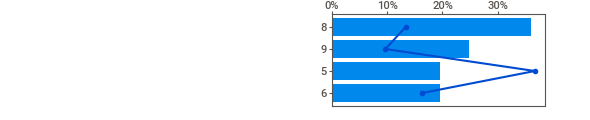
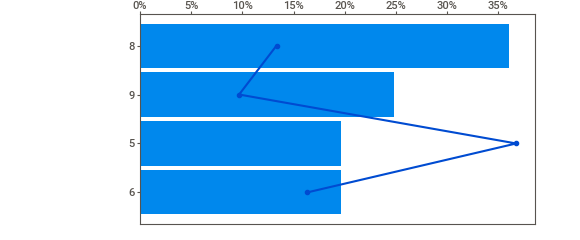
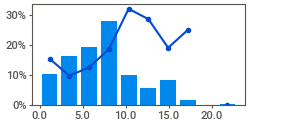
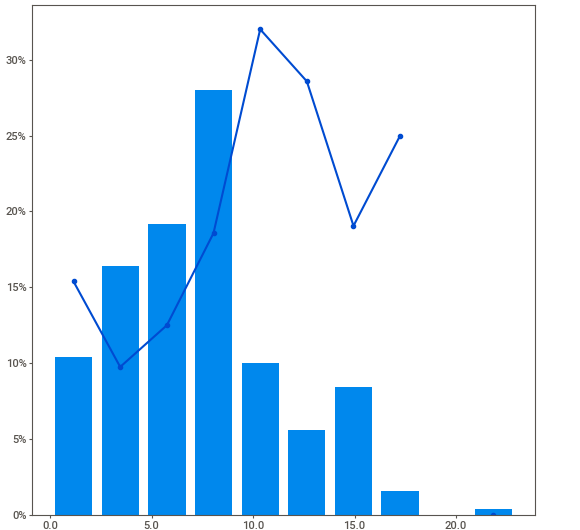
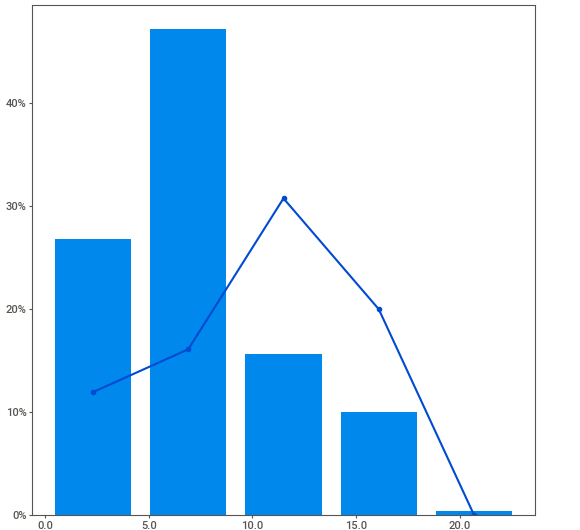
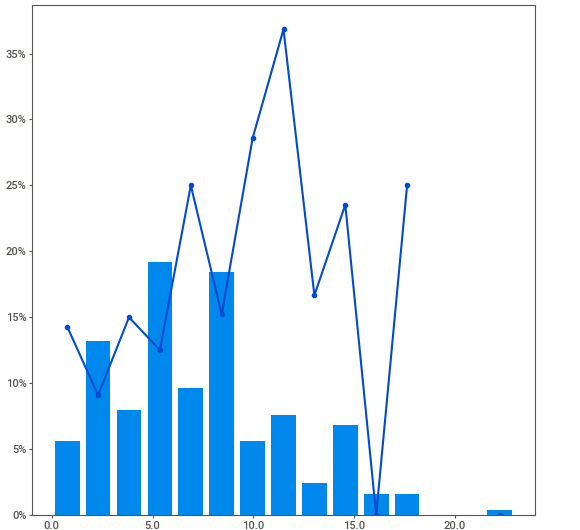
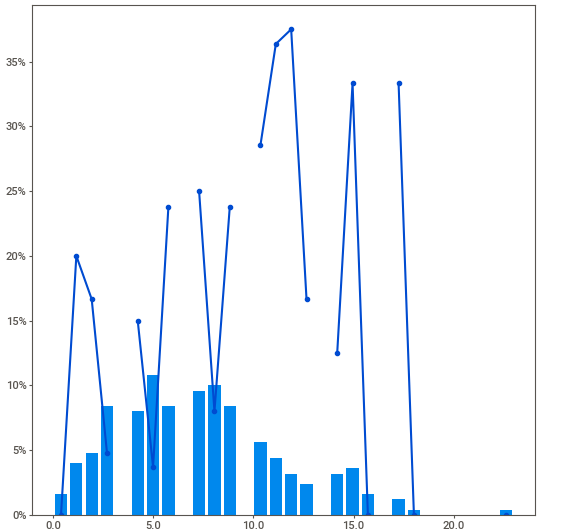
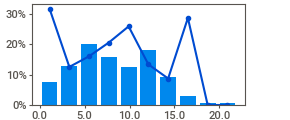
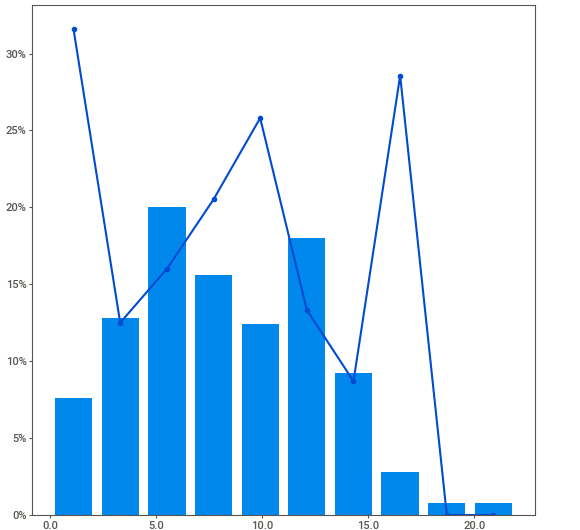
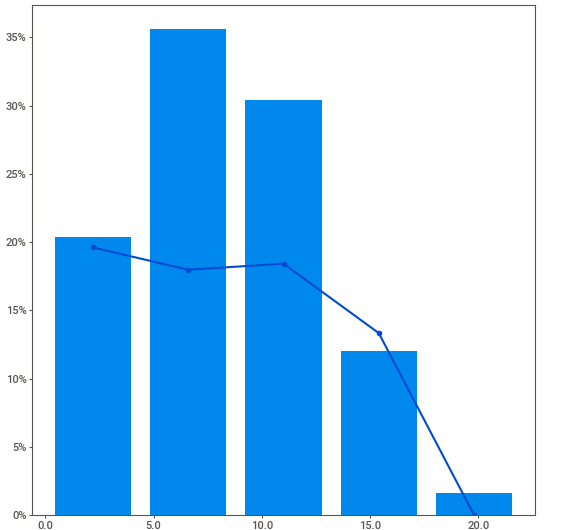
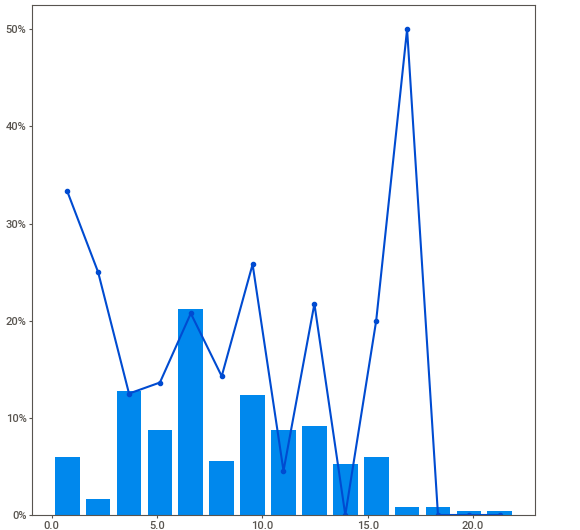
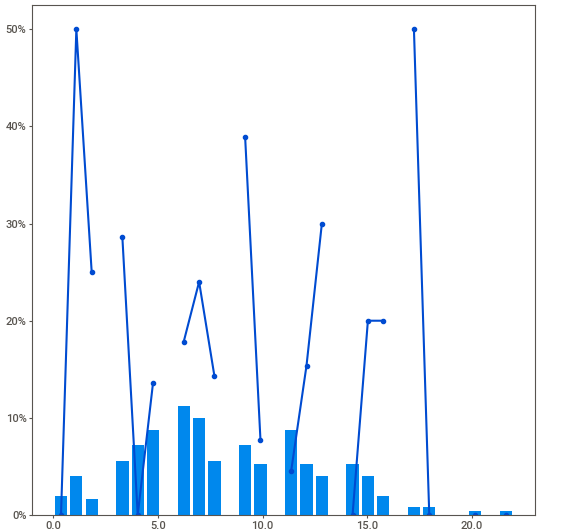
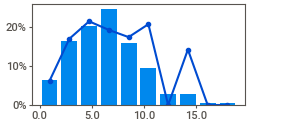
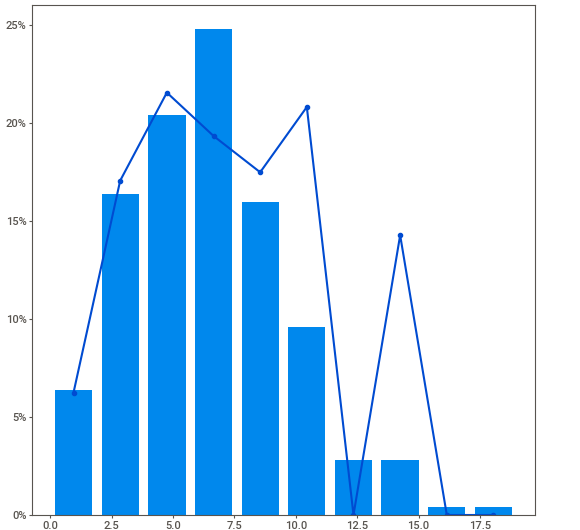
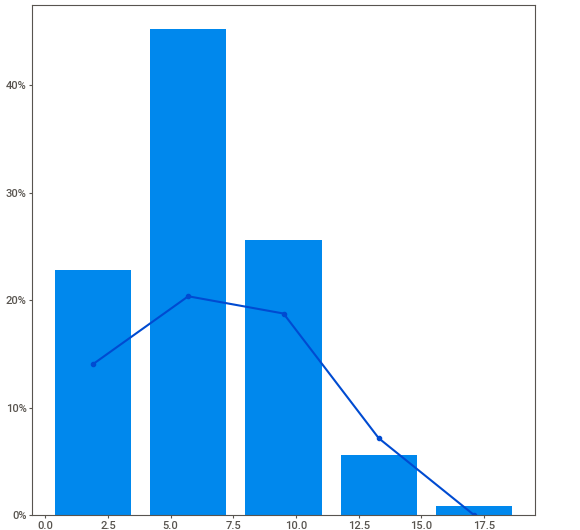
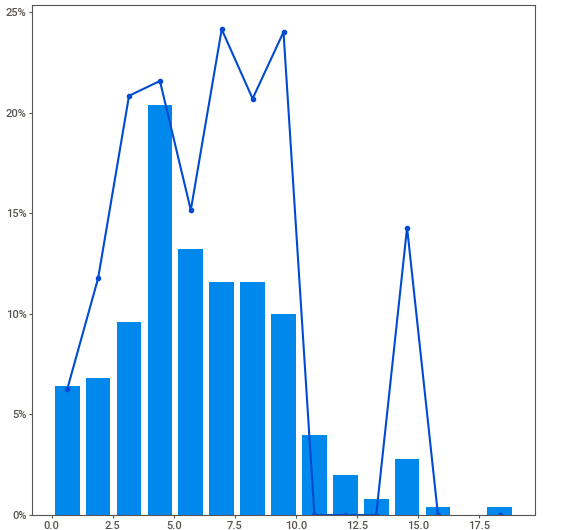
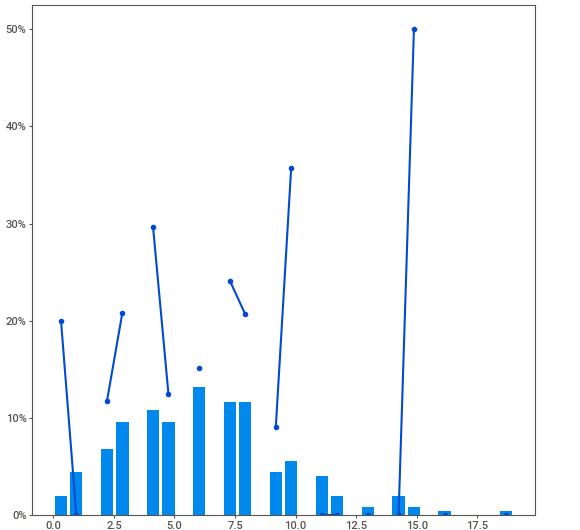
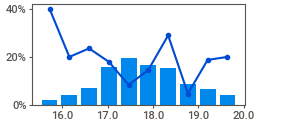
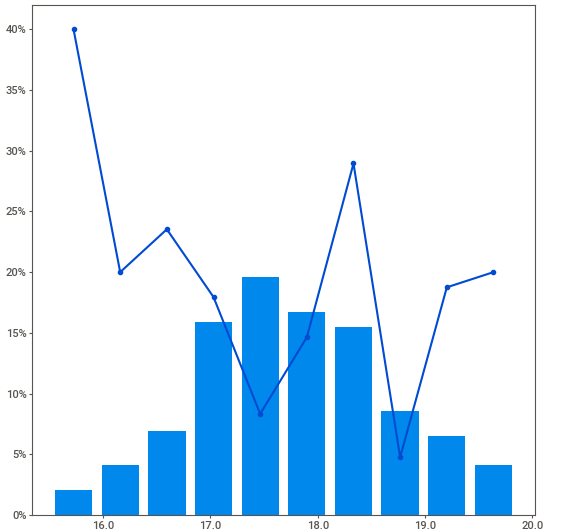
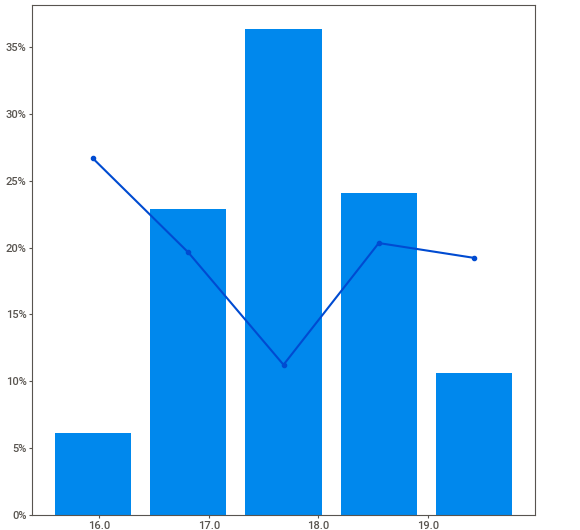
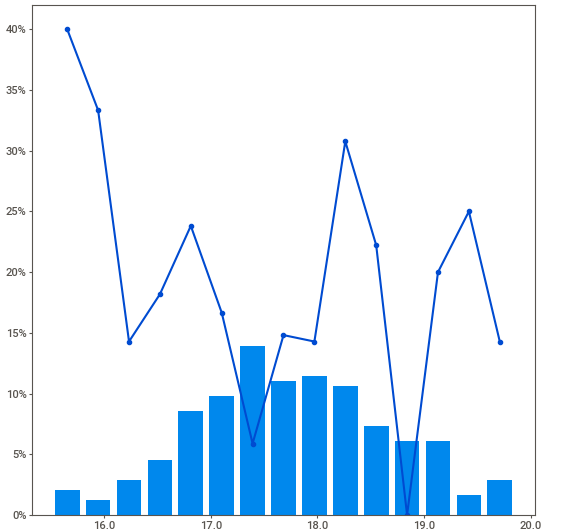
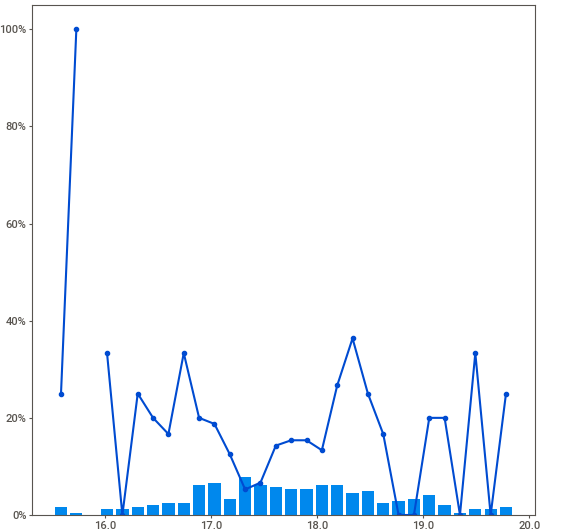
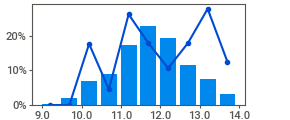
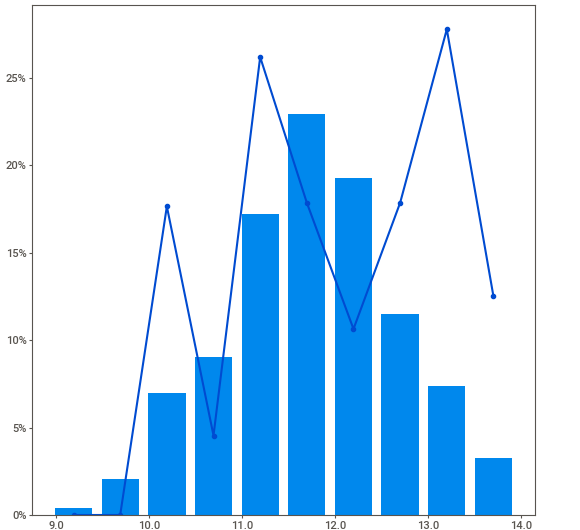
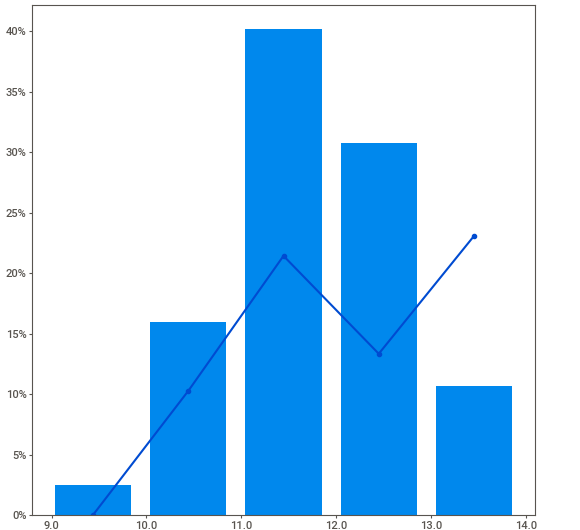
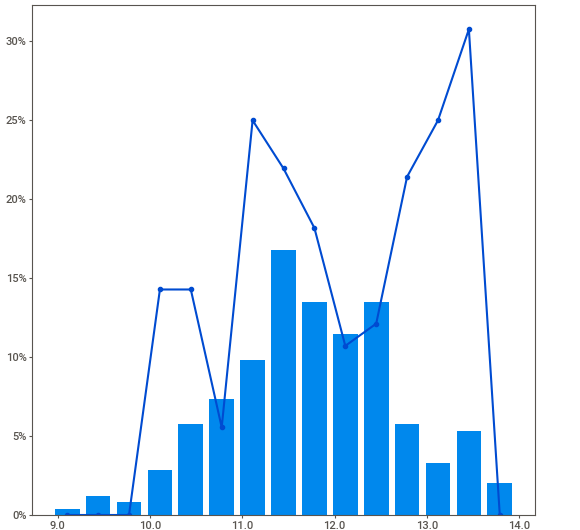
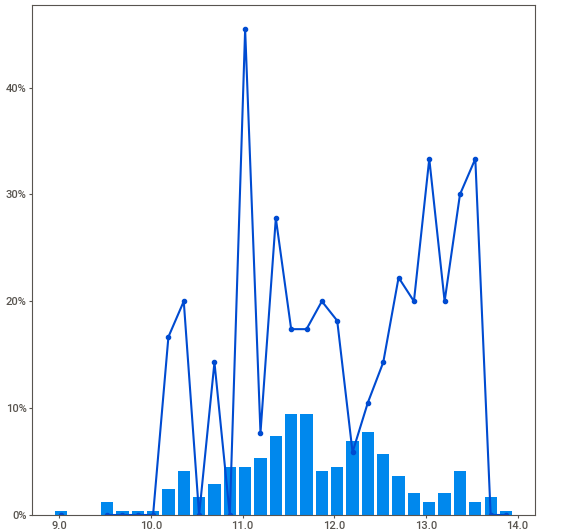
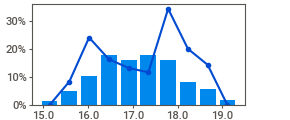
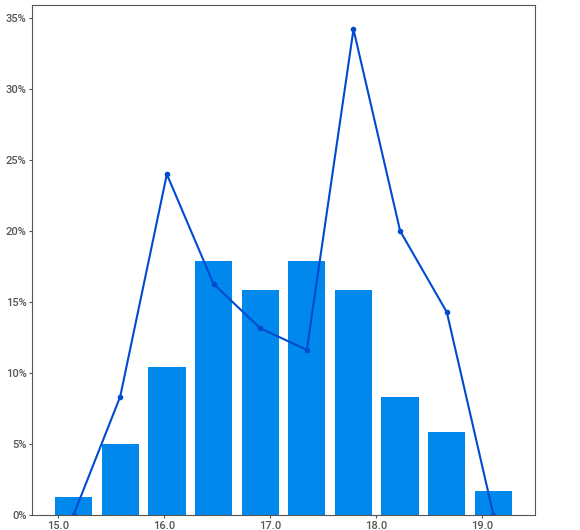
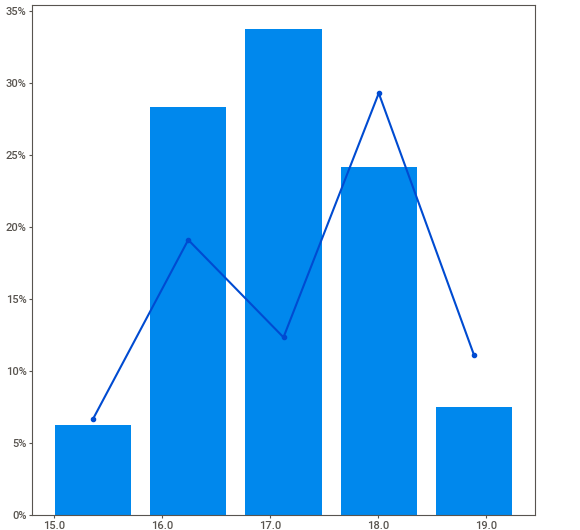
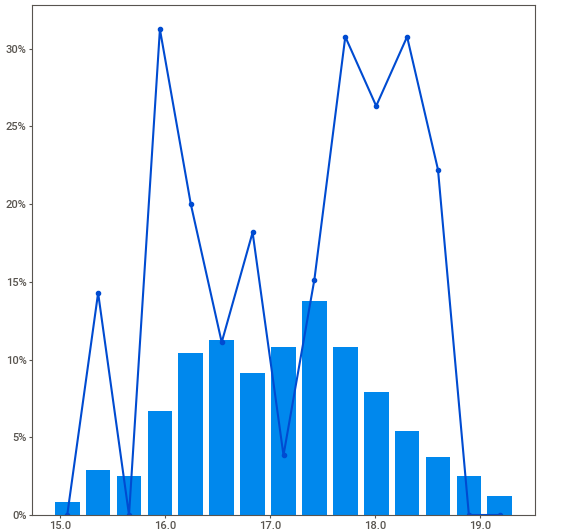
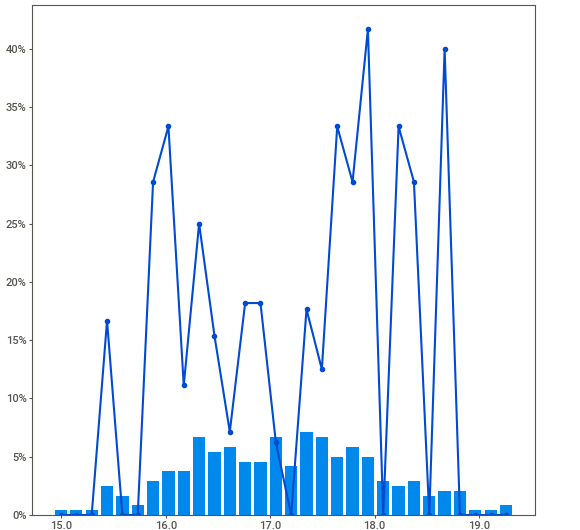
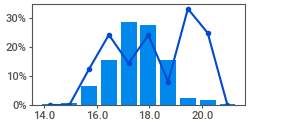
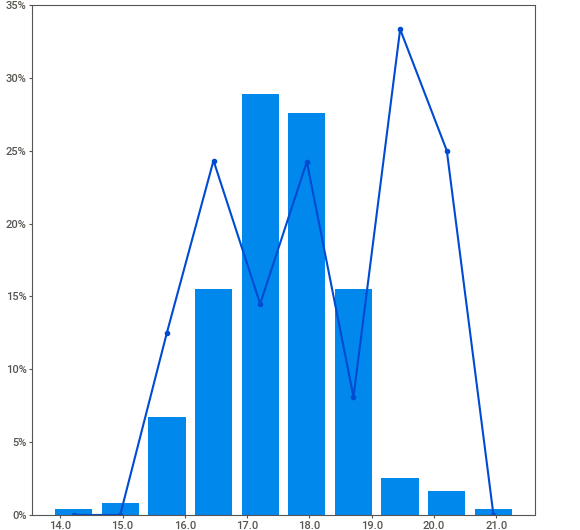
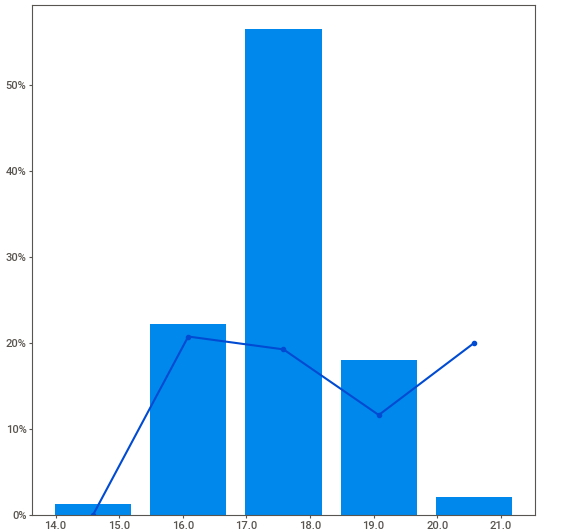
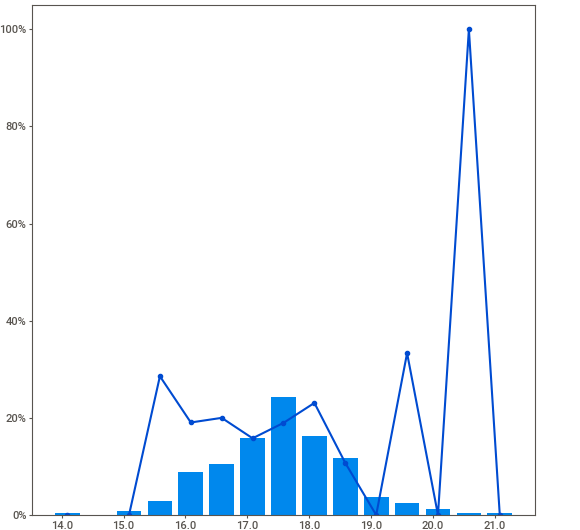
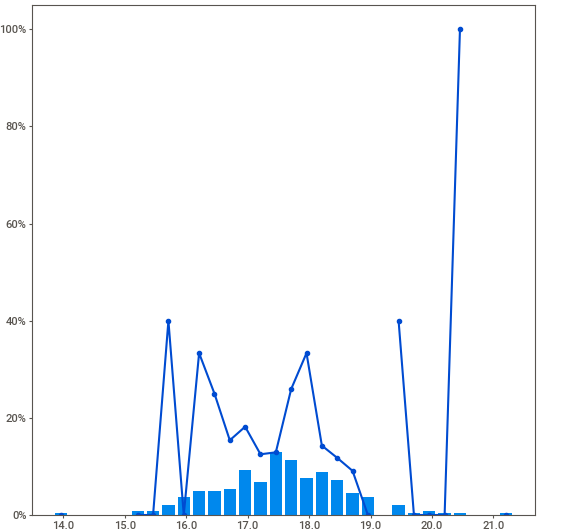
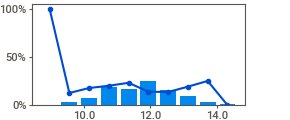
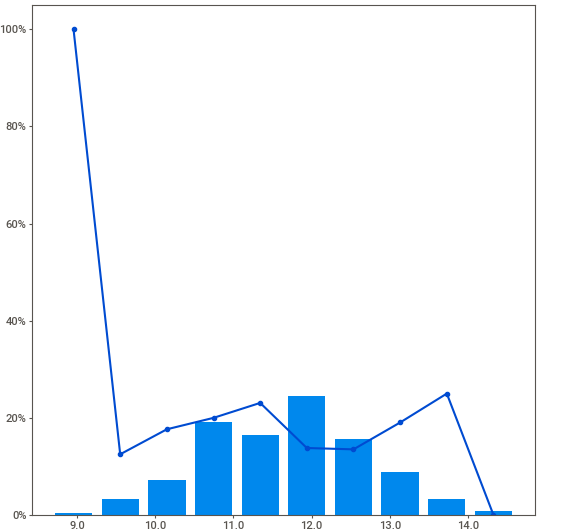
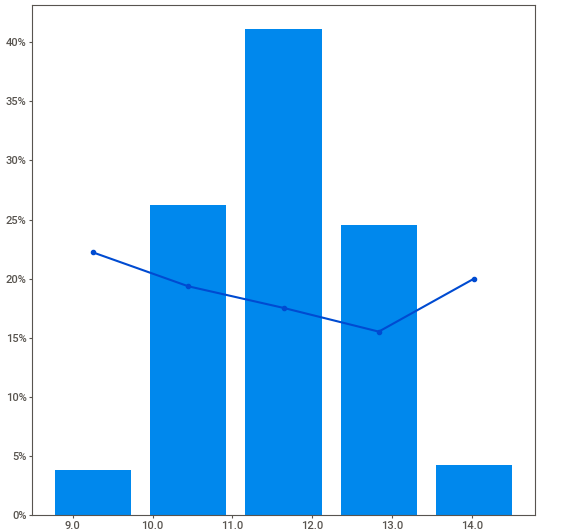
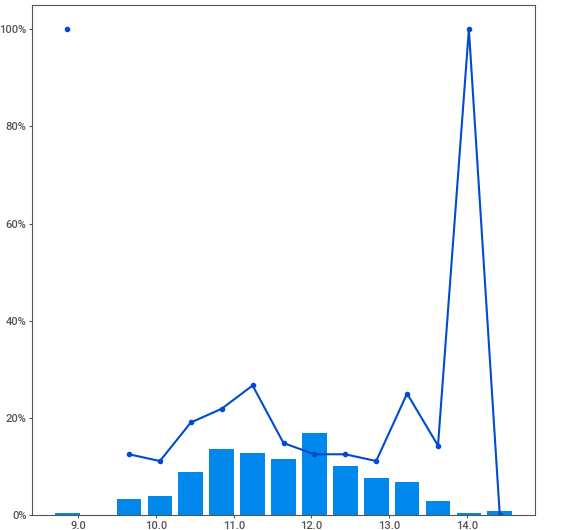
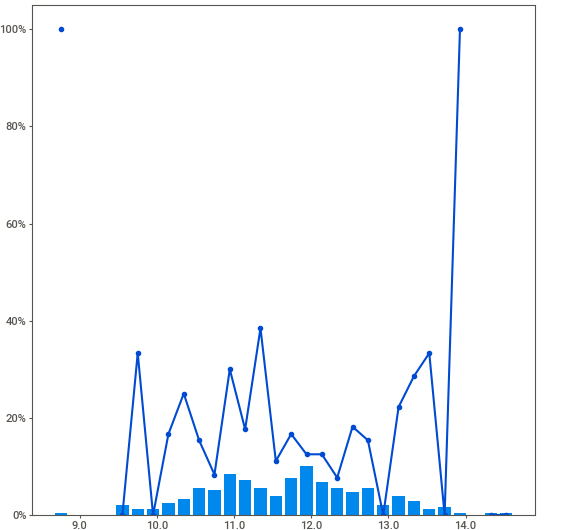
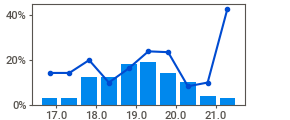
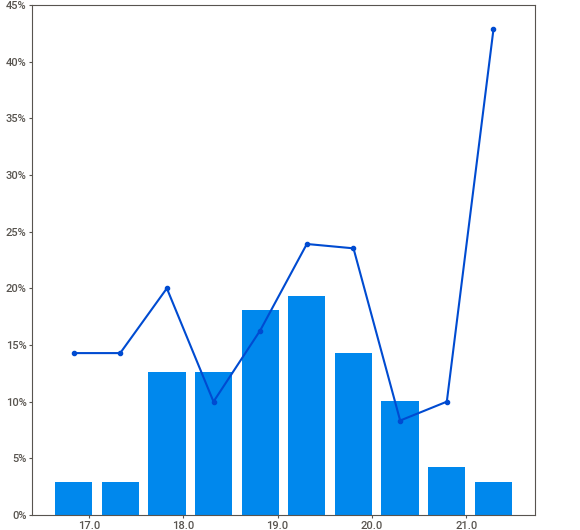
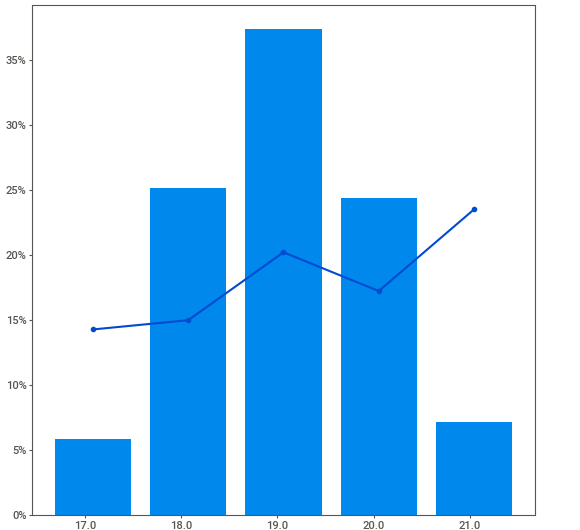
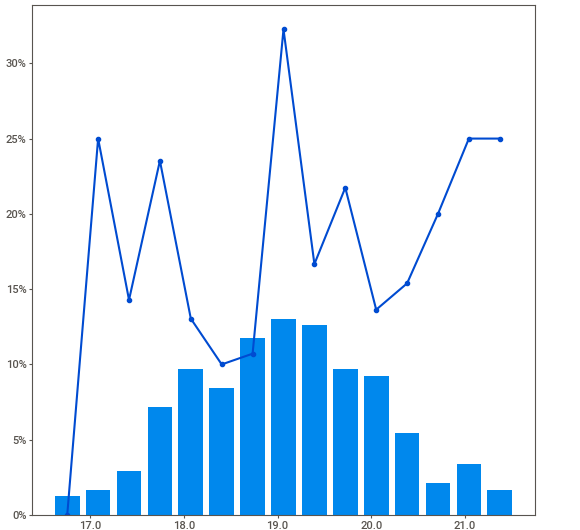
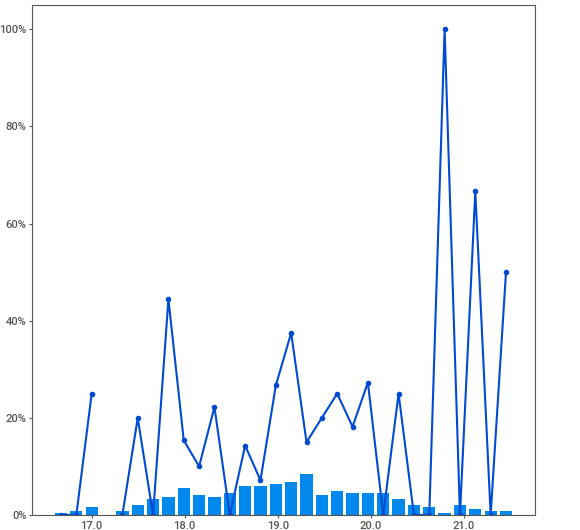
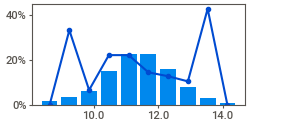
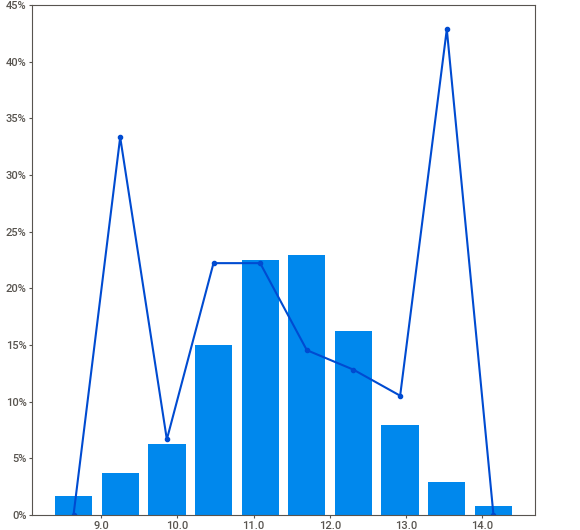
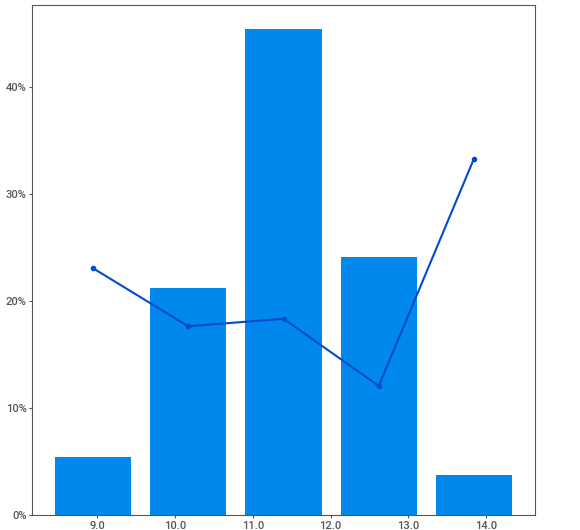
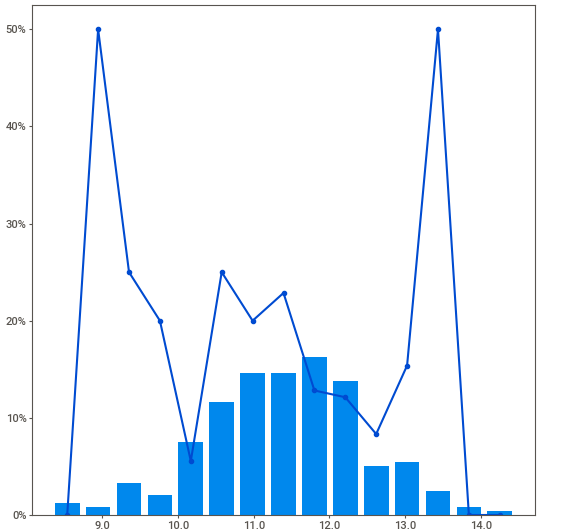
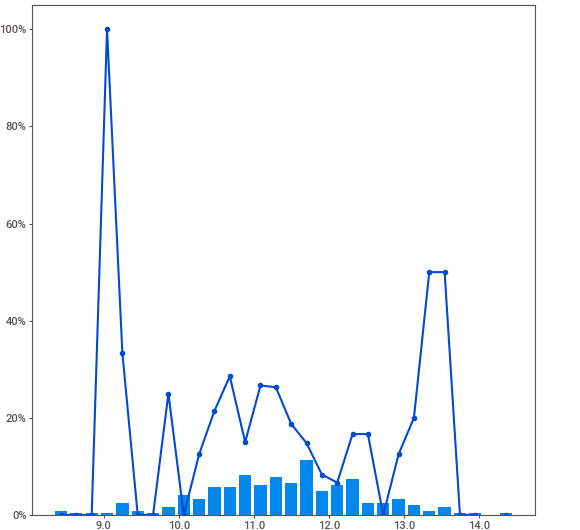
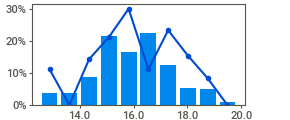
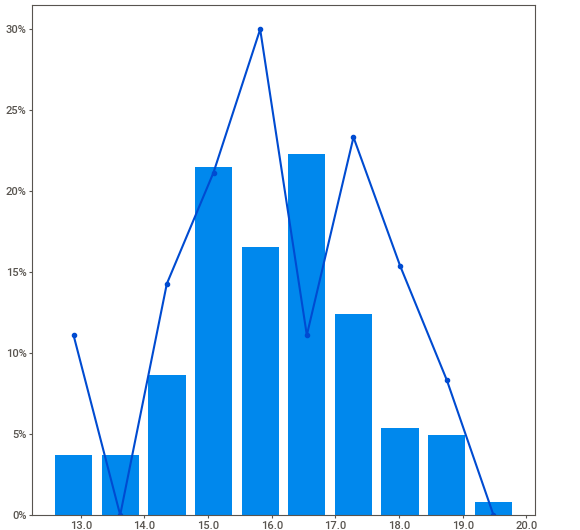
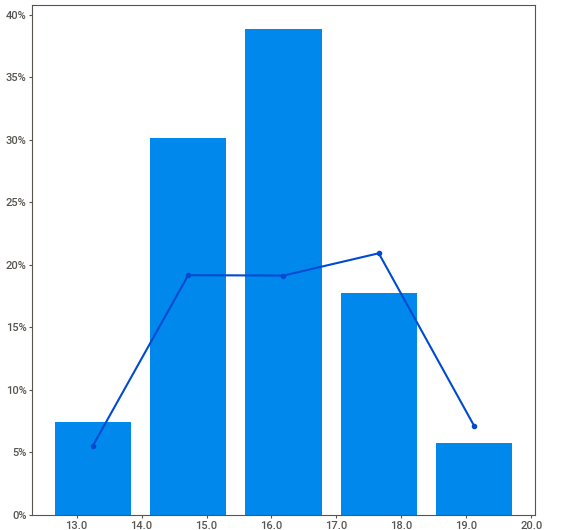
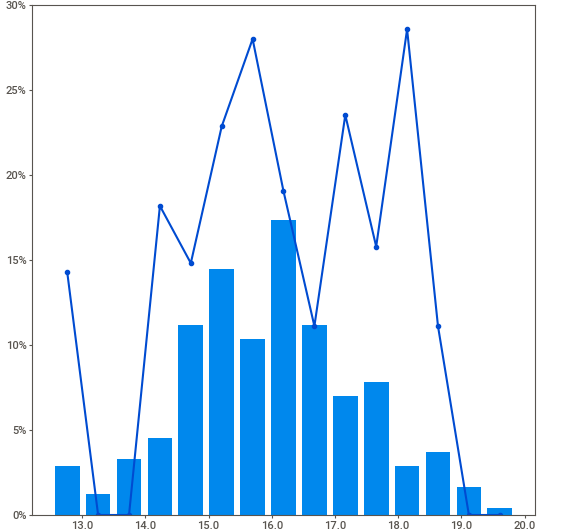
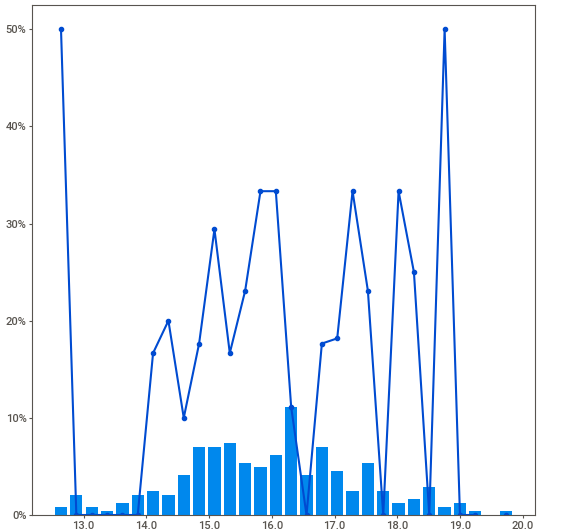
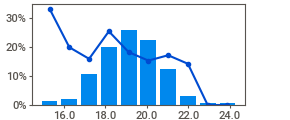
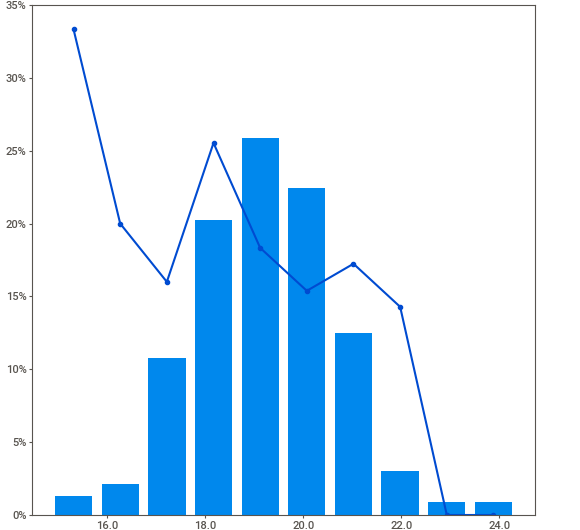
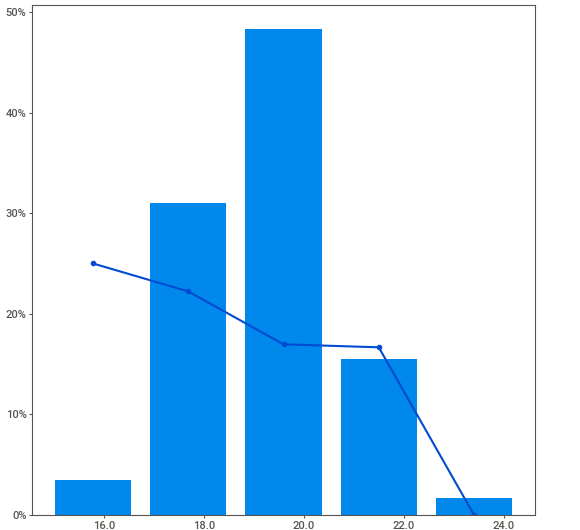
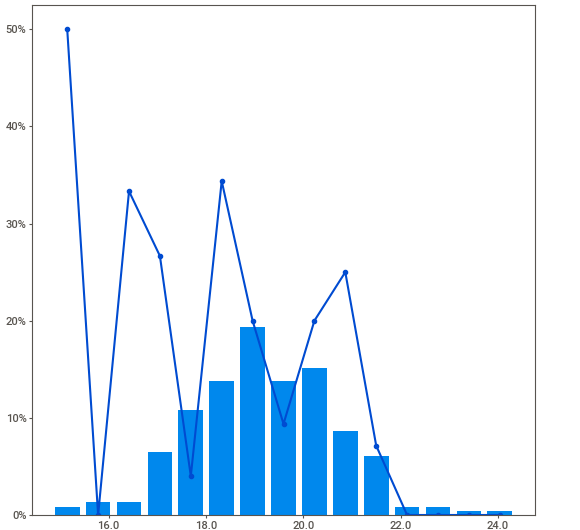
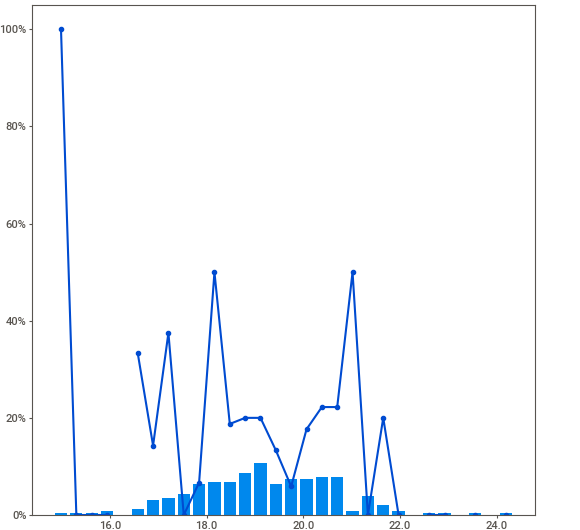
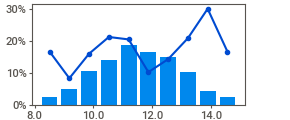
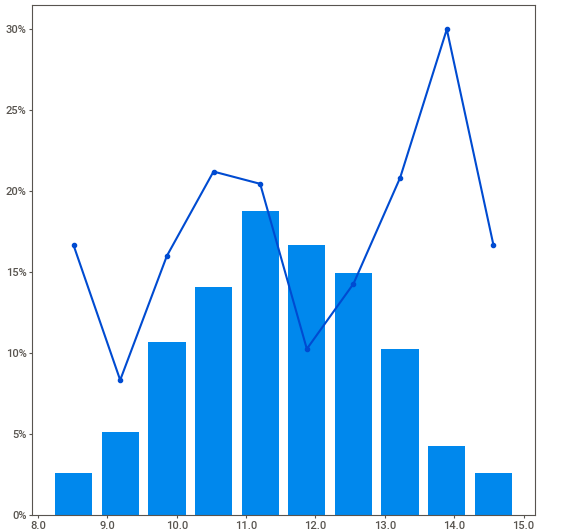
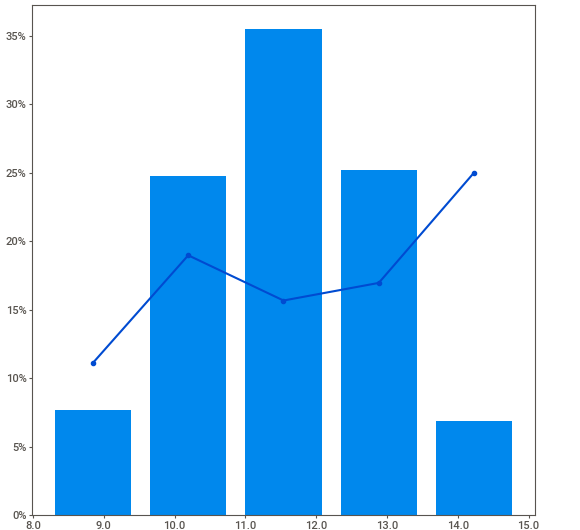
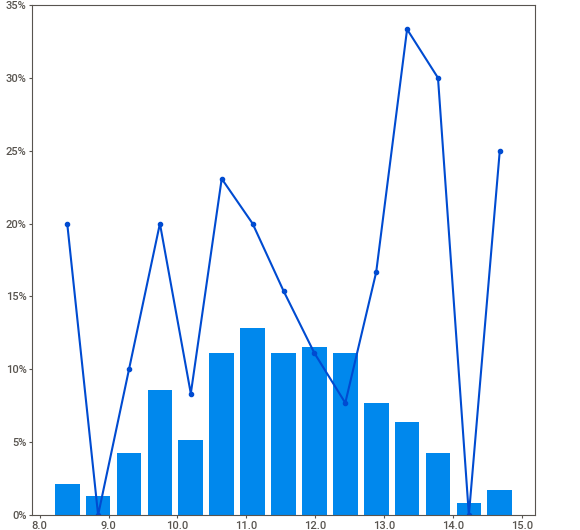
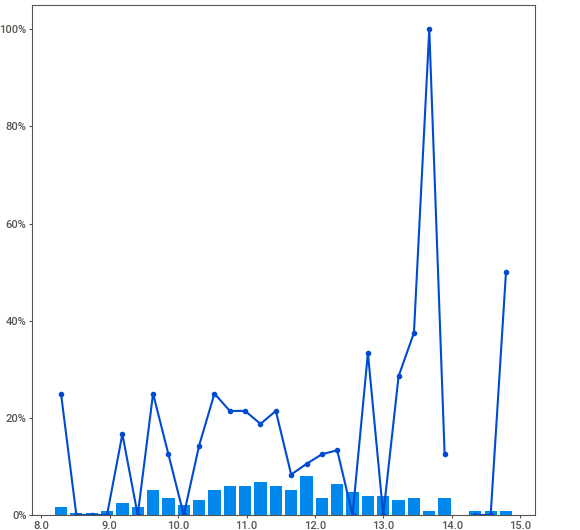
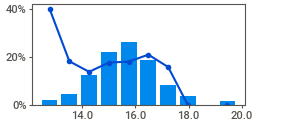
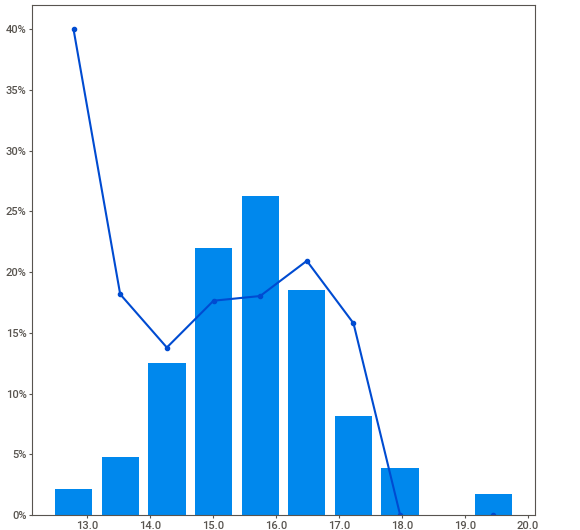
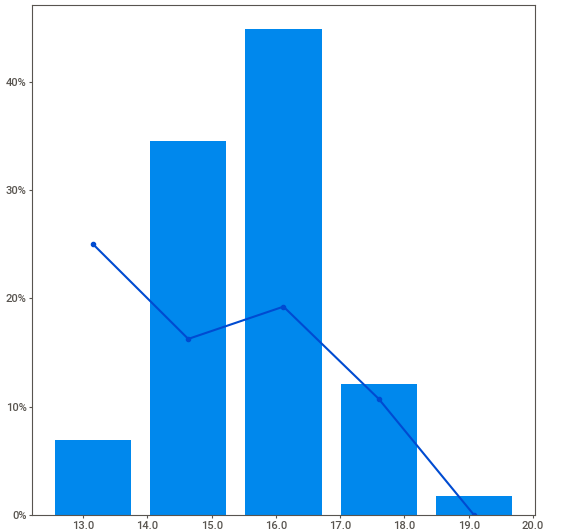
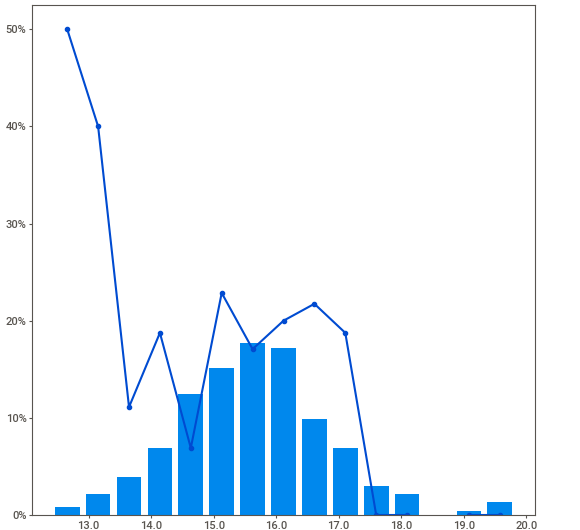
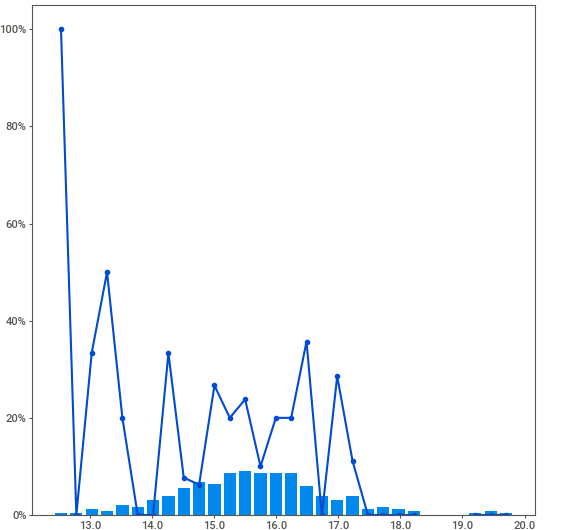
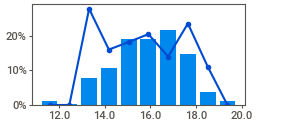
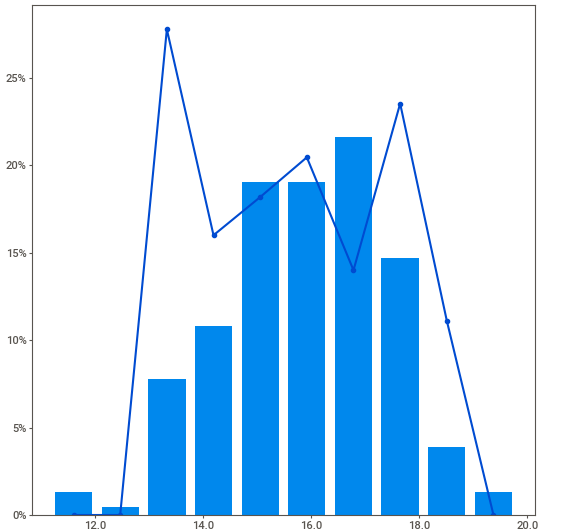
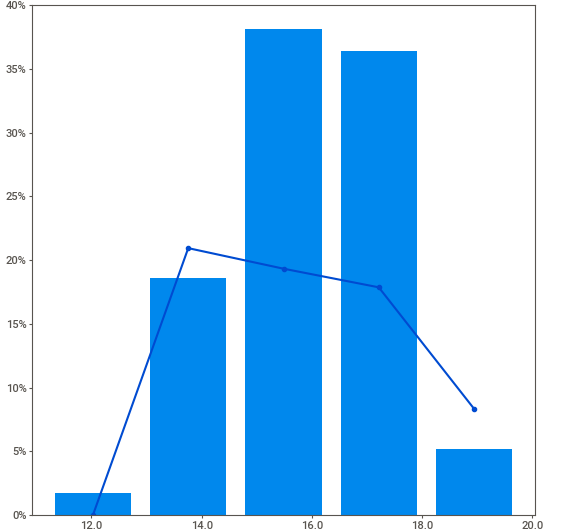
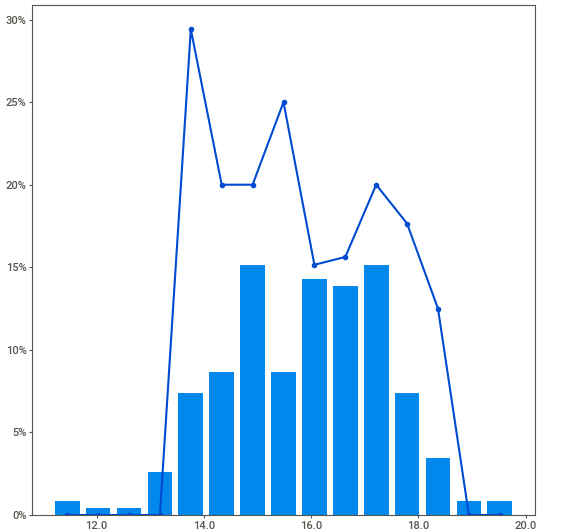
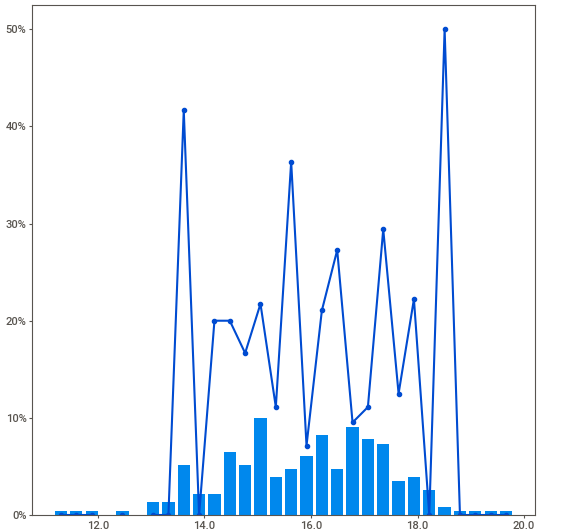
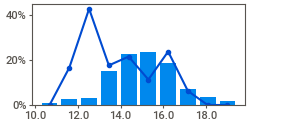
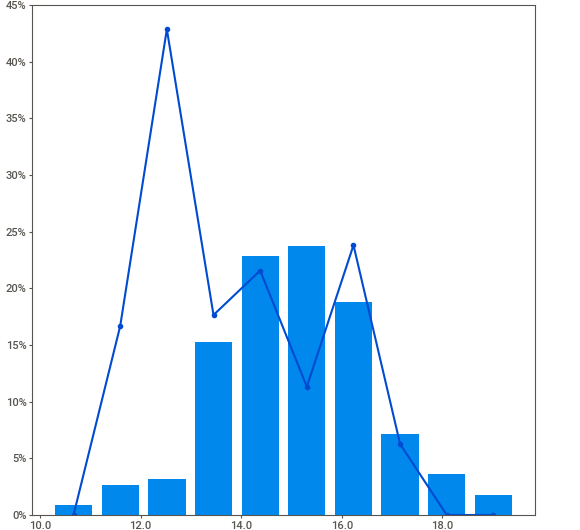
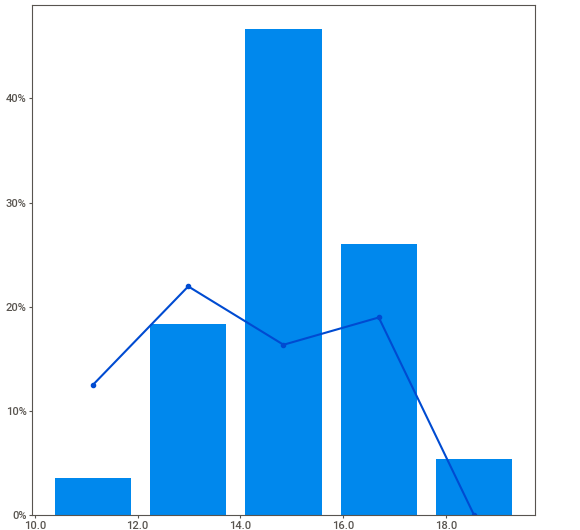
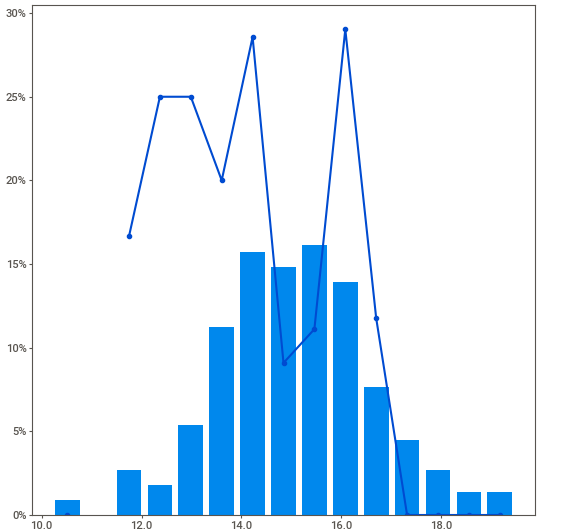
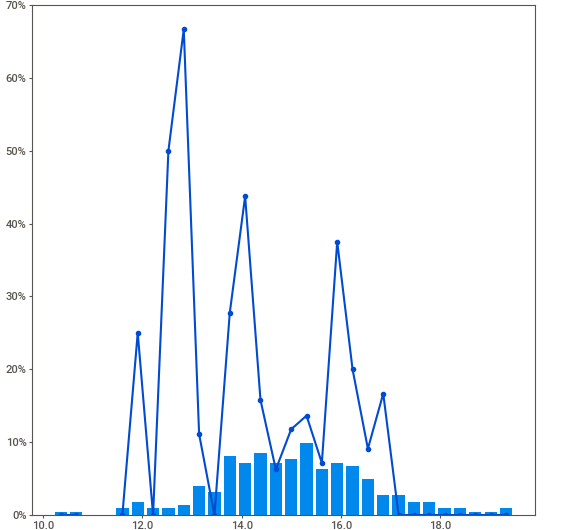
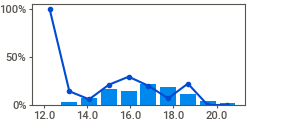
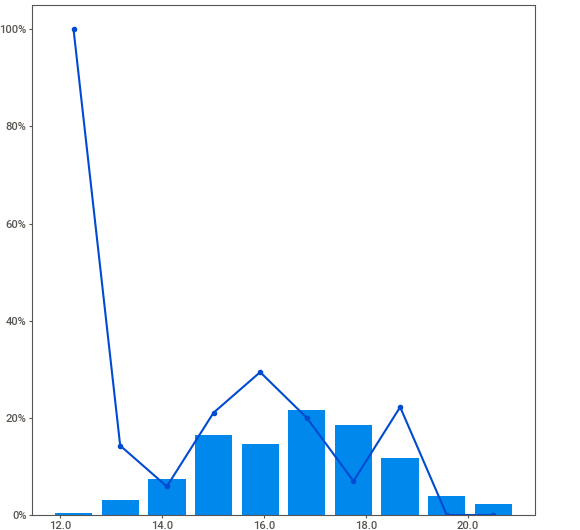
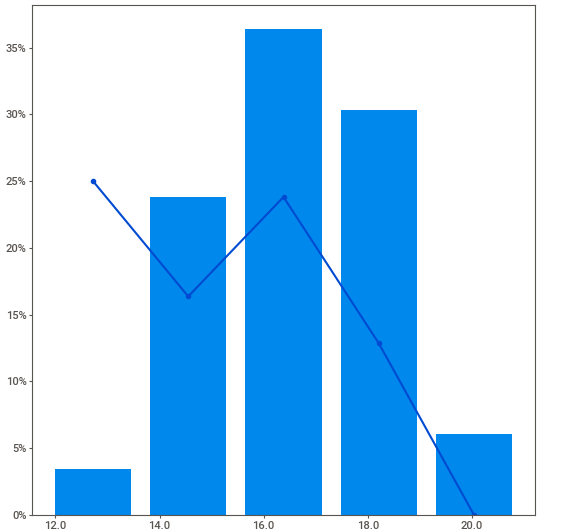
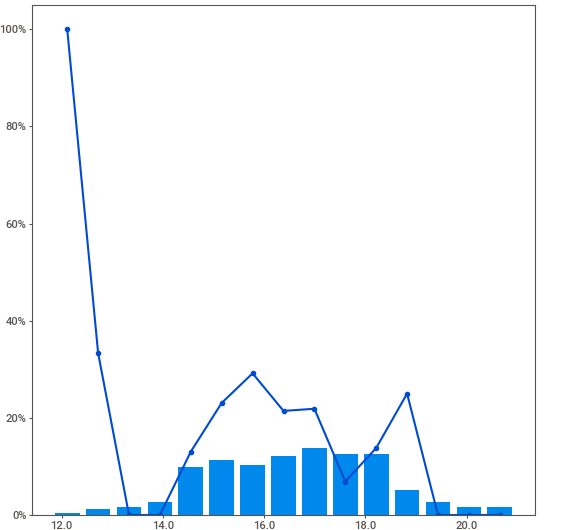
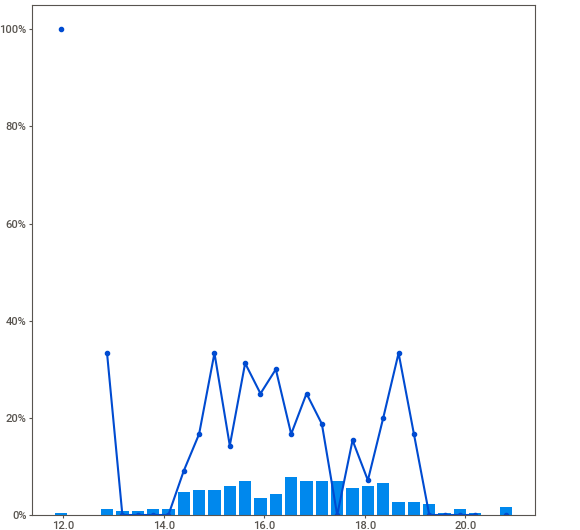
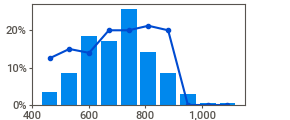
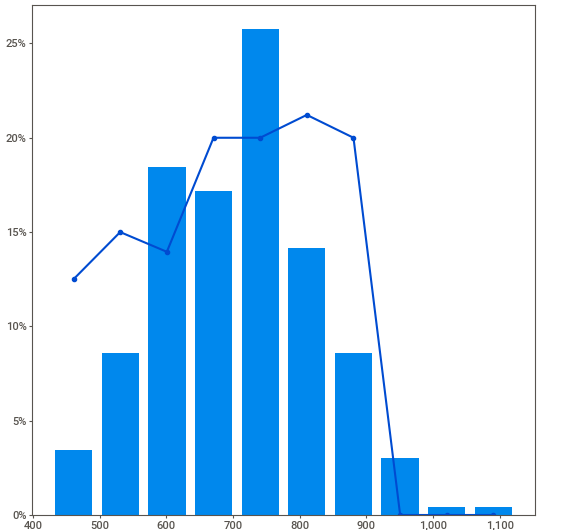
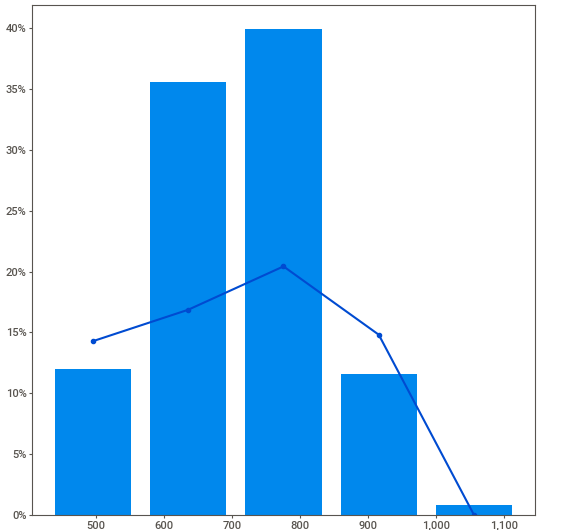
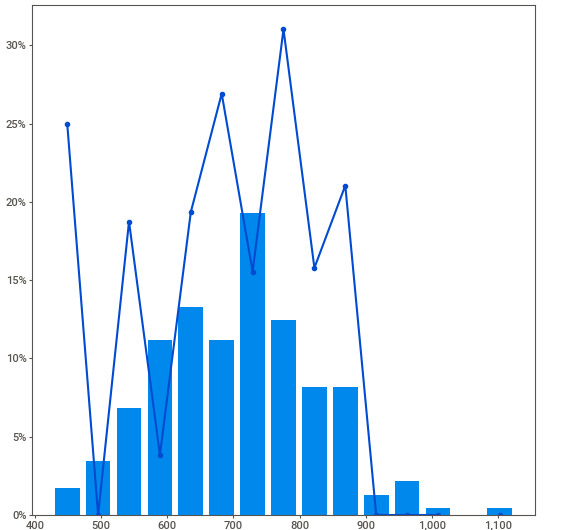
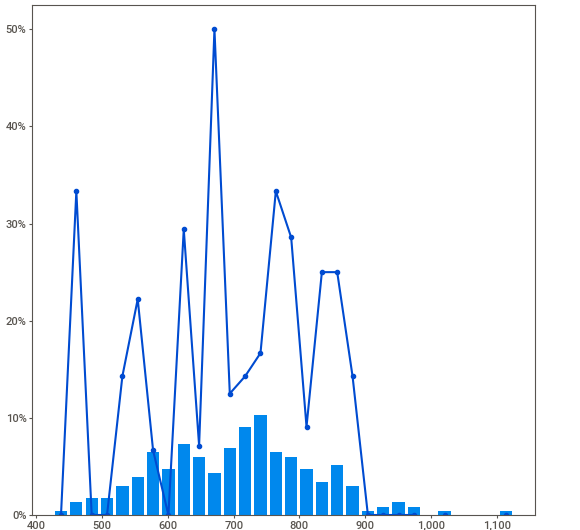
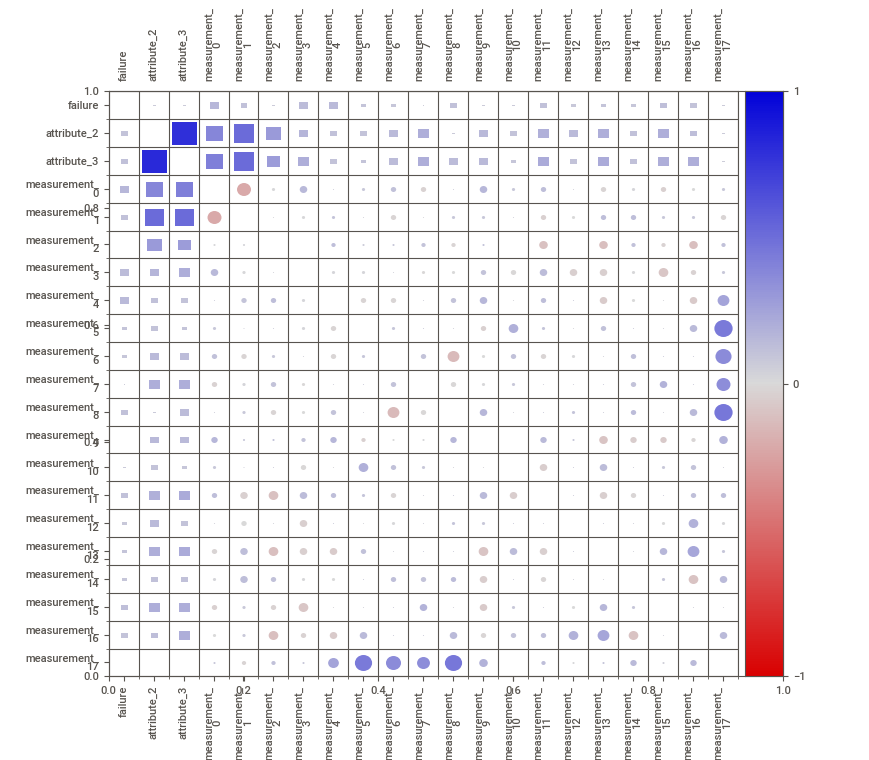
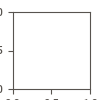

In [12]:

train_report = sv.analyze(train_num_saved, target_feat="failure")
train_report.show_notebook()

This is actually a challenging issue. The products clearly have different failure behaviors when loading is missing, but to extrapolate that behavior to new products, we have to connect it to one or more of the product attributes. Since product A is the most different from the other four under these conditions, attributes that have the same value for A and any other product code are not likely to be helpful, eliminating attributes 0 and 1.

But both attributes 2 and 3 have a unique value for product A, and in both cases it's either the smallest or largest value. Which of these is driving the behavior? Or is it both? And are these attributes intended to be categorical or ordinal?

My hunch is that:

1. `attribute_3` is the primary driver
2. The relatioship is roughly linear, so the attributes are ordinal

Both of these are based on the increasing failure rates as `attribute_3` gets smaller. `attribute_2` does not have this behavior, but is roughly constant when below 9. The transformations of the two features aren't sufficiently better than `attribute_3` to justify the added complexity.


### Missingness

The missingness patterns overall are strange/artificial...there's an linearly-increasing percentage of missing values as the measurement numbers get higher.

`meaurement_17` has the highest percent missing, which is a problem given it's the second most valuable feature. This is where having features that predict `measurement_17` well will be helpful.

<Axes: >

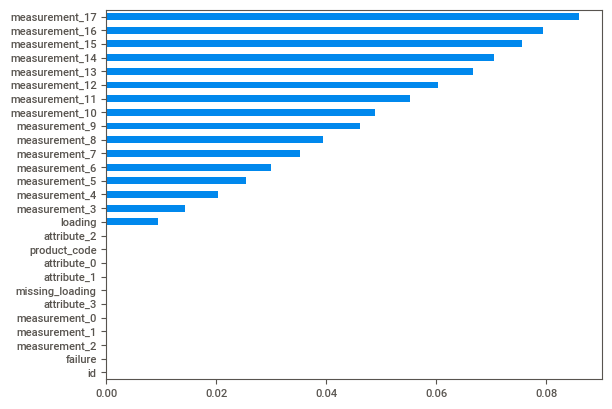

In [13]:
missing = train.isna()
missing.mean().sort_values().plot.barh()

## Modeling

### Overview

Overview of the final model:

1. Basic linear model using 2 features (automatically selected based on correlation, which defaults to `loading` and `measurement_17`)
2. A "backup" linear model used when `loading` is missing with 1 feature (automatically selected based on correlation, which defaults to `attribute_3`)
      1. Backup and overall model (with imputed median `loading`) averaged together when `loading` is missing, to protect against overfitting.
3. measurements 3-9 used to impute `measurement_17` by `product_code`

I used Ridge regression instead of Logistic Regression as the final linear model, because:

1. For this problem, it produces almost identical results
2. The coefficients are more straightforward to interpret.

### Testing Structure

A custom model class (`IterativeGroupClassifier`) and cross validation function (`cv_eval`) were created to allow principled testing of this strategy.

This is kind of like doing `cross_val_score` with `IterativeImputer`, but I coded it myself for two reasons:

1. `IterativeImputer` doesn't allow categorical features, so we'd have to leave out `product_code`. We've already demonstrated `product_code` provides valuable information on `measurement_17`, so that's a problem.
2. `cross_val_score` only uses the training data. For iterative imputation, we can actually use the testing predictors to help with the imputation. And we'll need to to submit, since the test data contains new `product_code`s.

Both of these are in the module `spongepredict`, in the `src` directory



In [14]:
from typing import Any, Callable, Union
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import combinations


from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer


class IterativeGroupClassifier(BaseEstimator, ClassifierMixin):
    """Iterative Group Classifier

    Takes in a train and test dataset and imputes both based on the specified
    rules. For the Kaggle challenge, primarily operates by having separate
    imputation models for different values of product_code. Also allows for a
    backup model to be used when the most important feature is missing.
    """

    def __init__(
        self,
        iterative_regressor,
        classifier,
        backup_est=None,
        use_backup="partial",
    ):
        self.iterative_regressor = iterative_regressor
        self.classifier = classifier
        if backup_est is None:
            self.backup_est = clone(classifier)
        else:
            self.backup_est = backup_est
        self.use_backup = use_backup

    def _iterative_impute(
        self,
        X: pd.DataFrame,
        group_col: str = None,
        fit: bool = True,
        max_iter: int = 5,
        impute_cols: list[str] = None,
    ) -> pd.DataFrame:
        """_summary_

        Parameters
        ----------
        X : pd.DataFrame
            Data to impute
        group_col : str, optional
            If specified, separate imputing models fit to each group, by
            default None
        fit : bool, optional
            _description_, by default True
        max_iter : int, optional
            _description_, by default 5
        impute_cols : list[str], optional
            If specified, will only impute these columns, by default None

        Returns
        -------
        pd.DataFrame
            _description_
        """
        # Specify impute cols
        self.impute_cols = impute_cols
        if self.impute_cols is None:
            self.impute_cols = list(X.columns)

        # Perform initial imputations using mean
        complete = X.copy()
        masks = np.zeros(X.shape, dtype=bool)
        for i in range(X.shape[1]):
            masks[:, i] = X.iloc[:, i].notna()
            if ((~masks[:, i]).sum() == 0) | (
                X.columns[i] not in self.impute_cols
            ):
                continue
            complete.iloc[~masks[:, i], i] = X.iloc[masks[:, i], i].mean()
            # complete.iloc[~masks[:, i], i] = X.iloc[masks[:, i], i].median()

        # Iteratively train models
        if fit:
            # Very cool: <https://stackoverflow.com/a/27809959>
            self.models: dict = defaultdict(lambda: defaultdict(dict))
        for i in range(max_iter):
            for j in range(X.shape[1]):
                col = X.columns[j]
                if ((~masks[:, j]).sum() == 0) | (col not in self.impute_cols):
                    continue

                if group_col is None:

                    # Masks for fitting and imputing
                    fit_mask = masks[:, j]
                    pred_mask = ~masks[:, j]
                    if (fit_mask.sum() == 0) | (pred_mask.sum() == 0):
                        # Skip if nothing to fit or predict
                        continue
                    # Fit model
                    curr_pred = [
                        feat for feat in complete.columns if feat not in [col]
                    ]
                    if fit:
                        est = clone(self.iterative_regressor)
                        est.fit(
                            complete.loc[fit_mask, curr_pred],
                            complete.loc[fit_mask, col],
                        )
                        # Save model
                        self.models[i][col] = est

                    # Re-impute missing
                    complete.loc[pred_mask, col] = self.models[i][col].predict(
                        complete.loc[pred_mask, curr_pred]
                    )
                else:
                    for group in complete[group_col].unique():
                        # Masks for fitting and imputing
                        fit_mask = masks[:, j] & (complete[group_col] == group)
                        pred_mask = (~masks[:, j]) & (
                            complete[group_col] == group
                        )

                        if (fit_mask.sum() == 0) | (pred_mask.sum() == 0):
                            # Skip if nothing to fit or predict
                            continue

                        # Fit model
                        curr_pred = [
                            feat
                            for feat in complete.columns
                            if feat not in [col, group_col]
                        ]
                        if fit:
                            est = clone(self.iterative_regressor)
                            est.fit(
                                complete.loc[fit_mask, curr_pred],
                                complete.loc[fit_mask, col],
                            )
                            # Save model
                            self.models[i][col][group] = est

                        # Re-impute missing
                        complete.loc[pred_mask, col] = self.models[i][col][
                            group
                        ].predict(complete.loc[pred_mask, curr_pred])

        return complete

    def _quick_predict(self, est, data):
        if hasattr(est, "predict_proba"):
            return est.predict_proba(data)[:, 1]
        else:
            return est.predict(data)

    def fit(
        self,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        X_test: pd.DataFrame,
        return_predictions: bool = True,
        group_col: str = "product_code",
        use_groups: bool = True,
        fs_func: Callable = f_classif,
        **impute_params
    ) -> Union[np.ndarray, Any]:
        """Fit Classifier

        Parameters
        ----------
        X_train : pd.DataFrame
            Training data
        y_train : pd.Series
            Training labels
        X_test : pd.DataFrame
            Test data
        return_predictions : bool, optional
            Whether to return predictions, by default True
        group_col : str, optional
            Feature to group by while imputing, by default "product_code"
        use_groups : bool, optional
            Whether to use groups while imputing, by default True
        fs_func : function, optional
            Function used for feature selection, by default f_classif

        Returns
        -------
        Union[np.ndarray, Any]
            If return_predictions, then predictions. Otherwise, the classifier.
        """

        # Combine X datasets
        train_missing = X_train.isna()
        test_missing = X_test.isna()
        n_train = X_train.shape[0]  # For splitting out later
        X = pd.concat([X_train, X_test])

        # Impute
        iterative_group_col = None
        if use_groups:
            iterative_group_col = group_col
        complete = self._iterative_impute(
            X, group_col=iterative_group_col, **impute_params
        )

        # Re-split
        X_train = complete.iloc[:n_train, :]
        X_test = complete.iloc[n_train:, :]

        # Fit model
        if self.use_backup == "None":
            self.classifier.fit(X_train.drop(columns=group_col), y_train)
        else:
            # Get best col
            f_stat, _ = fs_func(X_train.drop(columns=group_col), y_train)
            self.backup_col = X_train.columns[f_stat.argmax()]

            mask = train_missing[self.backup_col]

            # Fit primary
            self.classifier.fit(
                X_train[~mask].drop(columns=group_col), y_train[~mask]
            )

            # Fit backup
            self.backup_est.fit(
                X_train[mask].drop(columns=[group_col, self.backup_col]),
                y_train[mask],
            )

        # Get predictions if specified
        if return_predictions:
            return self._predict(
                X_test, mask=test_missing[self.backup_col], group_col=group_col
            )
        else:
            return self.classifier

    def _predict(
        self,
        X_test: pd.DataFrame,
        mask: pd.Series,
        group_col: str = "product_code",
    ) -> np.ndarray:
        """Make predictions on already imputed test set

        Parameters
        ----------
        X_test : pd.DataFrame
            Test data, already imputed
        mask : pd.Series
            Whether most important feature is missing
        group_col : str, optional
            Feature to group on, by default "product_code"

        Returns
        -------
        np.ndarray
            Predictions
        """
        # Predict
        if self.backup_est is None:
            return self._quick_predict(
                self.classifier, X_test.drop(columns=group_col)
            )
        else:
            y_pred = np.zeros(X_test.shape[0])

            # Make primary predictions
            y_pred[~mask] = self._quick_predict(
                self.classifier, X_test[~mask].drop(columns=group_col)
            )

            # Make backup predictions
            y_pred[mask] = self._quick_predict(
                self.backup_est,
                X_test[mask].drop(columns=[group_col, self.backup_col]),
            )
            if self.use_backup == "partial":
                # Add in primary predictions
                y_pred[mask] += self._quick_predict(
                    self.classifier, X_test[mask].drop(columns=group_col)
                )

                # Divide by 2
                y_pred[mask] /= 2
            return y_pred

    def predict(self, X_test, group_col="product_code") -> np.ndarray:
        """Make predictions test set

        Parameters
        ----------
        X_test : pd.DataFrame
            Test data
        group_col : str, optional
            Feature to group on, by default "product_code"

        Returns
        -------
        np.ndarray
            Predictions
        """
        # Impute
        missing_mask = X_test[self.backup_col].isna()
        X_test = self._iterative_impute(X_test, group_col=group_col, fit=False)

        return self._predict(X_test, mask=missing_mask, group_col=group_col)


# Define feature selection function
def fs_func(X, y):
    X_ = SimpleImputer().fit_transform(X)
    return f_classif(X_, y)


def cv_eval(est, X, y, group_col, metrics, test_groups=1, **fit_params):
    """Custom Cross validation

    Parameters
    ----------
    est : _type_
        _description_
    X : _type_
        _description_
    y : _type_
        _description_
    group_col : _type_
        _description_
    metrics : _type_
        _description_
    test_groups : int, optional
        How many product_codes to have in the test fold at a time, by default 1
    use_groups : bool, optional
        _description_, by default True

    Returns
    -------
    _type_
        _description_
    """

    # Copy and scale
    X_ = X.copy()

    # Run tests
    row_list = []
    estimators = []
    all_group_sets = combinations(X_[group_col].unique(), test_groups)
    for group_set in all_group_sets:
        row = {"group": group_set}

        # Get train and test groups
        test_mask = X_[group_col].isin(group_set)
        X_train, X_test = X_[~test_mask].copy(), X_[test_mask].copy()
        y_train, y_test = y[~test_mask].copy(), y[test_mask].copy()

        # Train and make predictions
        curr_est = clone(est)
        y_pred = curr_est.fit(
            X_train,
            y_train,
            X_test,
            return_predictions=True,
            group_col=group_col,
            **fit_params
        )  # [:, 1]

        # Evaluate
        for met in metrics:
            val = met(y_test, y_pred)
            row[met.__name__] = val
        row_list.append(row)
        estimators.append(curr_est)

    return estimators, pd.DataFrame(row_list)

### Run CV Test

A couple things I know from prior testing/eda:

* Small subsets of features (~3) perform much better than large subsets in the classifier model
* Linear models are better than tree-based

The first test is running the basic classifier through an explicit CV process on `product_code`, which should give a good idea of the AUC values we can expect on new data.

I want most of the feature selection to be done within the cross validation loop, to minimize the likelihood of bias in the results. But since several features seem very likely to be noise, I will filter them before beginning.



In [15]:
num_cols = [
    col
    for col in train.select_dtypes(np.number).columns
    if col not in ["id", "failure"]
]
pred_cols = [col for col in num_cols if col not in ["id", "failure"]]


train_ = train.copy()
train_.product_code = train_.product_code.astype("category")


# Define iterative regressor
regressor = Pipeline([("si", SimpleImputer()), ("clf", Ridge())])

# Define classifier(s)
clf_primary = Pipeline(
    [
        ("si", SimpleImputer(strategy="median")),
        ("fs", SelectKBest(k=2)),
        ("lr", Ridge(alpha=1)),
    ]
)
clf_backup = Pipeline(
    [
        ("si", SimpleImputer(strategy="mean")),
        ("fs", SelectKBest(k=1)),
        ("lr", Ridge(alpha=1)),
    ]
)
est = IterativeGroupClassifier(
    regressor, clf_primary, backup_est=clf_backup, use_backup="partial"
)

# Use a feature subset
curr_pred = [
    "loading",
    "attribute_3",
    "measurement_17",
] + [f"measurement_{i}" for i in range(3, 10)]

estimators, res = cv_eval(
    est,
    train_[curr_pred + ["product_code"]],
    train_["failure"],
    group_col="product_code",
    metrics=[roc_auc_score],
    test_groups=1,
    use_groups=True,
    impute_cols=["measurement_17"],
    fs_func=fs_func,
)

print(res.roc_auc_score.mean())
res


0.5903200541207647


group  roc_auc_score
0  (A,)       0.591167
1  (B,)       0.590606
2  (C,)       0.588250
3  (D,)       0.597089
4  (E,)       0.584490

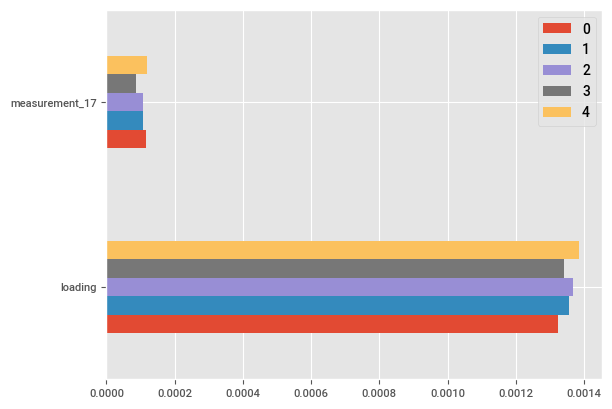

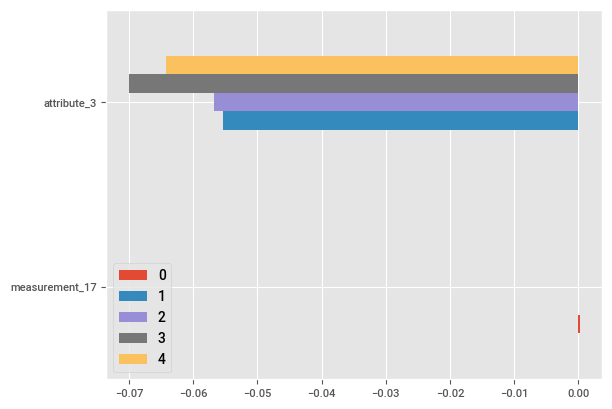

In [16]:
def retrieve_importances(estimator, features):
    # Get chosen feature names
    backup_cols = [col for col in features if col != estimator.backup_col]
    name_idx = estimator.classifier["fs"].get_feature_names_out()
    prim_names = [features[int(ni[1:])] for ni in name_idx]
    bu_name_idx = estimator.backup_est["fs"].get_feature_names_out()
    backup_names = [backup_cols[int(ni[1:])] for ni in bu_name_idx]

    # Get feature importances
    coefs = estimator.classifier["lr"].coef_
    if len(coefs.shape) > 1:
        coefs = coefs[0]
    prim_fi = pd.Series(coefs, index=prim_names)
    coefs = estimator.backup_est["lr"].coef_
    if len(coefs.shape) > 1:
        coefs = coefs[0]
    backup_fi = pd.Series(coefs, index=backup_names)
    backup_fi = pd.Series(
        estimator.backup_est["lr"].coef_[0], index=backup_names
    )

    return prim_fi, backup_fi


# Primary features
idx = 0
prim_cols = list(curr_pred)
prim_list, bu_list = [], []
for idx in range(5):
    prim_fi, backup_fi = retrieve_importances(estimators[idx], curr_pred)

    # Save
    prim_list.append(prim_fi)
    bu_list.append(backup_fi)

prim_df = pd.concat(prim_list, axis=1)
bu_df = pd.concat(bu_list, axis=1)

# Plot importances
plt.style.use("ggplot")

prim_df.plot.barh()
plt.show()
bu_df.plot.barh()
plt.show()


The model performs decently well compared to leaderboard submissions (~0.59 AUC). The primary model consistently uses the two expected features across all subsets. The backup consistently uses `attribute_3` as expected.

## Test Submissions

### Inspecting final model and predictions

What happens when we train on all data?



In [17]:
# Define iterative regressor
regressor = Pipeline([("si", SimpleImputer()), ("clf", Ridge())])

# Define classifier(s)
clf_primary = Pipeline(
    [
        ("si", SimpleImputer(strategy="median")),
        ("fs", SelectKBest(k=2)),
        ("lr", Ridge()),
    ]
)
clf_backup = Pipeline(
    [
        ("si", SimpleImputer(strategy="mean")),
        ("fs", SelectKBest(k=1)),
        ("lr", Ridge()),
    ]
)
est = IterativeGroupClassifier(
    regressor, clf_primary, backup_est=clf_backup, use_backup="partial"
)

# Use a feature subset
curr_pred = [
    "loading",
    "attribute_3",
    "measurement_17",
] + [f"measurement_{i}" for i in range(3, 10)]

y_pred = est.fit(
    train[curr_pred + ["product_code"]],
    train["failure"],
    test[curr_pred + ["product_code"]],
    return_predictions=True,
)

# Save preds
test_ = test.copy()
test_["failure"] = y_pred
test_.head()


id product_code  loading attribute_0 attribute_1  attribute_2  \
0  26570            F   119.57  material_5  material_6            6   
1  26571            F   113.51  material_5  material_6            6   
2  26572            F   112.16  material_5  material_6            6   
3  26573            F   112.72  material_5  material_6            6   
4  26574            F   208.00  material_5  material_6            6   

   attribute_3  measurement_0  measurement_1  measurement_2  ...  \
0            4              6              9              6  ...   
1            4             11              8              0  ...   
2            4              8             12              4  ...   
3            4              8             11             10  ...   
4            4             14             16              8  ...   

   measurement_9  measurement_10  measurement_11  measurement_12  \
0         10.802          15.909          18.070          13.772   
1         12.032          13.998             NaN          12.473   
2         11.743          17.046          18.086          10.907   
3         11.790          18.165          16.163          10.933   
4         12.370          14.578          17.849          11.941   

   measurement_13  measurement_14  measurement_15  measurement_16  \
0          13.659          16.825          13.742          17.710   
1          17.468          16.708          14.776          14.102   
2          13.363          15.737          17.065          16.021   
3          15.501          15.667          12.620          16.111   
4          16.070          16.183          13.324          17.150   

   measurement_17   failure  
0         634.612  0.194551  
1         537.037  0.175811  
2         658.995  0.187144  
3         594.301  0.180921  
4         801.044  0.332310  

[5 rows x 26 columns]

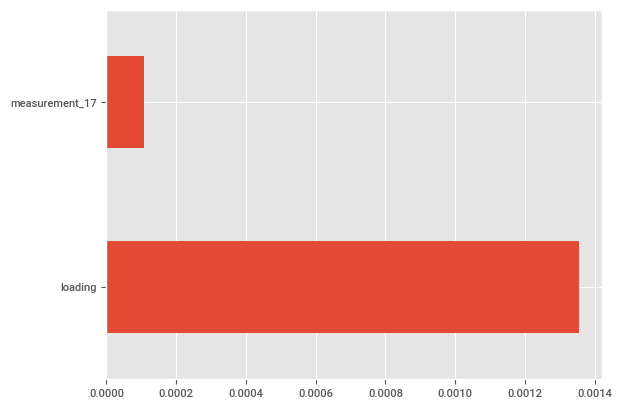

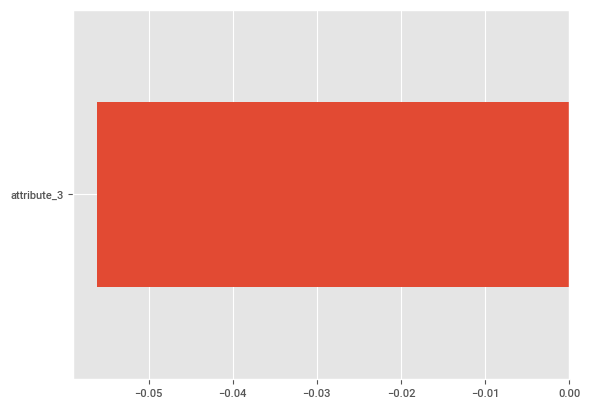

In [18]:
# Get importances
prim_fi, backup_fi = retrieve_importances(est, curr_pred)

# Plot importances
prim_fi.plot.barh()
plt.show()

# Plot backup importances
backup_fi.plot.barh()
plt.show()


In [19]:
test_.failure.describe()

count    20775.000000
mean         0.212896
std          0.054784
min          0.067137
25%          0.173569
50%          0.205807
75%          0.244090
max          0.545081
Name: failure, dtype: float64

### Final Takeaways for the Business

Using a linear regressor for a classification problem is underrated--it often performs just as well as logistic regression from a ranking perspective, and the coefficients have more meaning.

Final Takeaways:

1. 10-unit increase in `loading` roughly leads to a 1.3% increase in `failure` likelihood
2. 100-unit increase in `measurement_17` roughly leads to a 1% increase in `failure` likelihood
3. 1-unit increase in `attribute_3` _when `loading` is missing_ roughly leads to a 5.5% decrease in `failure` likelihood
4. Measurements 3-9 almost perfectly predict `measurement_17`


### Submitting Predictions

In [20]:
test_[["id", "failure"]].to_csv("../submissions/final_ridge_pred.csv", index=False)